In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import pandas as pd
import numpy as np
import math
import re
from re import findall

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import seaborn as sns
from pprint import pprint

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm

import io
import os
import json
from PIL import Image
import IPython.display as disp

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [3]:
df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
print('baseline profit & loss per day:', baseline_pnl)
df_trainval

baseline profit & loss per day: 0.0366


,dist_low_28,dist_low_60,dist_low_30,in_sess_time,dist_high_60,dist_high_30,dist_high_28,minute_time,hour_time,ret_std_z_90,...,roc_28,ret,eng_ma,roc_60,vwap_dev_pct_z_90,close_raw,signal,pred_signal,ask,bid
2009-01-02 12:30:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.147157,0.1,0.500000,...,0.504537,0.500548,0.502857,0.503281,0.500000,3.069643,1.624044e-07,0.057928,3.070257,3.069029
2009-01-02 12:31:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.148829,0.1,0.500000,...,0.504537,0.500548,0.502857,0.503281,0.500000,3.069643,1.840283e-07,0.057924,3.070257,3.069029
2009-01-02 12:32:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.150502,0.1,0.500000,...,0.504537,0.500548,0.502857,0.503281,0.500000,3.069643,2.085314e-07,0.057702,3.070257,3.069029
2009-01-02 12:33:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.152174,0.1,0.500000,...,0.504537,0.500548,0.502857,0.503281,0.500000,3.069643,2.362970e-07,0.057463,3.070257,3.069029
2009-01-02 12:34:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.153846,0.1,0.500000,...,0.504537,0.500548,0.502857,0.503281,0.500000,3.069643,2.677596e-07,0.057207,3.070257,3.069029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 20:56:00,0.190111,0.131679,0.183189,1.0,0.057014,0.044131,0.045622,0.993311,0.9,0.497293,...,0.574868,0.381398,0.598511,0.517734,0.506818,131.730000,1.177684e-01,0.076478,131.756346,131.703654
2022-12-23 20:57:00,0.218606,0.151416,0.210647,1.0,0.037104,0.016540,0.017098,0.994983,0.9,0.497872,...,0.586577,0.575084,0.604313,0.525328,0.515176,131.805000,5.830165e-02,0.102399,131.831361,131.778639
2022-12-23 20:58:00,0.228097,0.157990,0.219793,1.0,0.030473,0.007350,0.007598,0.996655,0.9,0.498126,...,0.588698,0.525379,0.609390,0.526069,0.515504,131.830000,3.644749e-02,0.107804,131.856366,131.803634
2022-12-23 20:59:00,0.239482,0.165876,0.230763,1.0,0.022518,0.000000,0.000000,0.998328,0.9,0.499176,...,0.586543,0.530340,0.619565,0.524711,0.513793,131.860000,0.000000e+00,0.122011,131.886372,131.833628


In [4]:
# Pre-compute per-day slices once
groups = df_trainval.groupby(df_trainval.index.normalize())
prun_perc = 70
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:
    
    sign_smoothwin = trial.suggest_categorical("sign_smoothwin", [1])
    sellmin_idx    = trial.suggest_categorical("sellmin_idx", [None, -1, -2])
    sess_start     = time.fromisoformat(trial.suggest_categorical("sess_start", [params.sess_start_pred.isoformat(), params.sess_start_reg.isoformat()]))
    buy_thresh     = trial.suggest_float("buy_thresh", 0.03, 0.3)
    trailstop_pct  = trial.suggest_float("trailstop_pct", 0.03, 0.3)

    print('-----------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Simulate trading using parameters ==> sign_smoothwin:',sign_smoothwin,'sellmin_idx:',sellmin_idx,'sess_start:',sess_start,'buy_thresh:',
          round(buy_thresh,4),'trailstop_pct:',round(trailstop_pct,4))
    
    daily_pnls: List[float] = []
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):

        # Causal smoothing of the raw pred_signal
        df_day["predsig_smooth"] = (
            df_day["pred_signal"]
              .rolling(window=sign_smoothwin, min_periods=1)
              .mean()
        )

        # Generate actions on the smoothed column
        df_actions = trades.generate_trade_actions(
            df                = df_day,
            col_signal        = "pred_signal",
            col_price         = "close_raw",
            buy_thresh        = buy_thresh,
            trailstop_pct     = trailstop_pct,
            sellmin_idx       = sellmin_idx,
            sess_start        = sess_start
            )

        # Simulate 1-day P&L
        sim = trades.simulate_trading(
            day               = day,
            df                = df_actions,
            sellmin_idx       = sellmin_idx, 
            sess_start        = sess_start
        )
   
        _, _, stats = next(iter(sim.values()))
        
        strategy_val = float(_findall(stats["STRATEGY"])[-1]) 

        daily_pnls.append(strategy_val)

        # Explicitly delete large locals at the end of each trial (no per-iteration gc.collect)
        del df_actions, sim, stats
        df_day = df_actions = sim = stats = None

        # Rreport for pruning
        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(daily_pnls))
            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = float(__import__("numpy").percentile(vals, prun_perc))
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # Average daily P&L
    return float(np.mean(daily_pnls))


-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0802 trailstop_pct: 0.0403


Trial 0: 100%|██████████| 3520/3520 [00:34<00:00, 102.06it/s]


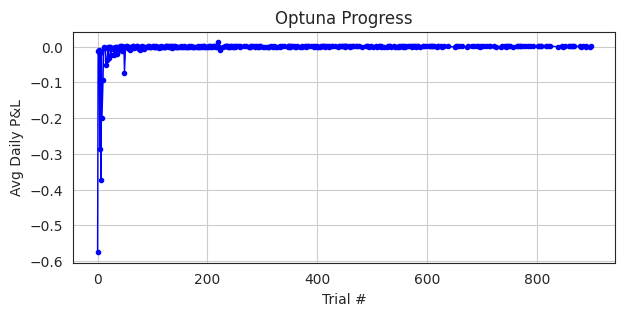

[Results] Trial 0 finished with value: -0.5753. Improvement over baseline: -1671.89%.     Best is trial 0 with value: -0.5753.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2653 trailstop_pct: 0.0786


Trial 1: 100%|██████████| 3520/3520 [00:27<00:00, 127.46it/s]


[Results] Trial 1 finished with value: -0.0124. Improvement over baseline: -133.80%.     Best is trial 1 with value: -0.0124.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2574 trailstop_pct: 0.1022


Trial 2: 100%|██████████| 3520/3520 [00:27<00:00, 127.99it/s]


[Results] Trial 2 finished with value: -0.0141. Improvement over baseline: -138.58%.     Best is trial 1 with value: -0.0124.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2527 trailstop_pct: 0.2955


Trial 3: 100%|██████████| 3520/3520 [00:27<00:00, 126.54it/s]


[Results] Trial 3 finished with value: -0.0091. Improvement over baseline: -124.98%.     Best is trial 3 with value: -0.0091.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.0589 trailstop_pct: 0.1838


Trial 4: 100%|██████████| 3520/3520 [00:32<00:00, 107.07it/s]


[Results] Trial 4 finished with value: -0.2860. Improvement over baseline: -881.35%.     Best is trial 3 with value: -0.0091.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2441 trailstop_pct: 0.2843


Trial 5: 100%|██████████| 3520/3520 [00:27<00:00, 127.84it/s]


[Results] Trial 5 finished with value: -0.0166. Improvement over baseline: -145.41%.     Best is trial 3 with value: -0.0091.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.0946 trailstop_pct: 0.1346


Trial 6: 100%|██████████| 3520/3520 [00:42<00:00, 82.36it/s]


[Results] Trial 6 finished with value: -0.3739. Improvement over baseline: -1121.64%.     Best is trial 3 with value: -0.0091.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2493 trailstop_pct: 0.0521


Trial 7: 100%|██████████| 3520/3520 [00:37<00:00, 93.43it/s] 


[Results] Trial 7 finished with value: -0.0165. Improvement over baseline: -145.05%.     Best is trial 3 with value: -0.0091.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.0891 trailstop_pct: 0.2915


Trial 8: 100%|██████████| 3520/3520 [00:44<00:00, 79.64it/s]


[Results] Trial 8 finished with value: -0.2000. Improvement over baseline: -646.43%.     Best is trial 3 with value: -0.0091.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.1986 trailstop_pct: 0.1292


Trial 9:  25%|██▌       | 892/3520 [00:09<00:29, 89.91it/s]


[PRUNE] value=-0.166982 thr=-0.004982
[Results] Trial 9 finished with value: -0.1670. Improvement over baseline: -556.24%.     Best is trial 3 with value: -0.0091.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1696 trailstop_pct: 0.2269


Trial 10: 100%|██████████| 3520/3520 [00:38<00:00, 91.48it/s] 


[Results] Trial 10 finished with value: -0.0935. Improvement over baseline: -355.53%.     Best is trial 3 with value: -0.0091.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2873 trailstop_pct: 0.2121


Trial 11: 100%|██████████| 3520/3520 [00:36<00:00, 96.24it/s] 


[Results] Trial 11 finished with value: -0.0027. Improvement over baseline: -107.32%.     Best is trial 11 with value: -0.0027.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2906 trailstop_pct: 0.2305


Trial 12: 100%|██████████| 3520/3520 [00:36<00:00, 96.23it/s] 


[Results] Trial 12 finished with value: -0.0016. Improvement over baseline: -104.24%.     Best is trial 12 with value: -0.0016.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2988 trailstop_pct: 0.2287


Trial 13: 100%|██████████| 3520/3520 [00:36<00:00, 96.86it/s] 


[Results] Trial 13 finished with value: -0.0051. Improvement over baseline: -113.82%.     Best is trial 12 with value: -0.0016.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2993 trailstop_pct: 0.2009


Trial 14: 100%|██████████| 3520/3520 [00:36<00:00, 96.42it/s] 


[Results] Trial 14 finished with value: -0.0044. Improvement over baseline: -112.13%.     Best is trial 12 with value: -0.0016.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2028 trailstop_pct: 0.2443


Trial 15: 100%|██████████| 3520/3520 [00:37<00:00, 94.80it/s] 


[Results] Trial 15 finished with value: -0.0503. Improvement over baseline: -237.51%.     Best is trial 12 with value: -0.0016.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.1359 trailstop_pct: 0.1568


Trial 16:  26%|██▌       | 898/3520 [00:10<00:30, 85.77it/s]


[PRUNE] value=-0.072484 thr=-0.002395
[Results] Trial 16 finished with value: -0.0725. Improvement over baseline: -298.04%.     Best is trial 12 with value: -0.0016.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2175 trailstop_pct: 0.2556


Trial 17: 100%|██████████| 3520/3520 [00:37<00:00, 93.73it/s] 


[Results] Trial 17 finished with value: -0.0382. Improvement over baseline: -204.49%.     Best is trial 12 with value: -0.0016.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.137 trailstop_pct: 0.2003


Trial 18:  25%|██▌       | 895/3520 [00:11<00:32, 79.85it/s]


[PRUNE] value=-0.071571 thr=-0.003044
[Results] Trial 18 finished with value: -0.0716. Improvement over baseline: -295.55%.     Best is trial 12 with value: -0.0016.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2808 trailstop_pct: 0.1646


Trial 19: 100%|██████████| 3520/3520 [00:36<00:00, 97.31it/s] 


[Results] Trial 19 finished with value: -0.0011. Improvement over baseline: -103.11%.     Best is trial 19 with value: -0.0011.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2249 trailstop_pct: 0.1517


Trial 20: 100%|██████████| 3520/3520 [00:36<00:00, 95.35it/s] 


[Results] Trial 20 finished with value: -0.0327. Improvement over baseline: -189.24%.     Best is trial 19 with value: -0.0011.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2805 trailstop_pct: 0.1726


Trial 21: 100%|██████████| 3520/3520 [00:36<00:00, 97.67it/s] 


[Results] Trial 21 finished with value: -0.0009. Improvement over baseline: -102.43%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2775 trailstop_pct: 0.1759


Trial 22: 100%|██████████| 3520/3520 [00:36<00:00, 97.60it/s] 


[Results] Trial 22 finished with value: -0.0021. Improvement over baseline: -105.73%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2768 trailstop_pct: 0.2591


Trial 23: 100%|██████████| 3520/3520 [00:36<00:00, 96.76it/s] 


[Results] Trial 23 finished with value: -0.0019. Improvement over baseline: -105.14%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2335 trailstop_pct: 0.1199


Trial 24: 100%|██████████| 3520/3520 [00:36<00:00, 97.06it/s] 


[Results] Trial 24 finished with value: -0.0236. Improvement over baseline: -164.42%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1765 trailstop_pct: 0.1808


Trial 25:  25%|██▌       | 891/3520 [00:09<00:29, 89.46it/s]


[PRUNE] value=-0.034046 thr=-0.001344
[Results] Trial 25 finished with value: -0.0340. Improvement over baseline: -193.02%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.272 trailstop_pct: 0.1515


Trial 26: 100%|██████████| 3520/3520 [00:35<00:00, 97.99it/s] 


[Results] Trial 26 finished with value: -0.0055. Improvement over baseline: -115.00%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2061 trailstop_pct: 0.0892


Trial 27:  26%|██▌       | 899/3520 [00:09<00:27, 95.02it/s] 


[PRUNE] value=-0.022430 thr=-0.001397
[Results] Trial 27 finished with value: -0.0224. Improvement over baseline: -161.28%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.143 trailstop_pct: 0.1969


Trial 28:  26%|██▌       | 898/3520 [00:10<00:29, 88.24it/s]


[PRUNE] value=-0.063537 thr=-0.001397
[Results] Trial 28 finished with value: -0.0635. Improvement over baseline: -273.60%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2993 trailstop_pct: 0.0302


Trial 29: 100%|██████████| 3520/3520 [00:40<00:00, 87.79it/s] 


[Results] Trial 29 finished with value: -0.0028. Improvement over baseline: -107.61%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2323 trailstop_pct: 0.2206


Trial 30: 100%|██████████| 3520/3520 [00:41<00:00, 83.87it/s] 


[Results] Trial 30 finished with value: -0.0235. Improvement over baseline: -164.24%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2797 trailstop_pct: 0.258


Trial 31: 100%|██████████| 3520/3520 [00:40<00:00, 87.01it/s] 


[Results] Trial 31 finished with value: -0.0010. Improvement over baseline: -102.81%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2651 trailstop_pct: 0.2661


Trial 32: 100%|██████████| 3520/3520 [00:31<00:00, 111.33it/s]


[Results] Trial 32 finished with value: -0.0083. Improvement over baseline: -122.66%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2787 trailstop_pct: 0.2367


Trial 33: 100%|██████████| 3520/3520 [00:30<00:00, 115.30it/s]


[Results] Trial 33 finished with value: -0.0015. Improvement over baseline: -104.18%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.257 trailstop_pct: 0.2732


Trial 34: 100%|██████████| 3520/3520 [00:35<00:00, 97.97it/s] 


[Results] Trial 34 finished with value: -0.0096. Improvement over baseline: -126.18%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2788 trailstop_pct: 0.2407


Trial 35: 100%|██████████| 3520/3520 [00:36<00:00, 95.46it/s] 


[Results] Trial 35 finished with value: -0.0015. Improvement over baseline: -104.10%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2396 trailstop_pct: 0.1086


Trial 36: 100%|██████████| 3520/3520 [00:35<00:00, 98.10it/s] 


[Results] Trial 36 finished with value: -0.0194. Improvement over baseline: -152.94%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2598 trailstop_pct: 0.1688


Trial 37: 100%|██████████| 3520/3520 [00:36<00:00, 97.55it/s] 


[Results] Trial 37 finished with value: -0.0109. Improvement over baseline: -129.83%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0507 trailstop_pct: 0.2471


Trial 38:  65%|██████▌   | 2296/3520 [00:27<00:14, 85.02it/s]


[PRUNE] value=-0.093108 thr=0.000971
[Results] Trial 38 finished with value: -0.0931. Improvement over baseline: -354.39%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2525 trailstop_pct: 0.1884


Trial 39: 100%|██████████| 3520/3520 [00:36<00:00, 96.62it/s] 


[Results] Trial 39 finished with value: -0.0095. Improvement over baseline: -125.96%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.1147 trailstop_pct: 0.0636


Trial 40:  25%|██▌       | 895/3520 [00:10<00:31, 84.31it/s]


[PRUNE] value=-0.146024 thr=-0.001258
[Results] Trial 40 finished with value: -0.1460. Improvement over baseline: -498.97%.     Best is trial 21 with value: -0.0009.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2833 trailstop_pct: 0.2365


Trial 41: 100%|██████████| 3520/3520 [00:36<00:00, 96.31it/s] 


[Results] Trial 41 finished with value: 0.0003. Improvement over baseline: -99.25%.     Best is trial 41 with value: 0.0003.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2847 trailstop_pct: 0.2754


Trial 42: 100%|██████████| 3520/3520 [00:36<00:00, 97.55it/s] 


[Results] Trial 42 finished with value: 0.0007. Improvement over baseline: -98.06%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2644 trailstop_pct: 0.2996


Trial 43: 100%|██████████| 3520/3520 [00:36<00:00, 96.75it/s] 


[Results] Trial 43 finished with value: -0.0086. Improvement over baseline: -123.55%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2869 trailstop_pct: 0.2832


Trial 44: 100%|██████████| 3520/3520 [00:35<00:00, 99.01it/s] 


[Results] Trial 44 finished with value: 0.0003. Improvement over baseline: -99.24%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2479 trailstop_pct: 0.2827


Trial 45: 100%|██████████| 3520/3520 [00:35<00:00, 99.69it/s] 


[Results] Trial 45 finished with value: -0.0126. Improvement over baseline: -134.54%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2911 trailstop_pct: 0.2811


Trial 46: 100%|██████████| 3520/3520 [00:37<00:00, 93.05it/s] 


[Results] Trial 46 finished with value: -0.0003. Improvement over baseline: -100.87%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2913 trailstop_pct: 0.2793


Trial 47: 100%|██████████| 3520/3520 [00:41<00:00, 85.38it/s] 


[Results] Trial 47 finished with value: -0.0017. Improvement over baseline: -104.77%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2665 trailstop_pct: 0.2896


Trial 48: 100%|██████████| 3520/3520 [00:38<00:00, 90.84it/s] 


[Results] Trial 48 finished with value: -0.0053. Improvement over baseline: -114.59%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.0359 trailstop_pct: 0.2664


Trial 49: 100%|██████████| 3520/3520 [00:38<00:00, 91.99it/s] 


[Results] Trial 49 finished with value: -0.0725. Improvement over baseline: -298.22%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.1845 trailstop_pct: 0.2142


Trial 50:  25%|██▌       | 891/3520 [00:07<00:21, 122.53it/s]


[PRUNE] value=-0.032337 thr=-0.000691
[Results] Trial 50 finished with value: -0.0323. Improvement over baseline: -188.35%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2869 trailstop_pct: 0.2504


Trial 51: 100%|██████████| 3520/3520 [00:31<00:00, 112.02it/s]


[Results] Trial 51 finished with value: 0.0003. Improvement over baseline: -99.27%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2895 trailstop_pct: 0.2762


Trial 52: 100%|██████████| 3520/3520 [00:41<00:00, 85.32it/s] 


[Results] Trial 52 finished with value: 0.0001. Improvement over baseline: -99.79%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2888 trailstop_pct: 0.2793


Trial 53: 100%|██████████| 3520/3520 [00:40<00:00, 86.67it/s] 


[Results] Trial 53 finished with value: 0.0004. Improvement over baseline: -98.94%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2928 trailstop_pct: 0.2724


Trial 54: 100%|██████████| 3520/3520 [00:40<00:00, 86.37it/s] 


[Results] Trial 54 finished with value: -0.0012. Improvement over baseline: -103.19%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.244 trailstop_pct: 0.2511


Trial 55:  71%|███████   | 2494/3520 [00:24<00:10, 100.15it/s]


[PRUNE] value=-0.001353 thr=0.002309
[Results] Trial 55 finished with value: -0.0014. Improvement over baseline: -103.70%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2996 trailstop_pct: 0.2904


Trial 56: 100%|██████████| 3520/3520 [00:35<00:00, 99.34it/s] 


[Results] Trial 56 finished with value: -0.0011. Improvement over baseline: -103.08%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2696 trailstop_pct: 0.2696


Trial 57: 100%|██████████| 3520/3520 [00:35<00:00, 99.93it/s] 


[Results] Trial 57 finished with value: -0.0058. Improvement over baseline: -115.79%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2865 trailstop_pct: 0.2998


Trial 58: 100%|██████████| 3520/3520 [00:35<00:00, 99.40it/s] 


[Results] Trial 58 finished with value: -0.0013. Improvement over baseline: -103.68%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2552 trailstop_pct: 0.2611


Trial 59: 100%|██████████| 3520/3520 [00:35<00:00, 99.52it/s] 


[Results] Trial 59 finished with value: -0.0105. Improvement over baseline: -128.78%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.213 trailstop_pct: 0.2305


Trial 60:  26%|██▌       | 898/3520 [00:09<00:28, 93.39it/s] 


[PRUNE] value=-0.013928 thr=-0.000174
[Results] Trial 60 finished with value: -0.0139. Improvement over baseline: -138.05%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2859 trailstop_pct: 0.278


Trial 61: 100%|██████████| 3520/3520 [00:36<00:00, 97.22it/s] 


[Results] Trial 61 finished with value: 0.0001. Improvement over baseline: -99.65%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2887 trailstop_pct: 0.2874


Trial 62: 100%|██████████| 3520/3520 [00:36<00:00, 95.42it/s] 


[Results] Trial 62 finished with value: 0.0001. Improvement over baseline: -99.76%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2711 trailstop_pct: 0.2907


Trial 63: 100%|██████████| 3520/3520 [00:36<00:00, 97.36it/s] 


[Results] Trial 63 finished with value: -0.0031. Improvement over baseline: -108.49%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2855 trailstop_pct: 0.2512


Trial 64: 100%|██████████| 3520/3520 [00:36<00:00, 97.25it/s] 


[Results] Trial 64 finished with value: 0.0006. Improvement over baseline: -98.32%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2846 trailstop_pct: 0.2547


Trial 65: 100%|██████████| 3520/3520 [00:36<00:00, 97.51it/s] 


[Results] Trial 65 finished with value: 0.0003. Improvement over baseline: -99.09%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2738 trailstop_pct: 0.2495


Trial 66: 100%|██████████| 3520/3520 [00:35<00:00, 97.93it/s] 


[Results] Trial 66 finished with value: -0.0033. Improvement over baseline: -109.00%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2615 trailstop_pct: 0.2405


Trial 67:  84%|████████▍ | 2949/3520 [00:30<00:05, 97.25it/s] 


[PRUNE] value=0.002278 thr=0.007376
[Results] Trial 67 finished with value: 0.0023. Improvement over baseline: -93.78%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2984 trailstop_pct: 0.2594


Trial 68:  25%|██▌       | 890/3520 [00:09<00:27, 96.08it/s] 


[PRUNE] value=-0.118926 thr=-0.000042
[Results] Trial 68 finished with value: -0.1189. Improvement over baseline: -424.93%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2369 trailstop_pct: 0.2102


Trial 69:  25%|██▌       | 897/3520 [00:09<00:27, 96.01it/s] 


[PRUNE] value=-0.007917 thr=-0.000042
[Results] Trial 69 finished with value: -0.0079. Improvement over baseline: -121.63%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2275 trailstop_pct: 0.2355


Trial 70:  26%|██▌       | 898/3520 [00:09<00:27, 93.81it/s] 


[PRUNE] value=-0.009472 thr=-0.000042
[Results] Trial 70 finished with value: -0.0095. Improvement over baseline: -125.88%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2845 trailstop_pct: 0.2527


Trial 71: 100%|██████████| 3520/3520 [00:36<00:00, 97.30it/s] 


[Results] Trial 71 finished with value: 0.0007. Improvement over baseline: -98.22%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2842 trailstop_pct: 0.2543


Trial 72: 100%|██████████| 3520/3520 [00:35<00:00, 98.57it/s] 


[Results] Trial 72 finished with value: 0.0003. Improvement over baseline: -99.27%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2744 trailstop_pct: 0.2212


Trial 73: 100%|██████████| 3520/3520 [00:36<00:00, 97.46it/s] 


[Results] Trial 73 finished with value: -0.0034. Improvement over baseline: -109.17%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2821 trailstop_pct: 0.2655


Trial 74: 100%|██████████| 3520/3520 [00:35<00:00, 98.60it/s] 


[Results] Trial 74 finished with value: -0.0007. Improvement over baseline: -101.89%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2694 trailstop_pct: 0.256


Trial 75: 100%|██████████| 3520/3520 [00:36<00:00, 97.20it/s] 


[Results] Trial 75 finished with value: -0.0065. Improvement over baseline: -117.64%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2515 trailstop_pct: 0.2424


Trial 76:  37%|███▋      | 1297/3520 [00:13<00:22, 97.75it/s] 


[PRUNE] value=-0.002661 thr=0.000247
[Results] Trial 76 finished with value: -0.0027. Improvement over baseline: -107.27%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2949 trailstop_pct: 0.223


Trial 77: 100%|██████████| 3520/3520 [00:36<00:00, 96.15it/s] 


[Results] Trial 77 finished with value: -0.0010. Improvement over baseline: -102.69%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2617 trailstop_pct: 0.2329


Trial 78: 100%|██████████| 3520/3520 [00:36<00:00, 96.45it/s] 


[Results] Trial 78 finished with value: -0.0097. Improvement over baseline: -126.37%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2816 trailstop_pct: 0.2661


Trial 79: 100%|██████████| 3520/3520 [00:36<00:00, 97.22it/s] 


[Results] Trial 79 finished with value: -0.0021. Improvement over baseline: -105.79%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.1582 trailstop_pct: 0.2531


Trial 80:  26%|██▌       | 898/3520 [00:10<00:29, 89.36it/s]


[PRUNE] value=-0.039588 thr=-0.000032
[Results] Trial 80 finished with value: -0.0396. Improvement over baseline: -208.16%.     Best is trial 42 with value: 0.0007.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2849 trailstop_pct: 0.2469


Trial 81: 100%|██████████| 3520/3520 [00:36<00:00, 97.27it/s] 


[Results] Trial 81 finished with value: 0.0008. Improvement over baseline: -97.73%.     Best is trial 81 with value: 0.0008.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2755 trailstop_pct: 0.2751


Trial 82: 100%|██████████| 3520/3520 [00:35<00:00, 99.35it/s] 


[Results] Trial 82 finished with value: -0.0023. Improvement over baseline: -106.15%.     Best is trial 81 with value: 0.0008.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2827 trailstop_pct: 0.2615


Trial 83: 100%|██████████| 3520/3520 [00:36<00:00, 97.76it/s] 


[Results] Trial 83 finished with value: -0.0001. Improvement over baseline: -100.25%.     Best is trial 81 with value: 0.0008.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2925 trailstop_pct: 0.2451


Trial 84: 100%|██████████| 3520/3520 [00:35<00:00, 99.15it/s] 


[Results] Trial 84 finished with value: -0.0007. Improvement over baseline: -101.87%.     Best is trial 81 with value: 0.0008.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.266 trailstop_pct: 0.2845


Trial 85: 100%|██████████| 3520/3520 [00:35<00:00, 98.62it/s] 


[Results] Trial 85 finished with value: -0.0064. Improvement over baseline: -117.49%.     Best is trial 81 with value: 0.0008.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2992 trailstop_pct: 0.2951


Trial 86: 100%|██████████| 3520/3520 [00:35<00:00, 97.99it/s] 


[Results] Trial 86 finished with value: -0.0010. Improvement over baseline: -102.74%.     Best is trial 81 with value: 0.0008.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2753 trailstop_pct: 0.2687


Trial 87:  48%|████▊     | 1691/3520 [00:17<00:18, 97.24it/s] 


[PRUNE] value=0.000084 thr=0.002456
[Results] Trial 87 finished with value: 0.0001. Improvement over baseline: -99.77%.     Best is trial 81 with value: 0.0008.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.246 trailstop_pct: 0.2268


Trial 88:  25%|██▌       | 896/3520 [00:09<00:27, 96.34it/s] 


[PRUNE] value=-0.004690 thr=-0.000024
[Results] Trial 88 finished with value: -0.0047. Improvement over baseline: -112.81%.     Best is trial 81 with value: 0.0008.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0693 trailstop_pct: 0.2145


Trial 89:  25%|██▌       | 891/3520 [00:10<00:32, 81.90it/s]


[PRUNE] value=-0.109966 thr=-0.000024
[Results] Trial 89 finished with value: -0.1100. Improvement over baseline: -400.45%.     Best is trial 81 with value: 0.0008.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1147 trailstop_pct: 0.2557


Trial 90:  26%|██▌       | 898/3520 [00:11<00:34, 76.68it/s]


[PRUNE] value=-0.081092 thr=-0.000024
[Results] Trial 90 finished with value: -0.0811. Improvement over baseline: -321.56%.     Best is trial 81 with value: 0.0008.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2879 trailstop_pct: 0.2393


Trial 91: 100%|██████████| 3520/3520 [00:41<00:00, 85.06it/s] 


[Results] Trial 91 finished with value: -0.0000. Improvement over baseline: -100.13%.     Best is trial 81 with value: 0.0008.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2842 trailstop_pct: 0.2721


Trial 92: 100%|██████████| 3520/3520 [00:41<00:00, 84.60it/s] 


[Results] Trial 92 finished with value: 0.0012. Improvement over baseline: -96.79%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2836 trailstop_pct: 0.2809


Trial 93: 100%|██████████| 3520/3520 [00:42<00:00, 83.43it/s] 


[Results] Trial 93 finished with value: 0.0007. Improvement over baseline: -98.20%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2555 trailstop_pct: 0.2801


Trial 94:  48%|████▊     | 1691/3520 [00:19<00:20, 88.06it/s] 


[PRUNE] value=0.000764 thr=0.002554
[Results] Trial 94 finished with value: 0.0008. Improvement over baseline: -97.91%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2931 trailstop_pct: 0.2718


Trial 95: 100%|██████████| 3520/3520 [00:38<00:00, 91.88it/s] 


[Results] Trial 95 finished with value: -0.0013. Improvement over baseline: -103.52%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.279 trailstop_pct: 0.2826


Trial 96: 100%|██████████| 3520/3520 [00:35<00:00, 98.68it/s] 


[Results] Trial 96 finished with value: -0.0005. Improvement over baseline: -101.26%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2685 trailstop_pct: 0.2935


Trial 97:  48%|████▊     | 1695/3520 [00:17<00:19, 95.10it/s] 


[PRUNE] value=0.000820 thr=0.002568
[Results] Trial 97 finished with value: 0.0008. Improvement over baseline: -97.76%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2941 trailstop_pct: 0.2616


Trial 98: 100%|██████████| 3520/3520 [00:35<00:00, 98.73it/s] 


[Results] Trial 98 finished with value: -0.0013. Improvement over baseline: -103.64%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2628 trailstop_pct: 0.2451


Trial 99:  48%|████▊     | 1690/3520 [00:17<00:19, 95.73it/s] 


[PRUNE] value=0.000534 thr=0.002586
[Results] Trial 99 finished with value: 0.0005. Improvement over baseline: -98.54%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2722 trailstop_pct: 0.2863


Trial 100:  48%|████▊     | 1697/3520 [00:17<00:18, 98.49it/s] 


[PRUNE] value=0.000765 thr=0.002586
[Results] Trial 100 finished with value: 0.0008. Improvement over baseline: -97.91%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.285 trailstop_pct: 0.2502


Trial 101: 100%|██████████| 3520/3520 [00:35<00:00, 99.25it/s] 


[Results] Trial 101 finished with value: 0.0008. Improvement over baseline: -97.68%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2844 trailstop_pct: 0.2736


Trial 102: 100%|██████████| 3520/3520 [00:35<00:00, 99.34it/s] 


[Results] Trial 102 finished with value: 0.0010. Improvement over baseline: -97.30%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2778 trailstop_pct: 0.2753


Trial 103: 100%|██████████| 3520/3520 [00:36<00:00, 97.27it/s] 


[Results] Trial 103 finished with value: -0.0008. Improvement over baseline: -102.20%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2849 trailstop_pct: 0.1391


Trial 104: 100%|██████████| 3520/3520 [00:33<00:00, 105.94it/s]


[Results] Trial 104 finished with value: -0.0014. Improvement over baseline: -103.93%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2962 trailstop_pct: 0.2631


Trial 105: 100%|██████████| 3520/3520 [00:35<00:00, 98.94it/s] 


[Results] Trial 105 finished with value: -0.0019. Improvement over baseline: -105.10%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.29 trailstop_pct: 0.2714


Trial 106: 100%|██████████| 3520/3520 [00:35<00:00, 99.18it/s] 


[Results] Trial 106 finished with value: 0.0004. Improvement over baseline: -99.03%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2906 trailstop_pct: 0.2717


Trial 107: 100%|██████████| 3520/3520 [00:35<00:00, 99.47it/s] 


[Results] Trial 107 finished with value: 0.0000. Improvement over baseline: -99.91%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1897 trailstop_pct: 0.2492


Trial 108:  25%|██▌       | 890/3520 [00:09<00:27, 94.49it/s] 


[PRUNE] value=-0.021401 thr=0.000056
[Results] Trial 108 finished with value: -0.0214. Improvement over baseline: -158.47%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2574 trailstop_pct: 0.2697


Trial 109:  37%|███▋      | 1297/3520 [00:13<00:23, 95.83it/s] 


[PRUNE] value=-0.001912 thr=0.000416
[Results] Trial 109 finished with value: -0.0019. Improvement over baseline: -105.22%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.278 trailstop_pct: 0.278


Trial 110: 100%|██████████| 3520/3520 [00:36<00:00, 97.69it/s] 


[Results] Trial 110 finished with value: -0.0008. Improvement over baseline: -102.06%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2869 trailstop_pct: 0.2884


Trial 111: 100%|██████████| 3520/3520 [00:36<00:00, 96.64it/s] 


[Results] Trial 111 finished with value: 0.0002. Improvement over baseline: -99.43%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2707 trailstop_pct: 0.2823


Trial 112: 100%|██████████| 3520/3520 [00:35<00:00, 99.82it/s] 


[Results] Trial 112 finished with value: -0.0052. Improvement over baseline: -114.23%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2816 trailstop_pct: 0.257


Trial 113: 100%|██████████| 3520/3520 [00:36<00:00, 96.38it/s] 


[Results] Trial 113 finished with value: -0.0002. Improvement over baseline: -100.46%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.295 trailstop_pct: 0.2962


Trial 114: 100%|██████████| 3520/3520 [00:35<00:00, 99.53it/s] 


[Results] Trial 114 finished with value: -0.0016. Improvement over baseline: -104.24%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2997 trailstop_pct: 0.2651


Trial 115: 100%|██████████| 3520/3520 [00:35<00:00, 99.59it/s] 


[Results] Trial 115 finished with value: -0.0007. Improvement over baseline: -101.88%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2888 trailstop_pct: 0.2771


Trial 116: 100%|██████████| 3520/3520 [00:35<00:00, 99.99it/s] 


[Results] Trial 116 finished with value: 0.0003. Improvement over baseline: -99.20%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.266 trailstop_pct: 0.2741


Trial 117:  48%|████▊     | 1691/3520 [00:17<00:18, 98.99it/s] 


[PRUNE] value=0.000861 thr=0.002617
[Results] Trial 117 finished with value: 0.0009. Improvement over baseline: -97.65%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2895 trailstop_pct: 0.2514


Trial 118: 100%|██████████| 3520/3520 [00:34<00:00, 100.61it/s]


[Results] Trial 118 finished with value: 0.0001. Improvement over baseline: -99.63%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2739 trailstop_pct: 0.2588


Trial 119:  48%|████▊     | 1693/3520 [00:17<00:19, 95.24it/s] 


[PRUNE] value=0.001053 thr=0.002624
[Results] Trial 119 finished with value: 0.0011. Improvement over baseline: -97.12%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2822 trailstop_pct: 0.2458


Trial 120: 100%|██████████| 3520/3520 [00:35<00:00, 100.05it/s]


[Results] Trial 120 finished with value: -0.0016. Improvement over baseline: -104.28%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2867 trailstop_pct: 0.2786


Trial 121: 100%|██████████| 3520/3520 [00:36<00:00, 97.53it/s] 


[Results] Trial 121 finished with value: 0.0002. Improvement over baseline: -99.46%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2776 trailstop_pct: 0.2649


Trial 122: 100%|██████████| 3520/3520 [00:36<00:00, 97.43it/s] 


[Results] Trial 122 finished with value: -0.0018. Improvement over baseline: -104.95%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2928 trailstop_pct: 0.2892


Trial 123: 100%|██████████| 3520/3520 [00:36<00:00, 97.37it/s] 


[Results] Trial 123 finished with value: -0.0013. Improvement over baseline: -103.50%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2849 trailstop_pct: 0.285


Trial 124: 100%|██████████| 3520/3520 [00:36<00:00, 96.95it/s] 


[Results] Trial 124 finished with value: 0.0008. Improvement over baseline: -97.88%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2831 trailstop_pct: 0.2702


Trial 125: 100%|██████████| 3520/3520 [00:35<00:00, 99.25it/s] 


[Results] Trial 125 finished with value: 0.0004. Improvement over baseline: -98.93%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2706 trailstop_pct: 0.2676


Trial 126:  81%|████████  | 2843/3520 [00:29<00:07, 96.56it/s] 


[PRUNE] value=0.002584 thr=0.006015
[Results] Trial 126 finished with value: 0.0026. Improvement over baseline: -92.94%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2825 trailstop_pct: 0.271


Trial 127: 100%|██████████| 3520/3520 [00:35<00:00, 100.42it/s]


[Results] Trial 127 finished with value: 0.0005. Improvement over baseline: -98.55%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2803 trailstop_pct: 0.2951


Trial 128: 100%|██████████| 3520/3520 [00:39<00:00, 88.06it/s] 


[Results] Trial 128 finished with value: 0.0008. Improvement over baseline: -97.77%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2593 trailstop_pct: 0.2996


Trial 129:  48%|████▊     | 1698/3520 [00:19<00:21, 84.94it/s] 


[PRUNE] value=0.000545 thr=0.002645
[Results] Trial 129 finished with value: 0.0005. Improvement over baseline: -98.51%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2767 trailstop_pct: 0.292


Trial 130: 100%|██████████| 3520/3520 [00:39<00:00, 88.87it/s] 


[Results] Trial 130 finished with value: -0.0009. Improvement over baseline: -102.48%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2998 trailstop_pct: 0.2847


Trial 131: 100%|██████████| 3520/3520 [00:40<00:00, 86.31it/s] 


[Results] Trial 131 finished with value: -0.0009. Improvement over baseline: -102.51%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2805 trailstop_pct: 0.2715


Trial 132: 100%|██████████| 3520/3520 [00:41<00:00, 85.70it/s] 


[Results] Trial 132 finished with value: 0.0008. Improvement over baseline: -97.85%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2805 trailstop_pct: 0.2812


Trial 133: 100%|██████████| 3520/3520 [00:41<00:00, 85.42it/s] 


[Results] Trial 133 finished with value: 0.0002. Improvement over baseline: -99.33%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2653 trailstop_pct: 0.2928


Trial 134:  48%|████▊     | 1691/3520 [00:18<00:20, 89.44it/s] 


[PRUNE] value=0.000996 thr=0.002654
[Results] Trial 134 finished with value: 0.0010. Improvement over baseline: -97.28%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2741 trailstop_pct: 0.287


Trial 135: 100%|██████████| 3520/3520 [00:35<00:00, 100.40it/s]


[Results] Trial 135 finished with value: -0.0027. Improvement over baseline: -107.36%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2837 trailstop_pct: 0.2617


Trial 136: 100%|██████████| 3520/3520 [00:40<00:00, 86.00it/s] 


[Results] Trial 136 finished with value: 0.0005. Improvement over baseline: -98.63%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2825 trailstop_pct: 0.2595


Trial 137: 100%|██████████| 3520/3520 [00:40<00:00, 86.94it/s] 


[Results] Trial 137 finished with value: -0.0001. Improvement over baseline: -100.34%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2677 trailstop_pct: 0.0872


Trial 138:  26%|██▌       | 898/3520 [00:09<00:27, 95.69it/s] 


[PRUNE] value=-0.002504 thr=0.000074
[Results] Trial 138 finished with value: -0.0025. Improvement over baseline: -106.84%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2841 trailstop_pct: 0.2713


Trial 139: 100%|██████████| 3520/3520 [00:30<00:00, 115.89it/s]


[Results] Trial 139 finished with value: 0.0011. Improvement over baseline: -96.89%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2949 trailstop_pct: 0.2638


Trial 140: 100%|██████████| 3520/3520 [00:32<00:00, 106.71it/s]


[Results] Trial 140 finished with value: -0.0018. Improvement over baseline: -104.88%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2833 trailstop_pct: 0.2725


Trial 141: 100%|██████████| 3520/3520 [00:36<00:00, 96.32it/s] 


[Results] Trial 141 finished with value: 0.0010. Improvement over baseline: -97.25%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.274 trailstop_pct: 0.2738


Trial 142:  48%|████▊     | 1695/3520 [00:18<00:19, 91.60it/s] 


[PRUNE] value=0.001379 thr=0.002641
[Results] Trial 142 finished with value: 0.0014. Improvement over baseline: -96.23%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2792 trailstop_pct: 0.2548


Trial 143: 100%|██████████| 3520/3520 [00:32<00:00, 109.22it/s]


[Results] Trial 143 finished with value: -0.0009. Improvement over baseline: -102.54%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2865 trailstop_pct: 0.2668


Trial 144: 100%|██████████| 3520/3520 [00:36<00:00, 95.46it/s] 


[Results] Trial 144 finished with value: 0.0001. Improvement over baseline: -99.83%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2941 trailstop_pct: 0.2757


Trial 145: 100%|██████████| 3520/3520 [00:40<00:00, 86.72it/s] 


[Results] Trial 145 finished with value: -0.0012. Improvement over baseline: -103.31%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2704 trailstop_pct: 0.2484


Trial 146:  43%|████▎     | 1497/3520 [00:15<00:21, 95.62it/s] 


[PRUNE] value=-0.000555 thr=0.001032
[Results] Trial 146 finished with value: -0.0006. Improvement over baseline: -101.52%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2843 trailstop_pct: 0.2838


Trial 147: 100%|██████████| 3520/3520 [00:34<00:00, 101.75it/s]


[Results] Trial 147 finished with value: -0.0005. Improvement over baseline: -101.46%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2777 trailstop_pct: 0.2607


Trial 148:  81%|████████  | 2849/3520 [00:29<00:06, 97.35it/s] 


[PRUNE] value=0.004565 thr=0.006256
[Results] Trial 148 finished with value: 0.0046. Improvement over baseline: -87.53%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2907 trailstop_pct: 0.2398


Trial 149:  81%|████████  | 2841/3520 [00:29<00:06, 97.48it/s] 


[PRUNE] value=0.004830 thr=0.006256
[Results] Trial 149 finished with value: 0.0048. Improvement over baseline: -86.80%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2649 trailstop_pct: 0.2709


Trial 150:  81%|████████  | 2846/3520 [00:30<00:07, 92.99it/s] 


[PRUNE] value=0.002694 thr=0.006256
[Results] Trial 150 finished with value: 0.0027. Improvement over baseline: -92.64%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2803 trailstop_pct: 0.2677


Trial 151: 100%|██████████| 3520/3520 [00:36<00:00, 96.51it/s] 


[Results] Trial 151 finished with value: -0.0007. Improvement over baseline: -101.92%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2835 trailstop_pct: 0.2746


Trial 152: 100%|██████████| 3520/3520 [00:36<00:00, 97.12it/s] 


[Results] Trial 152 finished with value: 0.0010. Improvement over baseline: -97.21%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.286 trailstop_pct: 0.0591


Trial 153:  76%|███████▋  | 2691/3520 [00:27<00:08, 96.62it/s] 


[PRUNE] value=0.002401 thr=0.003399
[Results] Trial 153 finished with value: 0.0024. Improvement over baseline: -93.44%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.293 trailstop_pct: 0.2785


Trial 154: 100%|██████████| 3520/3520 [00:36<00:00, 96.78it/s] 


[Results] Trial 154 finished with value: -0.0016. Improvement over baseline: -104.45%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2754 trailstop_pct: 0.2967


Trial 155: 100%|██████████| 3520/3520 [00:37<00:00, 95.04it/s] 


[Results] Trial 155 finished with value: -0.0015. Improvement over baseline: -104.22%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2722 trailstop_pct: 0.2871


Trial 156:  48%|████▊     | 1690/3520 [00:17<00:18, 96.38it/s] 


[PRUNE] value=0.001345 thr=0.002648
[Results] Trial 156 finished with value: 0.0013. Improvement over baseline: -96.32%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2837 trailstop_pct: 0.2615


Trial 157: 100%|██████████| 3520/3520 [00:36<00:00, 97.01it/s] 


[Results] Trial 157 finished with value: 0.0004. Improvement over baseline: -98.82%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0907 trailstop_pct: 0.2527


Trial 158:  25%|██▌       | 891/3520 [00:10<00:31, 83.20it/s]


[PRUNE] value=-0.104561 thr=0.000081
[Results] Trial 158 finished with value: -0.1046. Improvement over baseline: -385.69%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1537 trailstop_pct: 0.2745


Trial 159:  25%|██▌       | 894/3520 [00:09<00:29, 89.61it/s]


[PRUNE] value=-0.039593 thr=0.000081
[Results] Trial 159 finished with value: -0.0396. Improvement over baseline: -208.18%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2953 trailstop_pct: 0.2568


Trial 160: 100%|██████████| 3520/3520 [00:35<00:00, 97.80it/s] 


[Results] Trial 160 finished with value: -0.0012. Improvement over baseline: -103.28%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2856 trailstop_pct: 0.2626


Trial 161: 100%|██████████| 3520/3520 [00:35<00:00, 99.10it/s] 


[Results] Trial 161 finished with value: -0.0006. Improvement over baseline: -101.68%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2816 trailstop_pct: 0.2812


Trial 162: 100%|██████████| 3520/3520 [00:35<00:00, 98.58it/s] 


[Results] Trial 162 finished with value: -0.0000. Improvement over baseline: -100.04%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2899 trailstop_pct: 0.1933


Trial 163:  81%|████████  | 2847/3520 [00:29<00:06, 98.13it/s] 


[PRUNE] value=0.004778 thr=0.006294
[Results] Trial 163 finished with value: 0.0048. Improvement over baseline: -86.94%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2775 trailstop_pct: 0.2699


Trial 164: 100%|██████████| 3520/3520 [00:36<00:00, 96.93it/s] 


[Results] Trial 164 finished with value: -0.0016. Improvement over baseline: -104.36%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2889 trailstop_pct: 0.2608


Trial 165:  81%|████████  | 2845/3520 [00:29<00:06, 97.55it/s] 


[PRUNE] value=0.005130 thr=0.006288
[Results] Trial 165 finished with value: 0.0051. Improvement over baseline: -85.98%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2837 trailstop_pct: 0.2747


Trial 166: 100%|██████████| 3520/3520 [00:36<00:00, 96.52it/s] 


[Results] Trial 166 finished with value: 0.0011. Improvement over baseline: -97.04%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2984 trailstop_pct: 0.2747


Trial 167: 100%|██████████| 3520/3520 [00:36<00:00, 97.64it/s] 


[Results] Trial 167 finished with value: -0.0012. Improvement over baseline: -103.15%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2737 trailstop_pct: 0.2887


Trial 168:  48%|████▊     | 1699/3520 [00:19<00:20, 87.51it/s]


[PRUNE] value=0.001542 thr=0.002647
[Results] Trial 168 finished with value: 0.0015. Improvement over baseline: -95.79%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1089 trailstop_pct: 0.2801


Trial 169:  25%|██▌       | 896/3520 [00:12<00:36, 72.29it/s]


[PRUNE] value=-0.081223 thr=0.000083
[Results] Trial 169 finished with value: -0.0812. Improvement over baseline: -321.92%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2694 trailstop_pct: 0.2937


Trial 170:  37%|███▋      | 1294/3520 [00:14<00:25, 87.30it/s]


[PRUNE] value=-0.001333 thr=0.000508
[Results] Trial 170 finished with value: -0.0013. Improvement over baseline: -103.64%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2845 trailstop_pct: 0.2657


Trial 171: 100%|██████████| 3520/3520 [00:41<00:00, 85.19it/s] 


[Results] Trial 171 finished with value: 0.0003. Improvement over baseline: -99.19%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2813 trailstop_pct: 0.2698


Trial 172: 100%|██████████| 3520/3520 [00:39<00:00, 89.01it/s] 


[Results] Trial 172 finished with value: -0.0007. Improvement over baseline: -101.87%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2897 trailstop_pct: 0.2467


Trial 173:  81%|████████  | 2845/3520 [00:28<00:06, 99.46it/s] 


[PRUNE] value=0.005216 thr=0.006331
[Results] Trial 173 finished with value: 0.0052. Improvement over baseline: -85.75%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2792 trailstop_pct: 0.2769


Trial 174: 100%|██████████| 3520/3520 [00:35<00:00, 99.18it/s] 


[Results] Trial 174 finished with value: -0.0003. Improvement over baseline: -100.94%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2844 trailstop_pct: 0.2532


Trial 175: 100%|██████████| 3520/3520 [00:35<00:00, 98.75it/s] 


[Results] Trial 175 finished with value: 0.0002. Improvement over baseline: -99.49%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2942 trailstop_pct: 0.2844


Trial 176: 100%|██████████| 3520/3520 [00:36<00:00, 97.76it/s] 


[Results] Trial 176 finished with value: -0.0014. Improvement over baseline: -103.72%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.262 trailstop_pct: 0.263


Trial 177:  35%|███▌      | 1249/3520 [00:12<00:23, 98.23it/s] 


[PRUNE] value=-0.002022 thr=0.000402
[Results] Trial 177 finished with value: -0.0020. Improvement over baseline: -105.53%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2764 trailstop_pct: 0.2731


Trial 178:  48%|████▊     | 1692/3520 [00:17<00:19, 95.87it/s] 


[PRUNE] value=0.001556 thr=0.002641
[Results] Trial 178 finished with value: 0.0016. Improvement over baseline: -95.75%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2889 trailstop_pct: 0.2593


Trial 179:  81%|████████  | 2842/3520 [00:29<00:07, 96.45it/s] 


[PRUNE] value=0.005178 thr=0.006333
[Results] Trial 179 finished with value: 0.0052. Improvement over baseline: -85.85%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2699 trailstop_pct: 0.1088


Trial 180:  25%|██▌       | 893/3520 [00:09<00:27, 97.03it/s] 


[PRUNE] value=-0.002289 thr=0.000076
[Results] Trial 180 finished with value: -0.0023. Improvement over baseline: -106.25%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2863 trailstop_pct: 0.2683


Trial 181: 100%|██████████| 3520/3520 [00:35<00:00, 97.88it/s] 


[Results] Trial 181 finished with value: -0.0001. Improvement over baseline: -100.21%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2831 trailstop_pct: 0.2798


Trial 182: 100%|██████████| 3520/3520 [00:36<00:00, 97.70it/s] 


[Results] Trial 182 finished with value: 0.0008. Improvement over baseline: -97.89%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2813 trailstop_pct: 0.2802


Trial 183: 100%|██████████| 3520/3520 [00:36<00:00, 95.53it/s] 


[Results] Trial 183 finished with value: -0.0004. Improvement over baseline: -101.02%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2927 trailstop_pct: 0.2852


Trial 184: 100%|██████████| 3520/3520 [00:36<00:00, 97.58it/s] 


[Results] Trial 184 finished with value: -0.0016. Improvement over baseline: -104.43%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2765 trailstop_pct: 0.2744


Trial 185:  48%|████▊     | 1693/3520 [00:17<00:18, 97.30it/s] 


[PRUNE] value=0.001695 thr=0.002649
[Results] Trial 185 finished with value: 0.0017. Improvement over baseline: -95.37%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2824 trailstop_pct: 0.2918


Trial 186:  81%|████████  | 2847/3520 [00:28<00:06, 98.84it/s] 


[PRUNE] value=0.004493 thr=0.006343
[Results] Trial 186 finished with value: 0.0045. Improvement over baseline: -87.72%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2987 trailstop_pct: 0.2661


Trial 187: 100%|██████████| 3520/3520 [00:35<00:00, 98.47it/s] 


[Results] Trial 187 finished with value: -0.0013. Improvement over baseline: -103.45%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2873 trailstop_pct: 0.2572


Trial 188: 100%|██████████| 3520/3520 [00:38<00:00, 91.04it/s] 


[Results] Trial 188 finished with value: 0.0004. Improvement over baseline: -98.99%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2743 trailstop_pct: 0.2815


Trial 189:  48%|████▊     | 1691/3520 [00:18<00:20, 89.33it/s] 


[PRUNE] value=0.001532 thr=0.002652
[Results] Trial 189 finished with value: 0.0015. Improvement over baseline: -95.81%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2913 trailstop_pct: 0.1578


Trial 190:  81%|████████  | 2843/3520 [00:33<00:07, 84.70it/s] 


[PRUNE] value=0.004236 thr=0.006337
[Results] Trial 190 finished with value: 0.0042. Improvement over baseline: -88.43%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2829 trailstop_pct: 0.2701


Trial 191: 100%|██████████| 3520/3520 [00:36<00:00, 97.40it/s] 


[Results] Trial 191 finished with value: 0.0001. Improvement over baseline: -99.60%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2814 trailstop_pct: 0.2724


Trial 192: 100%|██████████| 3520/3520 [00:36<00:00, 97.02it/s] 


[Results] Trial 192 finished with value: 0.0004. Improvement over baseline: -98.98%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2853 trailstop_pct: 0.2776


Trial 193: 100%|██████████| 3520/3520 [00:35<00:00, 99.48it/s] 


[Results] Trial 193 finished with value: 0.0008. Improvement over baseline: -97.81%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2863 trailstop_pct: 0.2779


Trial 194: 100%|██████████| 3520/3520 [00:35<00:00, 98.35it/s] 


[Results] Trial 194 finished with value: 0.0003. Improvement over baseline: -99.16%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2787 trailstop_pct: 0.2859


Trial 195: 100%|██████████| 3520/3520 [00:35<00:00, 98.66it/s] 


[Results] Trial 195 finished with value: -0.0008. Improvement over baseline: -102.07%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2948 trailstop_pct: 0.2653


Trial 196: 100%|██████████| 3520/3520 [00:36<00:00, 97.46it/s] 


[Results] Trial 196 finished with value: -0.0014. Improvement over baseline: -103.82%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2718 trailstop_pct: 0.2781


Trial 197:  43%|████▎     | 1497/3520 [00:15<00:20, 96.77it/s] 


[PRUNE] value=-0.000129 thr=0.001049
[Results] Trial 197 finished with value: -0.0001. Improvement over baseline: -100.35%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2892 trailstop_pct: 0.2428


Trial 198:  81%|████████  | 2849/3520 [00:29<00:06, 96.72it/s] 


[PRUNE] value=0.005260 thr=0.006365
[Results] Trial 198 finished with value: 0.0053. Improvement over baseline: -85.63%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2778 trailstop_pct: 0.2743


Trial 199: 100%|██████████| 3520/3520 [00:35<00:00, 99.58it/s] 


[Results] Trial 199 finished with value: -0.0009. Improvement over baseline: -102.54%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2662 trailstop_pct: 0.2515


Trial 200:  25%|██▌       | 889/3520 [00:09<00:28, 91.02it/s] 


[PRUNE] value=-0.003097 thr=0.000085
[Results] Trial 200 finished with value: -0.0031. Improvement over baseline: -108.46%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2864 trailstop_pct: 0.2695


Trial 201: 100%|██████████| 3520/3520 [00:35<00:00, 98.80it/s] 


[Results] Trial 201 finished with value: -0.0001. Improvement over baseline: -100.26%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2835 trailstop_pct: 0.2588


Trial 202: 100%|██████████| 3520/3520 [00:36<00:00, 95.66it/s] 


[Results] Trial 202 finished with value: 0.0006. Improvement over baseline: -98.31%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2836 trailstop_pct: 0.2623


Trial 203: 100%|██████████| 3520/3520 [00:36<00:00, 96.80it/s] 


[Results] Trial 203 finished with value: 0.0004. Improvement over baseline: -99.00%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2923 trailstop_pct: 0.2572


Trial 204:  81%|████████  | 2839/3520 [00:30<00:07, 94.01it/s] 


[PRUNE] value=0.005135 thr=0.006369
[Results] Trial 204 finished with value: 0.0051. Improvement over baseline: -85.97%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2782 trailstop_pct: 0.2889


Trial 205: 100%|██████████| 3520/3520 [00:36<00:00, 96.88it/s] 


[Results] Trial 205 finished with value: 0.0002. Improvement over baseline: -99.45%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2728 trailstop_pct: 0.281


Trial 206:  43%|████▎     | 1499/3520 [00:17<00:23, 86.73it/s] 


[PRUNE] value=0.000008 thr=0.001048
[Results] Trial 206 finished with value: 0.0000. Improvement over baseline: -99.98%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2836 trailstop_pct: 0.2499


Trial 207: 100%|██████████| 3520/3520 [00:41<00:00, 84.73it/s] 


[Results] Trial 207 finished with value: 0.0010. Improvement over baseline: -97.17%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2998 trailstop_pct: 0.2484


Trial 208: 100%|██████████| 3520/3520 [00:40<00:00, 87.48it/s] 


[Results] Trial 208 finished with value: 0.0001. Improvement over baseline: -99.71%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.291 trailstop_pct: 0.2429


Trial 209:  81%|████████  | 2849/3520 [00:33<00:07, 84.17it/s] 


[PRUNE] value=0.005244 thr=0.006371
[Results] Trial 209 finished with value: 0.0052. Improvement over baseline: -85.67%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2807 trailstop_pct: 0.2525


Trial 210:  81%|████████  | 2847/3520 [00:33<00:07, 85.65it/s] 


[PRUNE] value=0.005356 thr=0.006371
[Results] Trial 210 finished with value: 0.0054. Improvement over baseline: -85.36%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2837 trailstop_pct: 0.2651


Trial 211: 100%|██████████| 3520/3520 [00:38<00:00, 91.73it/s] 


[Results] Trial 211 finished with value: 0.0005. Improvement over baseline: -98.67%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2871 trailstop_pct: 0.2327


Trial 212: 100%|██████████| 3520/3520 [00:35<00:00, 98.67it/s] 


[Results] Trial 212 finished with value: 0.0005. Improvement over baseline: -98.68%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2761 trailstop_pct: 0.2666


Trial 213:  42%|████▏     | 1491/3520 [00:16<00:22, 90.35it/s]


[PRUNE] value=0.000097 thr=0.001048
[Results] Trial 213 finished with value: 0.0001. Improvement over baseline: -99.74%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2842 trailstop_pct: 0.276


Trial 214: 100%|██████████| 3520/3520 [00:36<00:00, 97.67it/s] 


[Results] Trial 214 finished with value: 0.0009. Improvement over baseline: -97.49%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2918 trailstop_pct: 0.2767


Trial 215: 100%|██████████| 3520/3520 [00:36<00:00, 95.17it/s] 


[Results] Trial 215 finished with value: -0.0008. Improvement over baseline: -102.28%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2803 trailstop_pct: 0.2841


Trial 216: 100%|██████████| 3520/3520 [00:36<00:00, 96.73it/s] 


[Results] Trial 216 finished with value: -0.0002. Improvement over baseline: -100.50%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2871 trailstop_pct: 0.2727


Trial 217: 100%|██████████| 3520/3520 [00:36<00:00, 97.39it/s] 


[Results] Trial 217 finished with value: 0.0009. Improvement over baseline: -97.41%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2891 trailstop_pct: 0.2742


Trial 218: 100%|██████████| 3520/3520 [00:36<00:00, 95.66it/s] 


[Results] Trial 218 finished with value: 0.0003. Improvement over baseline: -99.21%.     Best is trial 92 with value: 0.0012.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.0326 trailstop_pct: 0.2968


Trial 219: 100%|██████████| 3520/3520 [00:42<00:00, 82.24it/s]


[Results] Trial 219 finished with value: 0.0122. Improvement over baseline: -66.68%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.079 trailstop_pct: 0.2956


Trial 220:  25%|██▌       | 892/3520 [00:11<00:33, 79.55it/s]


[PRUNE] value=-0.205743 thr=0.000117
[Results] Trial 220 finished with value: -0.2057. Improvement over baseline: -662.14%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.295 trailstop_pct: 0.2923


Trial 221:  25%|██▌       | 891/3520 [00:09<00:27, 94.34it/s] 


[PRUNE] value=-0.019226 thr=0.000117
[Results] Trial 221 finished with value: -0.0192. Improvement over baseline: -152.53%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2859 trailstop_pct: 0.2875


Trial 222: 100%|██████████| 3520/3520 [00:36<00:00, 97.75it/s] 


[Results] Trial 222 finished with value: 0.0002. Improvement over baseline: -99.46%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.0377 trailstop_pct: 0.28


Trial 223: 100%|██████████| 3520/3520 [00:41<00:00, 84.47it/s]


[Results] Trial 223 finished with value: -0.0097. Improvement over baseline: -126.48%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.1813 trailstop_pct: 0.2728


Trial 224:  25%|██▌       | 892/3520 [00:09<00:28, 91.75it/s] 


[PRUNE] value=-0.162054 thr=0.000123
[Results] Trial 224 finished with value: -0.1621. Improvement over baseline: -542.77%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2136 trailstop_pct: 0.2833


Trial 225:  25%|██▌       | 895/3520 [00:09<00:28, 92.14it/s] 


[PRUNE] value=-0.008907 thr=0.000123
[Results] Trial 225 finished with value: -0.0089. Improvement over baseline: -124.34%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.0541 trailstop_pct: 0.2973


Trial 226:  82%|████████▏ | 2893/3520 [00:35<00:07, 80.77it/s]


[PRUNE] value=-0.054208 thr=0.006850
[Results] Trial 226 finished with value: -0.0542. Improvement over baseline: -248.11%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0998 trailstop_pct: 0.2908


Trial 227:  25%|██▌       | 896/3520 [00:10<00:31, 82.84it/s]


[PRUNE] value=-0.191658 thr=0.000123
[Results] Trial 227 finished with value: -0.1917. Improvement over baseline: -623.66%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2742 trailstop_pct: 0.278


Trial 228:  42%|████▏     | 1489/3520 [00:15<00:21, 95.24it/s] 


[PRUNE] value=0.000218 thr=0.001067
[Results] Trial 228 finished with value: 0.0002. Improvement over baseline: -99.40%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2796 trailstop_pct: 0.2704


Trial 229: 100%|██████████| 3520/3520 [00:36<00:00, 97.71it/s] 


[Results] Trial 229 finished with value: -0.0010. Improvement over baseline: -102.79%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1633 trailstop_pct: 0.1793


Trial 230:  26%|██▌       | 898/3520 [00:10<00:29, 89.44it/s]


[PRUNE] value=-0.043723 thr=0.000118
[Results] Trial 230 finished with value: -0.0437. Improvement over baseline: -219.46%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1293 trailstop_pct: 0.2581


Trial 231:  25%|██▌       | 890/3520 [00:10<00:31, 84.05it/s]


[PRUNE] value=-0.066688 thr=0.000118
[Results] Trial 231 finished with value: -0.0667. Improvement over baseline: -282.21%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2844 trailstop_pct: 0.2997


Trial 232: 100%|██████████| 3520/3520 [00:35<00:00, 98.66it/s] 


[Results] Trial 232 finished with value: 0.0007. Improvement over baseline: -98.18%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2871 trailstop_pct: 0.2977


Trial 233: 100%|██████████| 3520/3520 [00:36<00:00, 97.18it/s] 


[Results] Trial 233 finished with value: 0.0009. Improvement over baseline: -97.55%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2889 trailstop_pct: 0.2998


Trial 234: 100%|██████████| 3520/3520 [00:36<00:00, 96.51it/s] 


[Results] Trial 234 finished with value: 0.0006. Improvement over baseline: -98.34%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2022 trailstop_pct: 0.296


Trial 235:  25%|██▌       | 896/3520 [00:09<00:28, 91.57it/s] 


[PRUNE] value=-0.012644 thr=0.000125
[Results] Trial 235 finished with value: -0.0126. Improvement over baseline: -134.55%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2854 trailstop_pct: 0.2997


Trial 236: 100%|██████████| 3520/3520 [00:35<00:00, 98.49it/s] 


[Results] Trial 236 finished with value: 0.0009. Improvement over baseline: -97.63%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2941 trailstop_pct: 0.2941


Trial 237: 100%|██████████| 3520/3520 [00:37<00:00, 94.87it/s] 


[Results] Trial 237 finished with value: -0.0012. Improvement over baseline: -103.18%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2859 trailstop_pct: 0.2996


Trial 238: 100%|██████████| 3520/3520 [00:36<00:00, 96.66it/s] 


[Results] Trial 238 finished with value: 0.0004. Improvement over baseline: -99.04%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2781 trailstop_pct: 0.2996


Trial 239:  42%|████▏     | 1493/3520 [00:15<00:21, 94.60it/s] 


[PRUNE] value=0.000385 thr=0.001109
[Results] Trial 239 finished with value: 0.0004. Improvement over baseline: -98.95%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2887 trailstop_pct: 0.2882


Trial 240: 100%|██████████| 3520/3520 [00:35<00:00, 98.15it/s] 


[Results] Trial 240 finished with value: -0.0000. Improvement over baseline: -100.02%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2811 trailstop_pct: 0.2916


Trial 241: 100%|██████████| 3520/3520 [00:36<00:00, 96.49it/s] 


[Results] Trial 241 finished with value: 0.0007. Improvement over baseline: -98.03%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2814 trailstop_pct: 0.2926


Trial 242: 100%|██████████| 3520/3520 [00:36<00:00, 96.67it/s] 


[Results] Trial 242 finished with value: 0.0001. Improvement over baseline: -99.66%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2842 trailstop_pct: 0.2895


Trial 243: 100%|██████████| 3520/3520 [00:36<00:00, 95.57it/s] 


[Results] Trial 243 finished with value: 0.0011. Improvement over baseline: -97.02%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2757 trailstop_pct: 0.2941


Trial 244:  48%|████▊     | 1693/3520 [00:18<00:19, 93.84it/s] 


[PRUNE] value=0.001678 thr=0.002683
[Results] Trial 244 finished with value: 0.0017. Improvement over baseline: -95.42%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2918 trailstop_pct: 0.2887


Trial 245:  81%|████████  | 2848/3520 [00:29<00:06, 96.06it/s] 


[PRUNE] value=0.005231 thr=0.006408
[Results] Trial 245 finished with value: 0.0052. Improvement over baseline: -85.71%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2861 trailstop_pct: 0.2997


Trial 246: 100%|██████████| 3520/3520 [00:36<00:00, 97.10it/s] 


[Results] Trial 246 finished with value: 0.0005. Improvement over baseline: -98.52%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2786 trailstop_pct: 0.2893


Trial 247: 100%|██████████| 3520/3520 [00:36<00:00, 97.18it/s] 


[Results] Trial 247 finished with value: 0.0001. Improvement over baseline: -99.86%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2707 trailstop_pct: 0.2847


Trial 248:  48%|████▊     | 1690/3520 [00:17<00:18, 96.73it/s] 


[PRUNE] value=0.001791 thr=0.002686
[Results] Trial 248 finished with value: 0.0018. Improvement over baseline: -95.11%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2953 trailstop_pct: 0.2932


Trial 249: 100%|██████████| 3520/3520 [00:35<00:00, 97.86it/s] 


[Results] Trial 249 finished with value: -0.0014. Improvement over baseline: -103.94%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2838 trailstop_pct: 0.2837


Trial 250: 100%|██████████| 3520/3520 [00:36<00:00, 96.61it/s] 


[Results] Trial 250 finished with value: 0.0011. Improvement over baseline: -97.09%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2817 trailstop_pct: 0.2843


Trial 251: 100%|██████████| 3520/3520 [00:35<00:00, 98.37it/s] 


[Results] Trial 251 finished with value: 0.0001. Improvement over baseline: -99.63%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.288 trailstop_pct: 0.2898


Trial 252: 100%|██████████| 3520/3520 [00:36<00:00, 95.24it/s] 


[Results] Trial 252 finished with value: 0.0007. Improvement over baseline: -98.15%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2896 trailstop_pct: 0.2909


Trial 253:  81%|████████  | 2849/3520 [00:28<00:06, 98.74it/s] 


[PRUNE] value=0.005525 thr=0.006412
[Results] Trial 253 finished with value: 0.0055. Improvement over baseline: -84.90%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2881 trailstop_pct: 0.2942


Trial 254: 100%|██████████| 3520/3520 [00:36<00:00, 96.30it/s] 


[Results] Trial 254 finished with value: 0.0007. Improvement over baseline: -97.97%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2963 trailstop_pct: 0.2884


Trial 255:  81%|████████  | 2845/3520 [00:28<00:06, 100.10it/s]


[PRUNE] value=0.004814 thr=0.006411
[Results] Trial 255 finished with value: 0.0048. Improvement over baseline: -86.85%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1936 trailstop_pct: 0.2839


Trial 256:  25%|██▌       | 895/3520 [00:09<00:28, 91.26it/s] 


[PRUNE] value=-0.016591 thr=0.000136
[Results] Trial 256 finished with value: -0.0166. Improvement over baseline: -145.33%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2909 trailstop_pct: 0.2946


Trial 257: 100%|██████████| 3520/3520 [00:35<00:00, 99.43it/s] 


[Results] Trial 257 finished with value: 0.0003. Improvement over baseline: -99.05%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2762 trailstop_pct: 0.2845


Trial 258:  42%|████▎     | 1496/3520 [00:15<00:20, 96.75it/s] 


[PRUNE] value=0.000357 thr=0.001126
[Results] Trial 258 finished with value: 0.0004. Improvement over baseline: -99.02%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2884 trailstop_pct: 0.2793


Trial 259: 100%|██████████| 3520/3520 [00:35<00:00, 98.88it/s] 


[Results] Trial 259 finished with value: 0.0001. Improvement over baseline: -99.66%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2804 trailstop_pct: 0.2907


Trial 260: 100%|██████████| 3520/3520 [00:35<00:00, 100.38it/s]


[Results] Trial 260 finished with value: 0.0011. Improvement over baseline: -96.92%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2715 trailstop_pct: 0.2944


Trial 261:  43%|████▎     | 1499/3520 [00:15<00:20, 99.01it/s] 


[PRUNE] value=-0.000153 thr=0.001135
[Results] Trial 261 finished with value: -0.0002. Improvement over baseline: -100.42%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1314 trailstop_pct: 0.2778


Trial 262:  25%|██▌       | 892/3520 [00:10<00:29, 89.14it/s]


[PRUNE] value=-0.060778 thr=0.000151
[Results] Trial 262 finished with value: -0.0608. Improvement over baseline: -266.06%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2794 trailstop_pct: 0.2851


Trial 263:  81%|████████  | 2842/3520 [00:28<00:06, 100.09it/s]


[PRUNE] value=0.004616 thr=0.006411
[Results] Trial 263 finished with value: 0.0046. Improvement over baseline: -87.39%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.1443 trailstop_pct: 0.2764


Trial 264:  26%|██▌       | 898/3520 [00:10<00:30, 86.97it/s]


[PRUNE] value=-0.056820 thr=0.000151
[Results] Trial 264 finished with value: -0.0568. Improvement over baseline: -255.25%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0643 trailstop_pct: 0.2905


Trial 265:  26%|██▌       | 899/3520 [00:10<00:31, 84.34it/s]


[PRUNE] value=-0.075311 thr=0.000151
[Results] Trial 265 finished with value: -0.0753. Improvement over baseline: -305.77%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2752 trailstop_pct: 0.2815


Trial 266:  43%|████▎     | 1498/3520 [00:15<00:20, 98.37it/s] 


[PRUNE] value=0.000293 thr=0.001135
[Results] Trial 266 finished with value: 0.0003. Improvement over baseline: -99.20%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2826 trailstop_pct: 0.2962


Trial 267: 100%|██████████| 3520/3520 [00:35<00:00, 99.60it/s] 


[Results] Trial 267 finished with value: 0.0007. Improvement over baseline: -98.09%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2939 trailstop_pct: 0.1404


Trial 268:  81%|████████  | 2848/3520 [00:28<00:06, 100.54it/s]


[PRUNE] value=0.004630 thr=0.006413
[Results] Trial 268 finished with value: 0.0046. Improvement over baseline: -87.35%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1731 trailstop_pct: 0.2757


Trial 269:  25%|██▌       | 890/3520 [00:09<00:28, 92.17it/s] 


[PRUNE] value=-0.025017 thr=0.000149
[Results] Trial 269 finished with value: -0.0250. Improvement over baseline: -168.35%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2808 trailstop_pct: 0.2857


Trial 270: 100%|██████████| 3520/3520 [00:35<00:00, 99.08it/s] 


[Results] Trial 270 finished with value: 0.0004. Improvement over baseline: -98.87%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2852 trailstop_pct: 0.2018


Trial 271:  77%|███████▋  | 2697/3520 [00:27<00:08, 97.22it/s] 


[PRUNE] value=0.002668 thr=0.003566
[Results] Trial 271 finished with value: 0.0027. Improvement over baseline: -92.71%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2696 trailstop_pct: 0.28


Trial 272:  41%|████      | 1448/3520 [00:15<00:21, 95.36it/s] 


[PRUNE] value=-0.000550 thr=0.000749
[Results] Trial 272 finished with value: -0.0006. Improvement over baseline: -101.50%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2767 trailstop_pct: 0.2723


Trial 273:  48%|████▊     | 1691/3520 [00:17<00:18, 99.23it/s] 


[PRUNE] value=0.001733 thr=0.002718
[Results] Trial 273 finished with value: 0.0017. Improvement over baseline: -95.27%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.29 trailstop_pct: 0.291


Trial 274:  81%|████████  | 2848/3520 [00:28<00:06, 99.00it/s] 


[PRUNE] value=0.005554 thr=0.006415
[Results] Trial 274 finished with value: 0.0056. Improvement over baseline: -84.82%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2833 trailstop_pct: 0.2815


Trial 275: 100%|██████████| 3520/3520 [00:35<00:00, 99.16it/s] 


[Results] Trial 275 finished with value: -0.0009. Improvement over baseline: -102.54%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2949 trailstop_pct: 0.2959


Trial 276:  81%|████████  | 2845/3520 [00:28<00:06, 99.25it/s] 


[PRUNE] value=0.003794 thr=0.006414
[Results] Trial 276 finished with value: 0.0038. Improvement over baseline: -89.63%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2997 trailstop_pct: 0.2999


Trial 277: 100%|██████████| 3520/3520 [00:35<00:00, 99.86it/s] 


[Results] Trial 277 finished with value: -0.0014. Improvement over baseline: -103.71%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2799 trailstop_pct: 0.2891


Trial 278: 100%|██████████| 3520/3520 [00:35<00:00, 100.01it/s]


[Results] Trial 278 finished with value: 0.0002. Improvement over baseline: -99.43%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2872 trailstop_pct: 0.2756


Trial 279: 100%|██████████| 3520/3520 [00:34<00:00, 100.81it/s]


[Results] Trial 279 finished with value: 0.0009. Improvement over baseline: -97.50%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2867 trailstop_pct: 0.2717


Trial 280: 100%|██████████| 3520/3520 [00:35<00:00, 99.85it/s] 


[Results] Trial 280 finished with value: 0.0003. Improvement over baseline: -99.11%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.274 trailstop_pct: 0.2851


Trial 281:  42%|████▏     | 1492/3520 [00:15<00:20, 99.42it/s] 


[PRUNE] value=0.000235 thr=0.001143
[Results] Trial 281 finished with value: 0.0002. Improvement over baseline: -99.36%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2908 trailstop_pct: 0.2782


Trial 282:  81%|████████  | 2847/3520 [00:29<00:06, 96.90it/s] 


[PRUNE] value=0.005580 thr=0.006414
[Results] Trial 282 finished with value: 0.0056. Improvement over baseline: -84.76%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2851 trailstop_pct: 0.293


Trial 283: 100%|██████████| 3520/3520 [00:35<00:00, 100.31it/s]


[Results] Trial 283 finished with value: 0.0010. Improvement over baseline: -97.27%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2878 trailstop_pct: 0.2698


Trial 284:  81%|████████  | 2840/3520 [00:28<00:06, 99.78it/s] 


[PRUNE] value=0.005378 thr=0.006416
[Results] Trial 284 finished with value: 0.0054. Improvement over baseline: -85.31%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2945 trailstop_pct: 0.2938


Trial 285:  48%|████▊     | 1697/3520 [00:16<00:18, 100.93it/s]


[PRUNE] value=0.001842 thr=0.002718
[Results] Trial 285 finished with value: 0.0018. Improvement over baseline: -94.97%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2863 trailstop_pct: 0.2742


Trial 286: 100%|██████████| 3520/3520 [00:34<00:00, 101.60it/s]


[Results] Trial 286 finished with value: 0.0003. Improvement over baseline: -99.12%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2779 trailstop_pct: 0.2825


Trial 287: 100%|██████████| 3520/3520 [00:34<00:00, 101.65it/s]


[Results] Trial 287 finished with value: -0.0009. Improvement over baseline: -102.54%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2913 trailstop_pct: 0.2871


Trial 288:  81%|████████  | 2849/3520 [00:28<00:06, 98.73it/s] 


[PRUNE] value=0.005200 thr=0.006418
[Results] Trial 288 finished with value: 0.0052. Improvement over baseline: -85.79%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2657 trailstop_pct: 0.0304


Trial 289:  25%|██▌       | 891/3520 [00:09<00:27, 96.58it/s] 


[PRUNE] value=-0.003443 thr=0.000151
[Results] Trial 289 finished with value: -0.0034. Improvement over baseline: -109.41%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2836 trailstop_pct: 0.2261


Trial 290: 100%|██████████| 3520/3520 [00:34<00:00, 101.35it/s]


[Results] Trial 290 finished with value: 0.0008. Improvement over baseline: -97.84%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2736 trailstop_pct: 0.2241


Trial 291:  41%|████      | 1447/3520 [00:15<00:21, 94.85it/s] 


[PRUNE] value=-0.000422 thr=0.000750
[Results] Trial 291 finished with value: -0.0004. Improvement over baseline: -101.15%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2251 trailstop_pct: 0.2372


Trial 292:  25%|██▌       | 894/3520 [00:09<00:26, 98.00it/s] 


[PRUNE] value=-0.009723 thr=0.000149
[Results] Trial 292 finished with value: -0.0097. Improvement over baseline: -126.57%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2818 trailstop_pct: 0.2298


Trial 293: 100%|██████████| 3520/3520 [00:34<00:00, 101.91it/s]


[Results] Trial 293 finished with value: -0.0006. Improvement over baseline: -101.73%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2785 trailstop_pct: 0.2764


Trial 294: 100%|██████████| 3520/3520 [00:34<00:00, 101.16it/s]


[Results] Trial 294 finished with value: -0.0009. Improvement over baseline: -102.35%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2837 trailstop_pct: 0.2665


Trial 295: 100%|██████████| 3520/3520 [00:34<00:00, 102.08it/s]


[Results] Trial 295 finished with value: 0.0008. Improvement over baseline: -97.88%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2853 trailstop_pct: 0.2657


Trial 296: 100%|██████████| 3520/3520 [00:36<00:00, 96.45it/s] 


[Results] Trial 296 finished with value: 0.0002. Improvement over baseline: -99.37%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2999 trailstop_pct: 0.2664


Trial 297:  81%|████████  | 2843/3520 [00:29<00:07, 94.90it/s] 


[PRUNE] value=0.005574 thr=0.006420
[Results] Trial 297 finished with value: 0.0056. Improvement over baseline: -84.77%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.271 trailstop_pct: 0.2692


Trial 298:  37%|███▋      | 1298/3520 [00:15<00:26, 84.80it/s]


[PRUNE] value=-0.000982 thr=0.000622
[Results] Trial 298 finished with value: -0.0010. Improvement over baseline: -102.68%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.293 trailstop_pct: 0.2722


Trial 299:  81%|████████  | 2841/3520 [00:33<00:07, 85.26it/s] 


[PRUNE] value=0.004663 thr=0.006420
[Results] Trial 299 finished with value: 0.0047. Improvement over baseline: -87.26%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2775 trailstop_pct: 0.2762


Trial 300:  48%|████▊     | 1696/3520 [00:18<00:19, 93.52it/s] 


[PRUNE] value=0.002227 thr=0.002701
[Results] Trial 300 finished with value: 0.0022. Improvement over baseline: -93.92%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2846 trailstop_pct: 0.2657


Trial 301: 100%|██████████| 3520/3520 [00:34<00:00, 102.03it/s]


[Results] Trial 301 finished with value: 0.0002. Improvement over baseline: -99.48%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0429 trailstop_pct: 0.2808


Trial 302:  81%|████████  | 2843/3520 [00:32<00:07, 88.18it/s]


[PRUNE] value=-0.062136 thr=0.006427
[Results] Trial 302 finished with value: -0.0621. Improvement over baseline: -269.77%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2913 trailstop_pct: 0.272


Trial 303:  81%|████████  | 2849/3520 [00:27<00:06, 102.86it/s]


[PRUNE] value=0.002672 thr=0.006427
[Results] Trial 303 finished with value: 0.0027. Improvement over baseline: -92.70%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2751 trailstop_pct: 0.2861


Trial 304:  25%|██▌       | 897/3520 [00:09<00:26, 98.72it/s] 


[PRUNE] value=-0.001559 thr=0.000125
[Results] Trial 304 finished with value: -0.0016. Improvement over baseline: -104.26%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2819 trailstop_pct: 0.2684


Trial 305: 100%|██████████| 3520/3520 [00:35<00:00, 99.51it/s] 


[Results] Trial 305 finished with value: -0.0009. Improvement over baseline: -102.57%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0755 trailstop_pct: 0.2998


Trial 306:  25%|██▌       | 896/3520 [00:10<00:31, 83.68it/s]


[PRUNE] value=-0.082358 thr=0.000125
[Results] Trial 306 finished with value: -0.0824. Improvement over baseline: -325.02%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2869 trailstop_pct: 0.0719


Trial 307:  42%|████▏     | 1493/3520 [00:14<00:20, 99.66it/s] 


[PRUNE] value=0.000506 thr=0.001118
[Results] Trial 307 finished with value: 0.0005. Improvement over baseline: -98.62%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2329 trailstop_pct: 0.2778


Trial 308:  25%|██▌       | 895/3520 [00:09<00:28, 93.63it/s] 


[PRUNE] value=-0.006861 thr=0.000125
[Results] Trial 308 finished with value: -0.0069. Improvement over baseline: -118.75%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2677 trailstop_pct: 0.2637


Trial 309:  37%|███▋      | 1289/3520 [00:13<00:22, 97.07it/s] 


[PRUNE] value=-0.001340 thr=0.000620
[Results] Trial 309 finished with value: -0.0013. Improvement over baseline: -103.66%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2955 trailstop_pct: 0.2883


Trial 310: 100%|██████████| 3520/3520 [00:34<00:00, 100.71it/s]


[Results] Trial 310 finished with value: -0.0019. Improvement over baseline: -105.09%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2799 trailstop_pct: 0.2822


Trial 311: 100%|██████████| 3520/3520 [00:35<00:00, 98.61it/s] 


[Results] Trial 311 finished with value: -0.0007. Improvement over baseline: -101.95%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2859 trailstop_pct: 0.2743


Trial 312: 100%|██████████| 3520/3520 [00:34<00:00, 100.78it/s]


[Results] Trial 312 finished with value: 0.0000. Improvement over baseline: -99.90%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2721 trailstop_pct: 0.2935


Trial 313:  42%|████▏     | 1490/3520 [00:15<00:20, 98.19it/s] 


[PRUNE] value=-0.000183 thr=0.001135
[Results] Trial 313 finished with value: -0.0002. Improvement over baseline: -100.50%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2913 trailstop_pct: 0.2182


Trial 314:  81%|████████  | 2841/3520 [00:28<00:06, 100.70it/s]


[PRUNE] value=0.005058 thr=0.006418
[Results] Trial 314 finished with value: 0.0051. Improvement over baseline: -86.18%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2797 trailstop_pct: 0.2694


Trial 315:  81%|████████  | 2839/3520 [00:28<00:06, 100.67it/s]


[PRUNE] value=0.004043 thr=0.006418
[Results] Trial 315 finished with value: 0.0040. Improvement over baseline: -88.95%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2845 trailstop_pct: 0.2604


Trial 316: 100%|██████████| 3520/3520 [00:35<00:00, 100.14it/s]


[Results] Trial 316 finished with value: 0.0004. Improvement over baseline: -98.91%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2769 trailstop_pct: 0.1859


Trial 317:  37%|███▋      | 1290/3520 [00:13<00:23, 96.06it/s] 


[PRUNE] value=-0.001241 thr=0.000624
[Results] Trial 317 finished with value: -0.0012. Improvement over baseline: -103.39%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2897 trailstop_pct: 0.2876


Trial 318:  81%|████████  | 2846/3520 [00:28<00:06, 100.87it/s]


[PRUNE] value=0.005345 thr=0.006416
[Results] Trial 318 finished with value: 0.0053. Improvement over baseline: -85.40%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.296 trailstop_pct: 0.2458


Trial 319:  81%|████████  | 2846/3520 [00:27<00:06, 102.43it/s]


[PRUNE] value=0.005492 thr=0.006416
[Results] Trial 319 finished with value: 0.0055. Improvement over baseline: -84.99%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2824 trailstop_pct: 0.2798


Trial 320: 100%|██████████| 3520/3520 [00:34<00:00, 102.66it/s]


[Results] Trial 320 finished with value: 0.0002. Improvement over baseline: -99.53%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.274 trailstop_pct: 0.2049


Trial 321:  35%|███▌      | 1239/3520 [00:12<00:22, 100.96it/s]


[PRUNE] value=-0.001703 thr=0.000483
[Results] Trial 321 finished with value: -0.0017. Improvement over baseline: -104.65%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2875 trailstop_pct: 0.275


Trial 322: 100%|██████████| 3520/3520 [00:35<00:00, 100.32it/s]


[Results] Trial 322 finished with value: 0.0008. Improvement over baseline: -97.73%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2409 trailstop_pct: 0.2999


Trial 323:  25%|██▌       | 895/3520 [00:09<00:28, 93.40it/s] 


[PRUNE] value=-0.004494 thr=0.000125
[Results] Trial 323 finished with value: -0.0045. Improvement over baseline: -112.28%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2891 trailstop_pct: 0.2924


Trial 324:  48%|████▊     | 1698/3520 [00:17<00:18, 99.00it/s] 


[PRUNE] value=0.001591 thr=0.002705
[Results] Trial 324 finished with value: 0.0016. Improvement over baseline: -95.65%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2949 trailstop_pct: 0.2845


Trial 325: 100%|██████████| 3520/3520 [00:35<00:00, 100.16it/s]


[Results] Trial 325 finished with value: -0.0018. Improvement over baseline: -104.94%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2884 trailstop_pct: 0.2753


Trial 326: 100%|██████████| 3520/3520 [00:36<00:00, 97.60it/s] 


[Results] Trial 326 finished with value: 0.0002. Improvement over baseline: -99.52%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2809 trailstop_pct: 0.1682


Trial 327:  42%|████▏     | 1491/3520 [00:15<00:20, 97.12it/s] 


[PRUNE] value=0.000121 thr=0.001144
[Results] Trial 327 finished with value: 0.0001. Improvement over baseline: -99.67%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2769 trailstop_pct: 0.2823


Trial 328:  76%|███████▋  | 2689/3520 [00:27<00:08, 97.35it/s] 


[PRUNE] value=0.002010 thr=0.003566
[Results] Trial 328 finished with value: 0.0020. Improvement over baseline: -94.51%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2687 trailstop_pct: 0.291


Trial 329:  37%|███▋      | 1296/3520 [00:13<00:23, 96.00it/s] 


[PRUNE] value=-0.000859 thr=0.000632
[Results] Trial 329 finished with value: -0.0009. Improvement over baseline: -102.35%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2918 trailstop_pct: 0.2759


Trial 330:  81%|████████  | 2847/3520 [00:28<00:06, 101.59it/s]


[PRUNE] value=0.005505 thr=0.006416
[Results] Trial 330 finished with value: 0.0055. Improvement over baseline: -84.96%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2615 trailstop_pct: 0.2946


Trial 331:  26%|██▌       | 898/3520 [00:09<00:26, 98.41it/s] 


[PRUNE] value=-0.002308 thr=0.000147
[Results] Trial 331 finished with value: -0.0023. Improvement over baseline: -106.31%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2852 trailstop_pct: 0.2357


Trial 332: 100%|██████████| 3520/3520 [00:35<00:00, 100.02it/s]


[Results] Trial 332 finished with value: 0.0005. Improvement over baseline: -98.75%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2795 trailstop_pct: 0.2868


Trial 333: 100%|██████████| 3520/3520 [00:34<00:00, 100.86it/s]


[Results] Trial 333 finished with value: -0.0005. Improvement over baseline: -101.26%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2982 trailstop_pct: 0.2725


Trial 334:  84%|████████▍ | 2949/3520 [00:29<00:05, 99.40it/s] 


[PRUNE] value=0.007407 thr=0.008683
[Results] Trial 334 finished with value: 0.0074. Improvement over baseline: -79.76%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2877 trailstop_pct: 0.2792


Trial 335: 100%|██████████| 3520/3520 [00:35<00:00, 100.42it/s]


[Results] Trial 335 finished with value: 0.0006. Improvement over baseline: -98.33%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1208 trailstop_pct: 0.2948


Trial 336:  25%|██▌       | 896/3520 [00:10<00:30, 86.00it/s]


[PRUNE] value=-0.065446 thr=0.000158
[Results] Trial 336 finished with value: -0.0654. Improvement over baseline: -278.81%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2746 trailstop_pct: 0.2845


Trial 337:  42%|████▏     | 1492/3520 [00:15<00:20, 98.88it/s] 


[PRUNE] value=0.000339 thr=0.001149
[Results] Trial 337 finished with value: 0.0003. Improvement over baseline: -99.07%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2919 trailstop_pct: 0.2699


Trial 338:  81%|████████  | 2845/3520 [00:28<00:06, 99.80it/s] 


[PRUNE] value=0.005209 thr=0.006416
[Results] Trial 338 finished with value: 0.0052. Improvement over baseline: -85.77%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2835 trailstop_pct: 0.2896


Trial 339: 100%|██████████| 3520/3520 [00:35<00:00, 99.80it/s] 


[Results] Trial 339 finished with value: 0.0010. Improvement over baseline: -97.15%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2825 trailstop_pct: 0.2998


Trial 340:  81%|████████  | 2841/3520 [00:28<00:06, 100.07it/s]


[PRUNE] value=0.004614 thr=0.006419
[Results] Trial 340 finished with value: 0.0046. Improvement over baseline: -87.39%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2716 trailstop_pct: 0.2899


Trial 341:  41%|████      | 1441/3520 [00:15<00:21, 95.47it/s] 


[PRUNE] value=-0.000380 thr=0.000755
[Results] Trial 341 finished with value: -0.0004. Improvement over baseline: -101.04%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2782 trailstop_pct: 0.2559


Trial 342:  48%|████▊     | 1696/3520 [00:17<00:18, 98.72it/s] 


[PRUNE] value=0.002202 thr=0.002718
[Results] Trial 342 finished with value: 0.0022. Improvement over baseline: -93.98%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2869 trailstop_pct: 0.2618


Trial 343:  76%|███████▋  | 2692/3520 [00:26<00:08, 100.89it/s]


[PRUNE] value=0.002901 thr=0.003567
[Results] Trial 343 finished with value: 0.0029. Improvement over baseline: -92.07%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2951 trailstop_pct: 0.278


Trial 344:  48%|████▊     | 1697/3520 [00:17<00:18, 98.72it/s] 


[PRUNE] value=0.001880 thr=0.002718
[Results] Trial 344 finished with value: 0.0019. Improvement over baseline: -94.86%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.1497 trailstop_pct: 0.29


Trial 345:  25%|██▌       | 892/3520 [00:09<00:28, 90.73it/s]


[PRUNE] value=-0.041616 thr=0.000153
[Results] Trial 345 finished with value: -0.0416. Improvement over baseline: -213.70%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.284 trailstop_pct: 0.2965


Trial 346: 100%|██████████| 3520/3520 [00:36<00:00, 97.68it/s] 


[Results] Trial 346 finished with value: 0.0012. Improvement over baseline: -96.60%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2916 trailstop_pct: 0.2971


Trial 347: 100%|██████████| 3520/3520 [00:36<00:00, 97.44it/s] 


[Results] Trial 347 finished with value: -0.0004. Improvement over baseline: -101.02%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2843 trailstop_pct: 0.2954


Trial 348: 100%|██████████| 3520/3520 [00:35<00:00, 99.35it/s] 


[Results] Trial 348 finished with value: 0.0010. Improvement over baseline: -97.39%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2877 trailstop_pct: 0.2949


Trial 349: 100%|██████████| 3520/3520 [00:34<00:00, 102.07it/s]


[Results] Trial 349 finished with value: 0.0012. Improvement over baseline: -96.66%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2966 trailstop_pct: 0.2953


Trial 350: 100%|██████████| 3520/3520 [00:35<00:00, 100.46it/s]


[Results] Trial 350 finished with value: -0.0016. Improvement over baseline: -104.29%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2997 trailstop_pct: 0.2996


Trial 351: 100%|██████████| 3520/3520 [00:34<00:00, 102.11it/s]


[Results] Trial 351 finished with value: -0.0012. Improvement over baseline: -103.36%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0854 trailstop_pct: 0.1191


Trial 352:  26%|██▌       | 898/3520 [00:11<00:32, 80.96it/s]


[PRUNE] value=-0.172999 thr=0.000189
[Results] Trial 352 finished with value: -0.1730. Improvement over baseline: -572.67%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2883 trailstop_pct: 0.2942


Trial 353: 100%|██████████| 3520/3520 [00:35<00:00, 100.15it/s]


[Results] Trial 353 finished with value: 0.0005. Improvement over baseline: -98.53%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2795 trailstop_pct: 0.2915


Trial 354: 100%|██████████| 3520/3520 [00:35<00:00, 99.11it/s] 


[Results] Trial 354 finished with value: 0.0006. Improvement over baseline: -98.35%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2906 trailstop_pct: 0.2955


Trial 355:  81%|████████  | 2847/3520 [00:28<00:06, 100.60it/s]


[PRUNE] value=0.003270 thr=0.006424
[Results] Trial 355 finished with value: 0.0033. Improvement over baseline: -91.07%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0975 trailstop_pct: 0.2885


Trial 356:  25%|██▌       | 897/3520 [00:10<00:30, 84.87it/s]


[PRUNE] value=-0.091789 thr=0.000192
[Results] Trial 356 finished with value: -0.0918. Improvement over baseline: -350.79%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2843 trailstop_pct: 0.2995


Trial 357: 100%|██████████| 3520/3520 [00:36<00:00, 96.86it/s] 


[Results] Trial 357 finished with value: 0.0008. Improvement over baseline: -97.87%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2757 trailstop_pct: 0.2911


Trial 358:  42%|████▏     | 1495/3520 [00:15<00:20, 99.18it/s] 


[PRUNE] value=0.000363 thr=0.001179
[Results] Trial 358 finished with value: 0.0004. Improvement over baseline: -99.01%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2663 trailstop_pct: 0.295


Trial 359:  37%|███▋      | 1297/3520 [00:13<00:22, 99.12it/s] 


[PRUNE] value=-0.001188 thr=0.000648
[Results] Trial 359 finished with value: -0.0012. Improvement over baseline: -103.25%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2886 trailstop_pct: 0.2878


Trial 360: 100%|██████████| 3520/3520 [00:35<00:00, 99.70it/s] 


[Results] Trial 360 finished with value: 0.0001. Improvement over baseline: -99.79%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2813 trailstop_pct: 0.2998


Trial 361: 100%|██████████| 3520/3520 [00:35<00:00, 100.36it/s]


[Results] Trial 361 finished with value: -0.0001. Improvement over baseline: -100.25%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2922 trailstop_pct: 0.2838


Trial 362:  81%|████████  | 2839/3520 [00:29<00:07, 97.15it/s] 


[PRUNE] value=0.005394 thr=0.006433
[Results] Trial 362 finished with value: 0.0054. Improvement over baseline: -85.26%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2731 trailstop_pct: 0.2924


Trial 363:  43%|████▎     | 1499/3520 [00:15<00:20, 97.53it/s] 


[PRUNE] value=0.000139 thr=0.001181
[Results] Trial 363 finished with value: 0.0001. Improvement over baseline: -99.62%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2846 trailstop_pct: 0.2877


Trial 364: 100%|██████████| 3520/3520 [00:36<00:00, 97.74it/s] 


[Results] Trial 364 finished with value: 0.0010. Improvement over baseline: -97.40%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2862 trailstop_pct: 0.2861


Trial 365:  48%|████▊     | 1692/3520 [00:17<00:18, 99.33it/s] 


[PRUNE] value=0.001552 thr=0.002765
[Results] Trial 365 finished with value: 0.0016. Improvement over baseline: -95.76%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2923 trailstop_pct: 0.2832


Trial 366:  81%|████████  | 2846/3520 [00:30<00:07, 94.72it/s] 


[PRUNE] value=0.005380 thr=0.006438
[Results] Trial 366 finished with value: 0.0054. Improvement over baseline: -85.30%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2831 trailstop_pct: 0.2894


Trial 367:  81%|████████  | 2845/3520 [00:33<00:07, 85.64it/s] 


[PRUNE] value=0.004556 thr=0.006438
[Results] Trial 367 finished with value: 0.0046. Improvement over baseline: -87.55%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2953 trailstop_pct: 0.283


Trial 368: 100%|██████████| 3520/3520 [00:36<00:00, 97.35it/s] 


[Results] Trial 368 finished with value: -0.0017. Improvement over baseline: -104.59%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.278 trailstop_pct: 0.2891


Trial 369:  48%|████▊     | 1691/3520 [00:17<00:18, 99.44it/s] 


[PRUNE] value=0.002265 thr=0.002769
[Results] Trial 369 finished with value: 0.0023. Improvement over baseline: -93.81%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.106 trailstop_pct: 0.295


Trial 370:  26%|██▌       | 899/3520 [00:10<00:30, 86.63it/s]


[PRUNE] value=-0.080891 thr=0.000194
[Results] Trial 370 finished with value: -0.0809. Improvement over baseline: -321.01%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2877 trailstop_pct: 0.2804


Trial 371:  81%|████████  | 2848/3520 [00:28<00:06, 100.52it/s]


[PRUNE] value=0.005607 thr=0.006435
[Results] Trial 371 finished with value: 0.0056. Improvement over baseline: -84.68%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.284 trailstop_pct: 0.2867


Trial 372: 100%|██████████| 3520/3520 [00:34<00:00, 100.71it/s]


[Results] Trial 372 finished with value: 0.0010. Improvement over baseline: -97.35%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2812 trailstop_pct: 0.2876


Trial 373: 100%|██████████| 3520/3520 [00:35<00:00, 100.38it/s]


[Results] Trial 373 finished with value: -0.0000. Improvement over baseline: -100.05%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2764 trailstop_pct: 0.2938


Trial 374:  48%|████▊     | 1696/3520 [00:17<00:18, 98.83it/s] 


[PRUNE] value=0.001636 thr=0.002766
[Results] Trial 374 finished with value: 0.0016. Improvement over baseline: -95.53%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2688 trailstop_pct: 0.2852


Trial 375:  37%|███▋      | 1294/3520 [00:13<00:23, 96.41it/s] 


[PRUNE] value=-0.000778 thr=0.000659
[Results] Trial 375 finished with value: -0.0008. Improvement over baseline: -102.13%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2104 trailstop_pct: 0.0946


Trial 376:  25%|██▌       | 890/3520 [00:09<00:27, 94.75it/s] 


[PRUNE] value=-0.020272 thr=0.000191
[Results] Trial 376 finished with value: -0.0203. Improvement over baseline: -155.39%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2832 trailstop_pct: 0.2953


Trial 377: 100%|██████████| 3520/3520 [00:35<00:00, 100.50it/s]


[Results] Trial 377 finished with value: 0.0011. Improvement over baseline: -96.97%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2736 trailstop_pct: 0.2961


Trial 378:  43%|████▎     | 1497/3520 [00:15<00:20, 98.02it/s] 


[PRUNE] value=0.000541 thr=0.001188
[Results] Trial 378 finished with value: 0.0005. Improvement over baseline: -98.52%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2833 trailstop_pct: 0.2931


Trial 379: 100%|██████████| 3520/3520 [00:34<00:00, 101.58it/s]


[Results] Trial 379 finished with value: 0.0009. Improvement over baseline: -97.56%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.282 trailstop_pct: 0.2994


Trial 380: 100%|██████████| 3520/3520 [00:35<00:00, 100.05it/s]


[Results] Trial 380 finished with value: -0.0002. Improvement over baseline: -100.51%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2909 trailstop_pct: 0.2904


Trial 381:  81%|████████  | 2847/3520 [00:28<00:06, 99.77it/s] 


[PRUNE] value=0.005643 thr=0.006457
[Results] Trial 381 finished with value: 0.0056. Improvement over baseline: -84.58%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.277 trailstop_pct: 0.2939


Trial 382:  48%|████▊     | 1692/3520 [00:17<00:18, 97.23it/s] 


[PRUNE] value=0.002254 thr=0.002767
[Results] Trial 382 finished with value: 0.0023. Improvement over baseline: -93.84%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2837 trailstop_pct: 0.2899


Trial 383: 100%|██████████| 3520/3520 [00:34<00:00, 100.81it/s]


[Results] Trial 383 finished with value: 0.0012. Improvement over baseline: -96.76%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2807 trailstop_pct: 0.2869


Trial 384: 100%|██████████| 3520/3520 [00:35<00:00, 99.06it/s] 


[Results] Trial 384 finished with value: 0.0007. Improvement over baseline: -98.12%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2702 trailstop_pct: 0.282


Trial 385:  26%|██▌       | 899/3520 [00:09<00:26, 99.45it/s] 


[PRUNE] value=-0.002240 thr=0.000172
[Results] Trial 385 finished with value: -0.0022. Improvement over baseline: -106.12%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2963 trailstop_pct: 0.2903


Trial 386:  84%|████████▎ | 2944/3520 [00:29<00:05, 101.13it/s]


[PRUNE] value=0.007607 thr=0.008791
[Results] Trial 386 finished with value: 0.0076. Improvement over baseline: -79.21%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2535 trailstop_pct: 0.2816


Trial 387:  25%|██▌       | 896/3520 [00:09<00:27, 95.76it/s] 


[PRUNE] value=-0.003072 thr=0.000172
[Results] Trial 387 finished with value: -0.0031. Improvement over baseline: -108.39%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2856 trailstop_pct: 0.2909


Trial 388: 100%|██████████| 3520/3520 [00:34<00:00, 102.51it/s]


[Results] Trial 388 finished with value: 0.0005. Improvement over baseline: -98.55%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2753 trailstop_pct: 0.2868


Trial 389:  41%|████      | 1445/3520 [00:14<00:20, 100.18it/s]


[PRUNE] value=-0.000008 thr=0.000805
[Results] Trial 389 finished with value: -0.0000. Improvement over baseline: -100.02%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2912 trailstop_pct: 0.2805


Trial 390:  81%|████████  | 2838/3520 [00:28<00:06, 100.50it/s]


[PRUNE] value=0.005328 thr=0.006471
[Results] Trial 390 finished with value: 0.0053. Improvement over baseline: -85.44%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2185 trailstop_pct: 0.2942


Trial 391:  25%|██▌       | 889/3520 [00:09<00:27, 95.27it/s] 


[PRUNE] value=-0.009704 thr=0.000166
[Results] Trial 391 finished with value: -0.0097. Improvement over baseline: -126.51%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2822 trailstop_pct: 0.2872


Trial 392:  49%|████▉     | 1739/3520 [00:17<00:17, 100.84it/s]


[PRUNE] value=0.002771 thr=0.003050
[Results] Trial 392 finished with value: 0.0028. Improvement over baseline: -92.43%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2875 trailstop_pct: 0.2926


Trial 393: 100%|██████████| 3520/3520 [00:35<00:00, 99.96it/s] 


[Results] Trial 393 finished with value: 0.0013. Improvement over baseline: -96.42%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2952 trailstop_pct: 0.2791


Trial 394: 100%|██████████| 3520/3520 [00:34<00:00, 101.04it/s]


[Results] Trial 394 finished with value: -0.0015. Improvement over baseline: -104.08%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.289 trailstop_pct: 0.284


Trial 395:  81%|████████  | 2846/3520 [00:28<00:06, 99.97it/s] 


[PRUNE] value=0.003168 thr=0.006468
[Results] Trial 395 finished with value: 0.0032. Improvement over baseline: -91.34%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2885 trailstop_pct: 0.2996


Trial 396: 100%|██████████| 3520/3520 [00:35<00:00, 99.92it/s] 


[Results] Trial 396 finished with value: 0.0005. Improvement over baseline: -98.69%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1661 trailstop_pct: 0.2903


Trial 397:  25%|██▌       | 896/3520 [00:09<00:28, 91.23it/s] 


[PRUNE] value=-0.028736 thr=0.000193
[Results] Trial 397 finished with value: -0.0287. Improvement over baseline: -178.51%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2781 trailstop_pct: 0.2758


Trial 398:  48%|████▊     | 1699/3520 [00:16<00:18, 100.96it/s]


[PRUNE] value=0.002327 thr=0.002768
[Results] Trial 398 finished with value: 0.0023. Improvement over baseline: -93.64%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.3 trailstop_pct: 0.2856


Trial 399: 100%|██████████| 3520/3520 [00:35<00:00, 99.97it/s] 


[Results] Trial 399 finished with value: -0.0010. Improvement over baseline: -102.73%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2862 trailstop_pct: 0.2931


Trial 400: 100%|██████████| 3520/3520 [00:34<00:00, 102.15it/s]


[Results] Trial 400 finished with value: 0.0007. Improvement over baseline: -98.16%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2647 trailstop_pct: 0.281


Trial 401:  25%|██▌       | 891/3520 [00:09<00:26, 98.79it/s] 


[PRUNE] value=-0.001828 thr=0.000195
[Results] Trial 401 finished with value: -0.0018. Improvement over baseline: -104.99%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2934 trailstop_pct: 0.2952


Trial 402: 100%|██████████| 3520/3520 [00:34<00:00, 101.53it/s]


[Results] Trial 402 finished with value: -0.0016. Improvement over baseline: -104.35%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2742 trailstop_pct: 0.2754


Trial 403:  42%|████▎     | 1496/3520 [00:14<00:20, 100.02it/s]


[PRUNE] value=0.000157 thr=0.001204
[Results] Trial 403 finished with value: 0.0002. Improvement over baseline: -99.57%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0468 trailstop_pct: 0.2879


Trial 404:  48%|████▊     | 1690/3520 [00:19<00:21, 87.13it/s]


[PRUNE] value=-0.064361 thr=0.002770
[Results] Trial 404 finished with value: -0.0644. Improvement over baseline: -275.85%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2801 trailstop_pct: 0.2838


Trial 405: 100%|██████████| 3520/3520 [00:34<00:00, 100.94it/s]


[Results] Trial 405 finished with value: -0.0005. Improvement over baseline: -101.30%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2871 trailstop_pct: 0.2958


Trial 406: 100%|██████████| 3520/3520 [00:34<00:00, 100.67it/s]


[Results] Trial 406 finished with value: 0.0012. Improvement over baseline: -96.78%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2904 trailstop_pct: 0.271


Trial 407:  81%|████████  | 2846/3520 [00:28<00:06, 100.82it/s]


[PRUNE] value=0.001438 thr=0.006469
[Results] Trial 407 finished with value: 0.0014. Improvement over baseline: -96.07%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2838 trailstop_pct: 0.29


Trial 408: 100%|██████████| 3520/3520 [00:35<00:00, 100.55it/s]


[Results] Trial 408 finished with value: 0.0010. Improvement over baseline: -97.29%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2704 trailstop_pct: 0.2902


Trial 409:  37%|███▋      | 1295/3520 [00:13<00:22, 98.67it/s] 


[PRUNE] value=-0.000814 thr=0.000672
[Results] Trial 409 finished with value: -0.0008. Improvement over baseline: -102.22%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2809 trailstop_pct: 0.2957


Trial 410: 100%|██████████| 3520/3520 [00:34<00:00, 101.54it/s]


[Results] Trial 410 finished with value: 0.0006. Improvement over baseline: -98.25%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2776 trailstop_pct: 0.2893


Trial 411:  48%|████▊     | 1693/3520 [00:17<00:18, 97.88it/s] 


[PRUNE] value=0.002276 thr=0.002771
[Results] Trial 411 finished with value: 0.0023. Improvement over baseline: -93.78%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2835 trailstop_pct: 0.2922


Trial 412: 100%|██████████| 3520/3520 [00:34<00:00, 101.45it/s]


[Results] Trial 412 finished with value: 0.0013. Improvement over baseline: -96.55%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2729 trailstop_pct: 0.2935


Trial 413:  41%|████      | 1439/3520 [00:14<00:21, 97.36it/s] 


[PRUNE] value=-0.000374 thr=0.000822
[Results] Trial 413 finished with value: -0.0004. Improvement over baseline: -101.02%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2836 trailstop_pct: 0.2962


Trial 414: 100%|██████████| 3520/3520 [00:34<00:00, 101.30it/s]


[Results] Trial 414 finished with value: 0.0011. Improvement over baseline: -96.87%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2799 trailstop_pct: 0.2995


Trial 415: 100%|██████████| 3520/3520 [00:35<00:00, 100.23it/s]


[Results] Trial 415 finished with value: -0.0003. Improvement over baseline: -100.88%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2608 trailstop_pct: 0.2925


Trial 416:  26%|██▌       | 899/3520 [00:09<00:27, 96.43it/s] 


[PRUNE] value=-0.002090 thr=0.000193
[Results] Trial 416 finished with value: -0.0021. Improvement over baseline: -105.71%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0604 trailstop_pct: 0.2945


Trial 417:  25%|██▌       | 894/3520 [00:10<00:30, 84.95it/s]


[PRUNE] value=-0.069224 thr=0.000193
[Results] Trial 417 finished with value: -0.0692. Improvement over baseline: -289.14%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2838 trailstop_pct: 0.2873


Trial 418: 100%|██████████| 3520/3520 [00:35<00:00, 99.66it/s] 


[Results] Trial 418 finished with value: 0.0008. Improvement over baseline: -97.70%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1875 trailstop_pct: 0.2995


Trial 419:  25%|██▌       | 895/3520 [00:09<00:28, 92.91it/s] 


[PRUNE] value=-0.018468 thr=0.000191
[Results] Trial 419 finished with value: -0.0185. Improvement over baseline: -150.46%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2766 trailstop_pct: 0.2907


Trial 420:  42%|████▏     | 1490/3520 [00:15<00:21, 95.31it/s] 


[PRUNE] value=0.000501 thr=0.001214
[Results] Trial 420 finished with value: 0.0005. Improvement over baseline: -98.63%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2942 trailstop_pct: 0.2957


Trial 421: 100%|██████████| 3520/3520 [00:36<00:00, 97.66it/s] 


[Results] Trial 421 finished with value: -0.0011. Improvement over baseline: -102.96%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2842 trailstop_pct: 0.2868


Trial 422: 100%|██████████| 3520/3520 [00:35<00:00, 99.71it/s] 


[Results] Trial 422 finished with value: 0.0007. Improvement over baseline: -98.14%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2683 trailstop_pct: 0.2913


Trial 423:  48%|████▊     | 1697/3520 [00:17<00:18, 97.12it/s] 


[PRUNE] value=0.001503 thr=0.002772
[Results] Trial 423 finished with value: 0.0015. Improvement over baseline: -95.89%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2734 trailstop_pct: 0.2999


Trial 424:  43%|████▎     | 1497/3520 [00:15<00:20, 99.11it/s] 


[PRUNE] value=0.000653 thr=0.001217
[Results] Trial 424 finished with value: 0.0007. Improvement over baseline: -98.22%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2907 trailstop_pct: 0.2846


Trial 425:  48%|████▊     | 1694/3520 [00:17<00:18, 96.87it/s] 


[PRUNE] value=0.001797 thr=0.002772
[Results] Trial 425 finished with value: 0.0018. Improvement over baseline: -95.09%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2802 trailstop_pct: 0.2953


Trial 426: 100%|██████████| 3520/3520 [00:35<00:00, 100.44it/s]


[Results] Trial 426 finished with value: 0.0005. Improvement over baseline: -98.69%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2851 trailstop_pct: 0.2898


Trial 427: 100%|██████████| 3520/3520 [00:35<00:00, 99.90it/s] 


[Results] Trial 427 finished with value: 0.0009. Improvement over baseline: -97.42%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.295 trailstop_pct: 0.284


Trial 428:  84%|████████▎ | 2946/3520 [00:29<00:05, 99.97it/s] 


[PRUNE] value=0.007706 thr=0.008862
[Results] Trial 428 finished with value: 0.0077. Improvement over baseline: -78.95%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2998 trailstop_pct: 0.0457


Trial 429:  49%|████▉     | 1742/3520 [00:17<00:17, 99.78it/s] 


[PRUNE] value=0.002561 thr=0.003063
[Results] Trial 429 finished with value: 0.0026. Improvement over baseline: -93.00%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2781 trailstop_pct: 0.1485


Trial 430:  37%|███▋      | 1299/3520 [00:13<00:22, 98.71it/s] 


[PRUNE] value=-0.000907 thr=0.000674
[Results] Trial 430 finished with value: -0.0009. Improvement over baseline: -102.48%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0329 trailstop_pct: 0.2927


Trial 431:  81%|████████  | 2843/3520 [00:31<00:07, 89.65it/s]


[PRUNE] value=-0.031714 thr=0.006505
[Results] Trial 431 finished with value: -0.0317. Improvement over baseline: -186.65%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2891 trailstop_pct: 0.2997


Trial 432: 100%|██████████| 3520/3520 [00:35<00:00, 100.41it/s]


[Results] Trial 432 finished with value: 0.0006. Improvement over baseline: -98.25%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1788 trailstop_pct: 0.2876


Trial 433:  25%|██▌       | 895/3520 [00:10<00:30, 87.28it/s]


[PRUNE] value=-0.023426 thr=0.000194
[Results] Trial 433 finished with value: -0.0234. Improvement over baseline: -164.00%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2847 trailstop_pct: 0.2811


Trial 434:  81%|████████  | 2840/3520 [00:28<00:06, 99.93it/s] 


[PRUNE] value=0.004080 thr=0.006501
[Results] Trial 434 finished with value: 0.0041. Improvement over baseline: -88.85%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2725 trailstop_pct: 0.295


Trial 435:  41%|████      | 1446/3520 [00:14<00:21, 97.16it/s] 


[PRUNE] value=-0.000185 thr=0.000844
[Results] Trial 435 finished with value: -0.0002. Improvement over baseline: -100.50%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1238 trailstop_pct: 0.289


Trial 436:  25%|██▌       | 891/3520 [00:10<00:30, 86.18it/s]


[PRUNE] value=-0.064606 thr=0.000194
[Results] Trial 436 finished with value: -0.0646. Improvement over baseline: -276.52%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2792 trailstop_pct: 0.2852


Trial 437: 100%|██████████| 3520/3520 [00:34<00:00, 101.10it/s]


[Results] Trial 437 finished with value: -0.0003. Improvement over baseline: -100.79%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2915 trailstop_pct: 0.2952


Trial 438:  81%|████████  | 2846/3520 [00:28<00:06, 99.74it/s] 


[PRUNE] value=0.005094 thr=0.006512
[Results] Trial 438 finished with value: 0.0051. Improvement over baseline: -86.08%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2838 trailstop_pct: 0.2814


Trial 439: 100%|██████████| 3520/3520 [00:35<00:00, 99.11it/s] 


[Results] Trial 439 finished with value: 0.0008. Improvement over baseline: -97.91%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2884 trailstop_pct: 0.2908


Trial 440: 100%|██████████| 3520/3520 [00:35<00:00, 98.48it/s] 


[Results] Trial 440 finished with value: 0.0007. Improvement over baseline: -98.10%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2681 trailstop_pct: 0.2995


Trial 441:  37%|███▋      | 1293/3520 [00:13<00:22, 99.16it/s] 


[PRUNE] value=-0.000695 thr=0.000674
[Results] Trial 441 finished with value: -0.0007. Improvement over baseline: -101.90%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2761 trailstop_pct: 0.2853


Trial 442:  42%|████▏     | 1492/3520 [00:15<00:20, 98.69it/s] 


[PRUNE] value=0.000357 thr=0.001223
[Results] Trial 442 finished with value: 0.0004. Improvement over baseline: -99.02%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2825 trailstop_pct: 0.2939


Trial 443: 100%|██████████| 3520/3520 [00:35<00:00, 97.79it/s] 


[Results] Trial 443 finished with value: 0.0006. Improvement over baseline: -98.24%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2933 trailstop_pct: 0.2794


Trial 444:  48%|████▊     | 1698/3520 [00:16<00:18, 100.85it/s]


[PRUNE] value=0.001829 thr=0.002777
[Results] Trial 444 finished with value: 0.0018. Improvement over baseline: -95.00%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2872 trailstop_pct: 0.2896


Trial 445: 100%|██████████| 3520/3520 [00:35<00:00, 99.36it/s] 


[Results] Trial 445 finished with value: 0.0013. Improvement over baseline: -96.45%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2899 trailstop_pct: 0.2999


Trial 446: 100%|██████████| 3520/3520 [00:34<00:00, 100.84it/s]


[Results] Trial 446 finished with value: 0.0006. Improvement over baseline: -98.46%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.296 trailstop_pct: 0.2914


Trial 447:  81%|████████  | 2848/3520 [00:28<00:06, 99.26it/s] 


[PRUNE] value=0.005748 thr=0.006520
[Results] Trial 447 finished with value: 0.0057. Improvement over baseline: -84.29%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2769 trailstop_pct: 0.2831


Trial 448:  48%|████▊     | 1694/3520 [00:16<00:18, 100.39it/s]


[PRUNE] value=0.002396 thr=0.002779
[Results] Trial 448 finished with value: 0.0024. Improvement over baseline: -93.45%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2874 trailstop_pct: 0.2951


Trial 449: 100%|██████████| 3520/3520 [00:35<00:00, 100.48it/s]


[Results] Trial 449 finished with value: 0.0014. Improvement over baseline: -96.20%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2891 trailstop_pct: 0.2897


Trial 450: 100%|██████████| 3520/3520 [00:34<00:00, 102.68it/s]


[Results] Trial 450 finished with value: 0.0008. Improvement over baseline: -97.80%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2918 trailstop_pct: 0.2935


Trial 451: 100%|██████████| 3520/3520 [00:34<00:00, 101.75it/s]


[Results] Trial 451 finished with value: -0.0005. Improvement over baseline: -101.48%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2806 trailstop_pct: 0.281


Trial 452: 100%|██████████| 3520/3520 [00:34<00:00, 101.06it/s]


[Results] Trial 452 finished with value: 0.0003. Improvement over baseline: -99.23%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2854 trailstop_pct: 0.2869


Trial 453: 100%|██████████| 3520/3520 [00:35<00:00, 99.60it/s] 


[Results] Trial 453 finished with value: 0.0007. Improvement over baseline: -97.95%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1416 trailstop_pct: 0.2952


Trial 454:  25%|██▌       | 891/3520 [00:09<00:29, 89.83it/s]


[PRUNE] value=-0.048574 thr=0.000218
[Results] Trial 454 finished with value: -0.0486. Improvement over baseline: -232.72%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2995 trailstop_pct: 0.2895


Trial 455:  84%|████████▎ | 2944/3520 [00:29<00:05, 98.82it/s] 


[PRUNE] value=0.007767 thr=0.008895
[Results] Trial 455 finished with value: 0.0078. Improvement over baseline: -78.78%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2789 trailstop_pct: 0.2787


Trial 456:  48%|████▊     | 1696/3520 [00:18<00:19, 91.23it/s] 


[PRUNE] value=0.002398 thr=0.002780
[Results] Trial 456 finished with value: 0.0024. Improvement over baseline: -93.45%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2721 trailstop_pct: 0.2997


Trial 457:  41%|████      | 1441/3520 [00:17<00:24, 83.72it/s]


[PRUNE] value=-0.000059 thr=0.000846
[Results] Trial 457 finished with value: -0.0001. Improvement over baseline: -100.16%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2876 trailstop_pct: 0.2846


Trial 458: 100%|██████████| 3520/3520 [00:41<00:00, 85.17it/s] 


[Results] Trial 458 finished with value: 0.0008. Improvement over baseline: -97.81%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2942 trailstop_pct: 0.2926


Trial 459:  81%|████████  | 2842/3520 [00:32<00:07, 87.07it/s] 


[PRUNE] value=0.003620 thr=0.006521
[Results] Trial 459 finished with value: 0.0036. Improvement over baseline: -90.11%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2813 trailstop_pct: 0.2785


Trial 460: 100%|██████████| 3520/3520 [00:38<00:00, 90.53it/s] 


[Results] Trial 460 finished with value: -0.0001. Improvement over baseline: -100.27%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2648 trailstop_pct: 0.2888


Trial 461:  25%|██▌       | 894/3520 [00:10<00:31, 84.50it/s] 


[PRUNE] value=-0.001903 thr=0.000220
[Results] Trial 461 finished with value: -0.0019. Improvement over baseline: -105.20%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2873 trailstop_pct: 0.2956


Trial 462: 100%|██████████| 3520/3520 [00:40<00:00, 86.58it/s] 


[Results] Trial 462 finished with value: 0.0015. Improvement over baseline: -96.03%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2914 trailstop_pct: 0.295


Trial 463:  81%|████████  | 2842/3520 [00:32<00:07, 87.13it/s] 


[PRUNE] value=0.004998 thr=0.006533
[Results] Trial 463 finished with value: 0.0050. Improvement over baseline: -86.34%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2948 trailstop_pct: 0.2962


Trial 464:  48%|████▊     | 1695/3520 [00:17<00:18, 96.74it/s] 


[PRUNE] value=0.001748 thr=0.002781
[Results] Trial 464 finished with value: 0.0017. Improvement over baseline: -95.22%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2873 trailstop_pct: 0.2998


Trial 465: 100%|██████████| 3520/3520 [00:40<00:00, 86.71it/s] 


[Results] Trial 465 finished with value: 0.0011. Improvement over baseline: -96.98%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2886 trailstop_pct: 0.2988


Trial 466: 100%|██████████| 3520/3520 [00:34<00:00, 101.78it/s]


[Results] Trial 466 finished with value: 0.0004. Improvement over baseline: -98.84%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1595 trailstop_pct: 0.2955


Trial 467:  25%|██▌       | 891/3520 [00:09<00:29, 90.55it/s]


[PRUNE] value=-0.031864 thr=0.000227
[Results] Trial 467 finished with value: -0.0319. Improvement over baseline: -187.06%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2965 trailstop_pct: 0.2997


Trial 468:  83%|████████▎ | 2939/3520 [00:29<00:05, 99.47it/s] 


[PRUNE] value=0.007572 thr=0.008908
[Results] Trial 468 finished with value: 0.0076. Improvement over baseline: -79.31%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2755 trailstop_pct: 0.2916


Trial 469:  42%|████▏     | 1489/3520 [00:15<00:20, 98.29it/s] 


[PRUNE] value=0.000319 thr=0.001252
[Results] Trial 469 finished with value: 0.0003. Improvement over baseline: -99.13%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1942 trailstop_pct: 0.2948


Trial 470:  25%|██▌       | 891/3520 [00:09<00:27, 95.39it/s] 


[PRUNE] value=-0.015800 thr=0.000227
[Results] Trial 470 finished with value: -0.0158. Improvement over baseline: -143.17%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2876 trailstop_pct: 0.2995


Trial 471: 100%|██████████| 3520/3520 [00:35<00:00, 100.54it/s]


[Results] Trial 471 finished with value: 0.0010. Improvement over baseline: -97.35%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2818 trailstop_pct: 0.2905


Trial 472: 100%|██████████| 3520/3520 [00:34<00:00, 101.25it/s]


[Results] Trial 472 finished with value: 0.0007. Improvement over baseline: -98.19%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2912 trailstop_pct: 0.2996


Trial 473:  81%|████████  | 2842/3520 [00:28<00:06, 99.18it/s] 


[PRUNE] value=0.003288 thr=0.006531
[Results] Trial 473 finished with value: 0.0033. Improvement over baseline: -91.02%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.286 trailstop_pct: 0.1918


Trial 474:  48%|████▊     | 1691/3520 [00:17<00:18, 96.91it/s] 


[PRUNE] value=0.002005 thr=0.002783
[Results] Trial 474 finished with value: 0.0020. Improvement over baseline: -94.52%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2752 trailstop_pct: 0.2912


Trial 475:  41%|████      | 1449/3520 [00:14<00:20, 98.95it/s] 


[PRUNE] value=-0.000051 thr=0.000877
[Results] Trial 475 finished with value: -0.0001. Improvement over baseline: -100.14%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2804 trailstop_pct: 0.2945


Trial 476: 100%|██████████| 3520/3520 [00:35<00:00, 98.30it/s] 


[Results] Trial 476 finished with value: 0.0010. Improvement over baseline: -97.14%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2714 trailstop_pct: 0.2998


Trial 477:  41%|████      | 1441/3520 [00:15<00:21, 95.84it/s] 


[PRUNE] value=-0.000022 thr=0.000878
[Results] Trial 477 finished with value: -0.0000. Improvement over baseline: -100.06%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.069 trailstop_pct: 0.2945


Trial 478:  25%|██▌       | 894/3520 [00:10<00:31, 82.54it/s]


[PRUNE] value=-0.079871 thr=0.000228
[Results] Trial 478 finished with value: -0.0799. Improvement over baseline: -318.23%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2778 trailstop_pct: 0.1625


Trial 479:  37%|███▋      | 1298/3520 [00:13<00:22, 97.06it/s] 


[PRUNE] value=-0.000916 thr=0.000702
[Results] Trial 479 finished with value: -0.0009. Improvement over baseline: -102.50%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2945 trailstop_pct: 0.2868


Trial 480:  81%|████████  | 2846/3520 [00:28<00:06, 100.20it/s]


[PRUNE] value=0.005731 thr=0.006537
[Results] Trial 480 finished with value: 0.0057. Improvement over baseline: -84.34%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.28 trailstop_pct: 0.2942


Trial 481: 100%|██████████| 3520/3520 [00:35<00:00, 99.99it/s] 


[Results] Trial 481 finished with value: 0.0000. Improvement over baseline: -99.89%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2878 trailstop_pct: 0.1748


Trial 482:  48%|████▊     | 1692/3520 [00:16<00:18, 100.06it/s]


[PRUNE] value=0.002295 thr=0.002782
[Results] Trial 482 finished with value: 0.0023. Improvement over baseline: -93.73%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2822 trailstop_pct: 0.2859


Trial 483:  48%|████▊     | 1694/3520 [00:17<00:18, 99.02it/s] 


[PRUNE] value=0.002441 thr=0.002782
[Results] Trial 483 finished with value: 0.0024. Improvement over baseline: -93.33%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.271 trailstop_pct: 0.2951


Trial 484:  25%|██▌       | 889/3520 [00:09<00:26, 97.88it/s] 


[PRUNE] value=-0.002213 thr=0.000225
[Results] Trial 484 finished with value: -0.0022. Improvement over baseline: -106.05%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2991 trailstop_pct: 0.2912


Trial 485:  84%|████████▎ | 2944/3520 [00:29<00:05, 101.51it/s]


[PRUNE] value=0.007768 thr=0.008937
[Results] Trial 485 finished with value: 0.0078. Improvement over baseline: -78.78%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2901 trailstop_pct: 0.2826


Trial 486:  81%|████████  | 2846/3520 [00:28<00:06, 99.79it/s] 


[PRUNE] value=0.002882 thr=0.006538
[Results] Trial 486 finished with value: 0.0029. Improvement over baseline: -92.13%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.277 trailstop_pct: 0.2998


Trial 487:  48%|████▊     | 1691/3520 [00:17<00:18, 98.24it/s] 


[PRUNE] value=0.002123 thr=0.002782
[Results] Trial 487 finished with value: 0.0021. Improvement over baseline: -94.20%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2848 trailstop_pct: 0.2904


Trial 488: 100%|██████████| 3520/3520 [00:35<00:00, 100.55it/s]


[Results] Trial 488 finished with value: 0.0013. Improvement over baseline: -96.39%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2916 trailstop_pct: 0.2847


Trial 489:  81%|████████  | 2841/3520 [00:28<00:06, 99.19it/s] 


[PRUNE] value=0.005396 thr=0.006539
[Results] Trial 489 finished with value: 0.0054. Improvement over baseline: -85.26%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2658 trailstop_pct: 0.2893


Trial 490:  35%|███▌      | 1249/3520 [00:12<00:22, 99.54it/s] 


[PRUNE] value=-0.001411 thr=0.000630
[Results] Trial 490 finished with value: -0.0014. Improvement over baseline: -103.86%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2812 trailstop_pct: 0.2951


Trial 491: 100%|██████████| 3520/3520 [00:35<00:00, 99.63it/s] 


[Results] Trial 491 finished with value: 0.0003. Improvement over baseline: -99.25%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2863 trailstop_pct: 0.2833


Trial 492: 100%|██████████| 3520/3520 [00:34<00:00, 101.16it/s]


[Results] Trial 492 finished with value: 0.0004. Improvement over baseline: -99.03%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2749 trailstop_pct: 0.2892


Trial 493:  42%|████▎     | 1496/3520 [00:15<00:20, 97.79it/s] 


[PRUNE] value=0.000303 thr=0.001255
[Results] Trial 493 finished with value: 0.0003. Improvement over baseline: -99.17%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2999 trailstop_pct: 0.2942


Trial 494: 100%|██████████| 3520/3520 [00:38<00:00, 90.57it/s] 


[Results] Trial 494 finished with value: -0.0009. Improvement over baseline: -102.38%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2806 trailstop_pct: 0.2097


Trial 495:  48%|████▊     | 1696/3520 [00:19<00:21, 86.52it/s] 


[PRUNE] value=0.002365 thr=0.002782
[Results] Trial 495 finished with value: 0.0024. Improvement over baseline: -93.54%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2935 trailstop_pct: 0.2767


Trial 496:  81%|████████  | 2849/3520 [00:30<00:07, 94.94it/s] 


[PRUNE] value=0.005523 thr=0.006539
[Results] Trial 496 finished with value: 0.0055. Improvement over baseline: -84.91%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2872 trailstop_pct: 0.2856


Trial 497: 100%|██████████| 3520/3520 [00:38<00:00, 91.68it/s] 


[Results] Trial 497 finished with value: 0.0009. Improvement over baseline: -97.42%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2724 trailstop_pct: 0.1279


Trial 498:  25%|██▌       | 892/3520 [00:10<00:30, 85.64it/s] 


[PRUNE] value=-0.002294 thr=0.000230
[Results] Trial 498 finished with value: -0.0023. Improvement over baseline: -106.27%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2845 trailstop_pct: 0.2957


Trial 499:  81%|████████  | 2845/3520 [00:32<00:07, 87.32it/s] 


[PRUNE] value=0.004492 thr=0.006539
[Results] Trial 499 finished with value: 0.0045. Improvement over baseline: -87.73%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2771 trailstop_pct: 0.2803


Trial 500:  48%|████▊     | 1697/3520 [00:20<00:21, 84.13it/s]


[PRUNE] value=0.001989 thr=0.002782
[Results] Trial 500 finished with value: 0.0020. Improvement over baseline: -94.56%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2908 trailstop_pct: 0.2905


Trial 501:  81%|████████  | 2842/3520 [00:32<00:07, 87.50it/s] 


[PRUNE] value=0.005580 thr=0.006539
[Results] Trial 501 finished with value: 0.0056. Improvement over baseline: -84.75%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2817 trailstop_pct: 0.2863


Trial 502: 100%|██████████| 3520/3520 [00:35<00:00, 100.21it/s]


[Results] Trial 502 finished with value: 0.0001. Improvement over baseline: -99.63%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2488 trailstop_pct: 0.2913


Trial 503:  25%|██▌       | 892/3520 [00:09<00:26, 97.62it/s] 


[PRUNE] value=-0.002891 thr=0.000227
[Results] Trial 503 finished with value: -0.0029. Improvement over baseline: -107.90%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2944 trailstop_pct: 0.2992


Trial 504:  48%|████▊     | 1699/3520 [00:16<00:18, 100.61it/s]


[PRUNE] value=0.001844 thr=0.002782
[Results] Trial 504 finished with value: 0.0018. Improvement over baseline: -94.96%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2612 trailstop_pct: 0.281


Trial 505:  26%|██▌       | 899/3520 [00:09<00:26, 98.42it/s] 


[PRUNE] value=-0.002023 thr=0.000227
[Results] Trial 505 finished with value: -0.0020. Improvement over baseline: -105.53%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.1713 trailstop_pct: 0.2952


Trial 506:  25%|██▌       | 896/3520 [00:09<00:28, 93.09it/s] 


[PRUNE] value=-0.025260 thr=0.000227
[Results] Trial 506 finished with value: -0.0253. Improvement over baseline: -169.02%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2867 trailstop_pct: 0.2876


Trial 507: 100%|██████████| 3520/3520 [00:35<00:00, 100.18it/s]


[Results] Trial 507 finished with value: 0.0003. Improvement over baseline: -99.28%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2796 trailstop_pct: 0.295


Trial 508: 100%|██████████| 3520/3520 [00:35<00:00, 97.98it/s] 


[Results] Trial 508 finished with value: 0.0002. Improvement over baseline: -99.57%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1115 trailstop_pct: 0.2729


Trial 509:  25%|██▌       | 892/3520 [00:10<00:30, 85.72it/s]


[PRUNE] value=-0.080448 thr=0.000224
[Results] Trial 509 finished with value: -0.0804. Improvement over baseline: -319.80%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.27 trailstop_pct: 0.2826


Trial 510:  35%|███▌      | 1247/3520 [00:12<00:22, 100.36it/s]


[PRUNE] value=-0.001026 thr=0.000631
[Results] Trial 510 finished with value: -0.0010. Improvement over baseline: -102.80%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2876 trailstop_pct: 0.2905


Trial 511:  81%|████████  | 2842/3520 [00:28<00:06, 99.57it/s] 


[PRUNE] value=0.003329 thr=0.006541
[Results] Trial 511 finished with value: 0.0033. Improvement over baseline: -90.90%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2752 trailstop_pct: 0.2999


Trial 512:  42%|████▏     | 1494/3520 [00:15<00:20, 97.93it/s] 


[PRUNE] value=0.000619 thr=0.001256
[Results] Trial 512 finished with value: 0.0006. Improvement over baseline: -98.31%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.284 trailstop_pct: 0.2773


Trial 513: 100%|██████████| 3520/3520 [00:34<00:00, 101.26it/s]


[Results] Trial 513 finished with value: 0.0010. Improvement over baseline: -97.15%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2935 trailstop_pct: 0.2869


Trial 514:  81%|████████  | 2844/3520 [00:29<00:06, 98.04it/s] 


[PRUNE] value=0.005279 thr=0.006543
[Results] Trial 514 finished with value: 0.0053. Improvement over baseline: -85.58%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2835 trailstop_pct: 0.2933


Trial 515: 100%|██████████| 3520/3520 [00:35<00:00, 99.29it/s] 


[Results] Trial 515 finished with value: 0.0011. Improvement over baseline: -96.89%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2891 trailstop_pct: 0.2943


Trial 516: 100%|██████████| 3520/3520 [00:40<00:00, 86.04it/s] 


[Results] Trial 516 finished with value: 0.0010. Improvement over baseline: -97.26%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2823 trailstop_pct: 0.3


Trial 517: 100%|██████████| 3520/3520 [00:38<00:00, 91.84it/s] 


[Results] Trial 517 finished with value: -0.0000. Improvement over baseline: -100.08%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2957 trailstop_pct: 0.2915


Trial 518:  81%|████████  | 2841/3520 [00:33<00:08, 84.37it/s] 


[PRUNE] value=0.005753 thr=0.006545
[Results] Trial 518 finished with value: 0.0058. Improvement over baseline: -84.28%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2788 trailstop_pct: 0.2889


Trial 519:  48%|████▊     | 1695/3520 [00:19<00:21, 86.11it/s] 


[PRUNE] value=0.002349 thr=0.002783
[Results] Trial 519 finished with value: 0.0023. Improvement over baseline: -93.58%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0893 trailstop_pct: 0.296


Trial 520:  25%|██▌       | 893/3520 [00:12<00:36, 71.48it/s]


[PRUNE] value=-0.090480 thr=0.000224
[Results] Trial 520 finished with value: -0.0905. Improvement over baseline: -347.21%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2858 trailstop_pct: 0.2851


Trial 521: 100%|██████████| 3520/3520 [00:40<00:00, 87.32it/s] 


[Results] Trial 521 finished with value: 0.0002. Improvement over baseline: -99.43%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2901 trailstop_pct: 0.2916


Trial 522:  81%|████████  | 2848/3520 [00:33<00:07, 85.81it/s] 


[PRUNE] value=0.005522 thr=0.006545
[Results] Trial 522 finished with value: 0.0055. Improvement over baseline: -84.91%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2019 trailstop_pct: 0.2951


Trial 523:  25%|██▌       | 892/3520 [00:10<00:31, 82.46it/s] 


[PRUNE] value=-0.012749 thr=0.000223
[Results] Trial 523 finished with value: -0.0127. Improvement over baseline: -134.83%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2673 trailstop_pct: 0.2817


Trial 524:  25%|██▌       | 895/3520 [00:10<00:31, 83.75it/s] 


[PRUNE] value=-0.002746 thr=0.000223
[Results] Trial 524 finished with value: -0.0027. Improvement over baseline: -107.50%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2753 trailstop_pct: 0.0808


Trial 525:  26%|██▌       | 898/3520 [00:09<00:26, 99.24it/s] 


[PRUNE] value=-0.002213 thr=0.000223
[Results] Trial 525 finished with value: -0.0022. Improvement over baseline: -106.05%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.3 trailstop_pct: 0.2881


Trial 526:  81%|████████  | 2847/3520 [00:28<00:06, 100.05it/s]


[PRUNE] value=0.005746 thr=0.006545
[Results] Trial 526 finished with value: 0.0057. Improvement over baseline: -84.30%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2823 trailstop_pct: 0.2999


Trial 527: 100%|██████████| 3520/3520 [00:35<00:00, 100.34it/s]


[Results] Trial 527 finished with value: -0.0000. Improvement over baseline: -100.00%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2852 trailstop_pct: 0.2909


Trial 528: 100%|██████████| 3520/3520 [00:34<00:00, 101.36it/s]


[Results] Trial 528 finished with value: 0.0011. Improvement over baseline: -97.06%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2916 trailstop_pct: 0.2914


Trial 529:  81%|████████  | 2849/3520 [00:28<00:06, 100.44it/s]


[PRUNE] value=0.005431 thr=0.006545
[Results] Trial 529 finished with value: 0.0054. Improvement over baseline: -85.16%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2188 trailstop_pct: 0.2943


Trial 530:  26%|██▌       | 898/3520 [00:09<00:27, 96.91it/s] 


[PRUNE] value=-0.009643 thr=0.000221
[Results] Trial 530 finished with value: -0.0096. Improvement over baseline: -126.35%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2865 trailstop_pct: 0.2846


Trial 531: 100%|██████████| 3520/3520 [00:34<00:00, 101.00it/s]


[Results] Trial 531 finished with value: 0.0004. Improvement over baseline: -99.00%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2793 trailstop_pct: 0.2901


Trial 532: 100%|██████████| 3520/3520 [00:35<00:00, 100.45it/s]


[Results] Trial 532 finished with value: 0.0010. Improvement over baseline: -97.35%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2294 trailstop_pct: 0.2955


Trial 533:  25%|██▌       | 891/3520 [00:09<00:28, 92.17it/s] 


[PRUNE] value=-0.007718 thr=0.000223
[Results] Trial 533 finished with value: -0.0077. Improvement over baseline: -121.09%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2376 trailstop_pct: 0.2848


Trial 534:  25%|██▌       | 894/3520 [00:09<00:27, 95.71it/s] 


[PRUNE] value=-0.005924 thr=0.000223
[Results] Trial 534 finished with value: -0.0059. Improvement over baseline: -116.19%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2948 trailstop_pct: 0.2956


Trial 535: 100%|██████████| 3520/3520 [00:35<00:00, 99.97it/s] 


[Results] Trial 535 finished with value: -0.0013. Improvement over baseline: -103.47%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2725 trailstop_pct: 0.2998


Trial 536:  41%|████      | 1440/3520 [00:14<00:20, 99.69it/s] 


[PRUNE] value=-0.000023 thr=0.000892
[Results] Trial 536 finished with value: -0.0000. Improvement over baseline: -100.06%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2858 trailstop_pct: 0.1041


Trial 537:  42%|████▏     | 1494/3520 [00:14<00:20, 100.04it/s]


[PRUNE] value=0.000371 thr=0.001260
[Results] Trial 537 finished with value: 0.0004. Improvement over baseline: -98.99%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2897 trailstop_pct: 0.2892


Trial 538:  81%|████████  | 2844/3520 [00:28<00:06, 100.54it/s]


[PRUNE] value=0.003076 thr=0.006545
[Results] Trial 538 finished with value: 0.0031. Improvement over baseline: -91.60%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2782 trailstop_pct: 0.2812


Trial 539:  48%|████▊     | 1693/3520 [00:17<00:18, 99.14it/s] 


[PRUNE] value=0.002470 thr=0.002783
[Results] Trial 539 finished with value: 0.0025. Improvement over baseline: -93.25%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2834 trailstop_pct: 0.2911


Trial 540: 100%|██████████| 3520/3520 [00:35<00:00, 99.93it/s] 


[Results] Trial 540 finished with value: 0.0011. Improvement over baseline: -97.07%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2917 trailstop_pct: 0.292


Trial 541:  81%|████████  | 2840/3520 [00:28<00:06, 99.58it/s] 


[PRUNE] value=0.005446 thr=0.006548
[Results] Trial 541 finished with value: 0.0054. Improvement over baseline: -85.12%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2801 trailstop_pct: 0.2997


Trial 542: 100%|██████████| 3520/3520 [00:35<00:00, 99.23it/s] 


[Results] Trial 542 finished with value: -0.0003. Improvement over baseline: -100.79%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2573 trailstop_pct: 0.2883


Trial 543:  25%|██▌       | 895/3520 [00:09<00:26, 97.27it/s] 


[PRUNE] value=-0.004252 thr=0.000223
[Results] Trial 543 finished with value: -0.0043. Improvement over baseline: -111.62%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.102 trailstop_pct: 0.293


Trial 544:  26%|██▌       | 898/3520 [00:10<00:30, 85.94it/s]


[PRUNE] value=-0.085766 thr=0.000223
[Results] Trial 544 finished with value: -0.0858. Improvement over baseline: -334.33%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2702 trailstop_pct: 0.2946


Trial 545:  37%|███▋      | 1293/3520 [00:13<00:22, 97.61it/s] 


[PRUNE] value=-0.000853 thr=0.000714
[Results] Trial 545 finished with value: -0.0009. Improvement over baseline: -102.33%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2858 trailstop_pct: 0.2872


Trial 546: 100%|██████████| 3520/3520 [00:34<00:00, 100.87it/s]


[Results] Trial 546 finished with value: 0.0001. Improvement over baseline: -99.70%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2758 trailstop_pct: 0.2999


Trial 547:  42%|████▎     | 1496/3520 [00:15<00:20, 99.38it/s] 


[PRUNE] value=0.000721 thr=0.001260
[Results] Trial 547 finished with value: 0.0007. Improvement over baseline: -98.03%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2951 trailstop_pct: 0.2912


Trial 548: 100%|██████████| 3520/3520 [00:35<00:00, 99.91it/s] 


[Results] Trial 548 finished with value: -0.0014. Improvement over baseline: -103.86%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2826 trailstop_pct: 0.2854


Trial 549: 100%|██████████| 3520/3520 [00:34<00:00, 100.77it/s]


[Results] Trial 549 finished with value: 0.0006. Improvement over baseline: -98.33%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.291 trailstop_pct: 0.2953


Trial 550:  81%|████████  | 2839/3520 [00:31<00:07, 89.77it/s] 


[PRUNE] value=0.003531 thr=0.006556
[Results] Trial 550 finished with value: 0.0035. Improvement over baseline: -90.35%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2752 trailstop_pct: 0.2902


Trial 551:  41%|████      | 1443/3520 [00:17<00:24, 83.64it/s]


[PRUNE] value=0.000011 thr=0.000905
[Results] Trial 551 finished with value: 0.0000. Improvement over baseline: -99.97%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2875 trailstop_pct: 0.2999


Trial 552: 100%|██████████| 3520/3520 [00:40<00:00, 87.96it/s] 


[Results] Trial 552 finished with value: 0.0011. Improvement over baseline: -96.86%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2973 trailstop_pct: 0.2995


Trial 553:  81%|████████  | 2843/3520 [00:32<00:07, 88.39it/s] 


[PRUNE] value=0.005419 thr=0.006553
[Results] Trial 553 finished with value: 0.0054. Improvement over baseline: -85.20%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1357 trailstop_pct: 0.2955


Trial 554:  25%|██▌       | 891/3520 [00:10<00:29, 88.82it/s] 


[PRUNE] value=-0.052732 thr=0.000225
[Results] Trial 554 finished with value: -0.0527. Improvement over baseline: -244.08%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2868 trailstop_pct: 0.2995


Trial 555: 100%|██████████| 3520/3520 [00:34<00:00, 102.00it/s]


[Results] Trial 555 finished with value: 0.0003. Improvement over baseline: -99.05%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2902 trailstop_pct: 0.2941


Trial 556:  81%|████████  | 2849/3520 [00:28<00:06, 99.14it/s] 


[PRUNE] value=0.005823 thr=0.006558
[Results] Trial 556 finished with value: 0.0058. Improvement over baseline: -84.09%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2956 trailstop_pct: 0.2951


Trial 557: 100%|██████████| 3520/3520 [00:34<00:00, 102.36it/s]


[Results] Trial 557 finished with value: -0.0014. Improvement over baseline: -103.77%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2808 trailstop_pct: 0.2997


Trial 558: 100%|██████████| 3520/3520 [00:35<00:00, 100.43it/s]


[Results] Trial 558 finished with value: 0.0006. Improvement over baseline: -98.45%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2884 trailstop_pct: 0.2867


Trial 559: 100%|██████████| 3520/3520 [00:34<00:00, 101.65it/s]


[Results] Trial 559 finished with value: 0.0002. Improvement over baseline: -99.50%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2834 trailstop_pct: 0.3


Trial 560: 100%|██████████| 3520/3520 [00:34<00:00, 101.74it/s]


[Results] Trial 560 finished with value: 0.0007. Improvement over baseline: -98.17%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2781 trailstop_pct: 0.058


Trial 561:  25%|██▌       | 896/3520 [00:08<00:26, 100.13it/s]


[PRUNE] value=-0.001539 thr=0.000236
[Results] Trial 561 finished with value: -0.0015. Improvement over baseline: -104.20%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2906 trailstop_pct: 0.284


Trial 562:  48%|████▊     | 1691/3520 [00:17<00:18, 97.42it/s] 


[PRUNE] value=0.001799 thr=0.002799
[Results] Trial 562 finished with value: 0.0018. Improvement over baseline: -95.08%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2998 trailstop_pct: 0.2913


Trial 563:  84%|████████▎ | 2947/3520 [00:29<00:05, 100.34it/s]


[PRUNE] value=0.007695 thr=0.009021
[Results] Trial 563 finished with value: 0.0077. Improvement over baseline: -78.98%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2657 trailstop_pct: 0.2939


Trial 564:  48%|████▊     | 1697/3520 [00:16<00:18, 100.20it/s]


[PRUNE] value=0.001693 thr=0.002799
[Results] Trial 564 finished with value: 0.0017. Improvement over baseline: -95.37%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2729 trailstop_pct: 0.2816


Trial 565:  37%|███▋      | 1290/3520 [00:13<00:23, 96.56it/s] 


[PRUNE] value=-0.000652 thr=0.000730
[Results] Trial 565 finished with value: -0.0007. Improvement over baseline: -101.78%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2849 trailstop_pct: 0.29


Trial 566: 100%|██████████| 3520/3520 [00:34<00:00, 101.27it/s]


[Results] Trial 566 finished with value: 0.0013. Improvement over baseline: -96.33%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0512 trailstop_pct: 0.2871


Trial 567:  25%|██▌       | 893/3520 [00:10<00:30, 85.68it/s]


[PRUNE] value=-0.052631 thr=0.000235
[Results] Trial 567 finished with value: -0.0526. Improvement over baseline: -243.80%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2943 trailstop_pct: 0.2796


Trial 568:  81%|████████  | 2848/3520 [00:28<00:06, 101.02it/s]


[PRUNE] value=0.005788 thr=0.006575
[Results] Trial 568 finished with value: 0.0058. Improvement over baseline: -84.19%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.287 trailstop_pct: 0.2892


Trial 569: 100%|██████████| 3520/3520 [00:35<00:00, 100.38it/s]


[Results] Trial 569 finished with value: 0.0009. Improvement over baseline: -97.49%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2921 trailstop_pct: 0.2857


Trial 570:  81%|████████  | 2847/3520 [00:28<00:06, 100.09it/s]


[PRUNE] value=0.005486 thr=0.006570
[Results] Trial 570 finished with value: 0.0055. Improvement over baseline: -85.01%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2852 trailstop_pct: 0.291


Trial 571: 100%|██████████| 3520/3520 [00:35<00:00, 97.87it/s] 


[Results] Trial 571 finished with value: 0.0010. Improvement over baseline: -97.26%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2884 trailstop_pct: 0.2832


Trial 572:  82%|████████▏ | 2899/3520 [00:29<00:06, 99.95it/s] 


[PRUNE] value=0.006417 thr=0.006986
[Results] Trial 572 finished with value: 0.0064. Improvement over baseline: -82.47%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2798 trailstop_pct: 0.3


Trial 573: 100%|██████████| 3520/3520 [00:35<00:00, 98.87it/s] 


[Results] Trial 573 finished with value: -0.0005. Improvement over baseline: -101.27%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2953 trailstop_pct: 0.2924


Trial 574:  81%|████████  | 2840/3520 [00:28<00:06, 100.26it/s]


[PRUNE] value=0.005392 thr=0.006577
[Results] Trial 574 finished with value: 0.0054. Improvement over baseline: -85.27%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2834 trailstop_pct: 0.2951


Trial 575: 100%|██████████| 3520/3520 [00:34<00:00, 100.85it/s]


[Results] Trial 575 finished with value: 0.0012. Improvement over baseline: -96.77%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2849 trailstop_pct: 0.2963


Trial 576: 100%|██████████| 3520/3520 [00:34<00:00, 101.65it/s]


[Results] Trial 576 finished with value: 0.0011. Improvement over baseline: -96.94%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2915 trailstop_pct: 0.2958


Trial 577:  81%|████████  | 2840/3520 [00:28<00:06, 100.08it/s]


[PRUNE] value=0.003256 thr=0.006585
[Results] Trial 577 finished with value: 0.0033. Improvement over baseline: -91.10%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2878 trailstop_pct: 0.2958


Trial 578: 100%|██████████| 3520/3520 [00:34<00:00, 100.80it/s]


[Results] Trial 578 finished with value: 0.0011. Improvement over baseline: -96.91%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2958 trailstop_pct: 0.2958


Trial 579: 100%|██████████| 3520/3520 [00:35<00:00, 100.41it/s]


[Results] Trial 579 finished with value: -0.0015. Improvement over baseline: -104.15%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2895 trailstop_pct: 0.2995


Trial 580:  81%|████████  | 2842/3520 [00:28<00:06, 100.20it/s]


[PRUNE] value=0.005845 thr=0.006580
[Results] Trial 580 finished with value: 0.0058. Improvement over baseline: -84.03%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2764 trailstop_pct: 0.3


Trial 581:  48%|████▊     | 1693/3520 [00:17<00:18, 96.49it/s] 


[PRUNE] value=0.001969 thr=0.002811
[Results] Trial 581 finished with value: 0.0020. Improvement over baseline: -94.62%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2881 trailstop_pct: 0.2952


Trial 582: 100%|██████████| 3520/3520 [00:35<00:00, 99.31it/s] 


[Results] Trial 582 finished with value: 0.0008. Improvement over baseline: -97.75%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2817 trailstop_pct: 0.2964


Trial 583: 100%|██████████| 3520/3520 [00:35<00:00, 99.71it/s] 


[Results] Trial 583 finished with value: 0.0003. Improvement over baseline: -99.21%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2954 trailstop_pct: 0.2942


Trial 584:  48%|████▊     | 1695/3520 [00:16<00:18, 99.82it/s] 


[PRUNE] value=0.001912 thr=0.002811
[Results] Trial 584 finished with value: 0.0019. Improvement over baseline: -94.78%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2903 trailstop_pct: 0.2996


Trial 585:  81%|████████  | 2839/3520 [00:28<00:06, 98.69it/s] 


[PRUNE] value=0.005784 thr=0.006583
[Results] Trial 585 finished with value: 0.0058. Improvement over baseline: -84.20%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2771 trailstop_pct: 0.2906


Trial 586:  48%|████▊     | 1690/3520 [00:17<00:18, 97.88it/s] 


[PRUNE] value=0.001845 thr=0.002811
[Results] Trial 586 finished with value: 0.0018. Improvement over baseline: -94.96%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2991 trailstop_pct: 0.2951


Trial 587:  84%|████████▎ | 2942/3520 [00:29<00:05, 98.95it/s] 


[PRUNE] value=0.007915 thr=0.009051
[Results] Trial 587 finished with value: 0.0079. Improvement over baseline: -78.37%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2856 trailstop_pct: 0.2886


Trial 588: 100%|██████████| 3520/3520 [00:35<00:00, 98.62it/s] 


[Results] Trial 588 finished with value: 0.0001. Improvement over baseline: -99.62%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2701 trailstop_pct: 0.2946


Trial 589:  48%|████▊     | 1694/3520 [00:17<00:18, 98.65it/s] 


[PRUNE] value=0.001839 thr=0.002811
[Results] Trial 589 finished with value: 0.0018. Improvement over baseline: -94.98%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2818 trailstop_pct: 0.2881


Trial 590:  48%|████▊     | 1698/3520 [00:17<00:18, 96.64it/s] 


[PRUNE] value=0.002511 thr=0.002811
[Results] Trial 590 finished with value: 0.0025. Improvement over baseline: -93.14%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2916 trailstop_pct: 0.2996


Trial 591:  81%|████████  | 2839/3520 [00:28<00:06, 100.07it/s]


[PRUNE] value=0.005843 thr=0.006580
[Results] Trial 591 finished with value: 0.0058. Improvement over baseline: -84.04%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2745 trailstop_pct: 0.2923


Trial 592:  43%|████▎     | 1498/3520 [00:14<00:20, 100.83it/s]


[PRUNE] value=0.000216 thr=0.001286
[Results] Trial 592 finished with value: 0.0002. Improvement over baseline: -99.41%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2865 trailstop_pct: 0.2998


Trial 593: 100%|██████████| 3520/3520 [00:35<00:00, 100.08it/s]


[Results] Trial 593 finished with value: 0.0007. Improvement over baseline: -98.22%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2805 trailstop_pct: 0.2858


Trial 594: 100%|██████████| 3520/3520 [00:34<00:00, 100.68it/s]


[Results] Trial 594 finished with value: 0.0006. Improvement over baseline: -98.24%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0394 trailstop_pct: 0.2943


Trial 595:  81%|████████  | 2845/3520 [00:31<00:07, 89.43it/s]


[PRUNE] value=-0.048868 thr=0.006598
[Results] Trial 595 finished with value: -0.0489. Improvement over baseline: -233.52%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0829 trailstop_pct: 0.3


Trial 596:  25%|██▌       | 890/3520 [00:10<00:31, 84.04it/s]


[PRUNE] value=-0.088219 thr=0.000236
[Results] Trial 596 finished with value: -0.0882. Improvement over baseline: -341.04%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2934 trailstop_pct: 0.2898


Trial 597:  81%|████████  | 2840/3520 [00:28<00:06, 98.92it/s] 


[PRUNE] value=0.004741 thr=0.006598
[Results] Trial 597 finished with value: 0.0047. Improvement over baseline: -87.05%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2855 trailstop_pct: 0.2943


Trial 598: 100%|██████████| 3520/3520 [00:34<00:00, 102.59it/s]


[Results] Trial 598 finished with value: 0.0004. Improvement over baseline: -98.84%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2763 trailstop_pct: 0.1185


Trial 599:  25%|██▌       | 895/3520 [00:09<00:26, 98.53it/s] 


[PRUNE] value=-0.001890 thr=0.000236
[Results] Trial 599 finished with value: -0.0019. Improvement over baseline: -105.16%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.077 trailstop_pct: 0.2857


Trial 600:  25%|██▌       | 893/3520 [00:10<00:31, 83.42it/s]


[PRUNE] value=-0.085670 thr=0.000236
[Results] Trial 600 finished with value: -0.0857. Improvement over baseline: -334.07%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.1231 trailstop_pct: 0.1825


Trial 601:  25%|██▌       | 890/3520 [00:10<00:30, 86.26it/s]


[PRUNE] value=-0.100197 thr=0.000236
[Results] Trial 601 finished with value: -0.1002. Improvement over baseline: -373.76%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.1518 trailstop_pct: 0.2801


Trial 602:  26%|██▌       | 899/3520 [00:09<00:28, 91.17it/s]


[PRUNE] value=-0.034044 thr=0.000236
[Results] Trial 602 finished with value: -0.0340. Improvement over baseline: -193.02%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2999 trailstop_pct: 0.2901


Trial 603:  84%|████████▍ | 2949/3520 [00:29<00:05, 101.41it/s]


[PRUNE] value=0.007809 thr=0.009057
[Results] Trial 603 finished with value: 0.0078. Improvement over baseline: -78.66%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2883 trailstop_pct: 0.2941


Trial 604: 100%|██████████| 3520/3520 [00:34<00:00, 100.98it/s]


[Results] Trial 604 finished with value: 0.0005. Improvement over baseline: -98.70%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2806 trailstop_pct: 0.2863


Trial 605: 100%|██████████| 3520/3520 [00:34<00:00, 101.42it/s]


[Results] Trial 605 finished with value: 0.0006. Improvement over baseline: -98.31%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2922 trailstop_pct: 0.2937


Trial 606:  81%|████████  | 2843/3520 [00:28<00:06, 99.63it/s] 


[PRUNE] value=0.005822 thr=0.006616
[Results] Trial 606 finished with value: 0.0058. Improvement over baseline: -84.09%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2837 trailstop_pct: 0.2833


Trial 607: 100%|██████████| 3520/3520 [00:35<00:00, 99.85it/s] 


[Results] Trial 607 finished with value: 0.0010. Improvement over baseline: -97.37%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2742 trailstop_pct: 0.2897


Trial 608:  41%|████      | 1440/3520 [00:14<00:21, 97.35it/s] 


[PRUNE] value=-0.000058 thr=0.000936
[Results] Trial 608 finished with value: -0.0001. Improvement over baseline: -100.16%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2875 trailstop_pct: 0.2953


Trial 609: 100%|██████████| 3520/3520 [00:34<00:00, 101.31it/s]


[Results] Trial 609 finished with value: 0.0015. Improvement over baseline: -95.82%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2929 trailstop_pct: 0.3


Trial 610:  84%|████████▍ | 2949/3520 [00:29<00:05, 99.34it/s] 


[PRUNE] value=0.007842 thr=0.009073
[Results] Trial 610 finished with value: 0.0078. Improvement over baseline: -78.57%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2878 trailstop_pct: 0.2952


Trial 611: 100%|██████████| 3520/3520 [00:34<00:00, 102.21it/s]


[Results] Trial 611 finished with value: 0.0013. Improvement over baseline: -96.55%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2964 trailstop_pct: 0.2955


Trial 612:  84%|████████▎ | 2940/3520 [00:29<00:05, 99.16it/s] 


[PRUNE] value=0.007847 thr=0.009079
[Results] Trial 612 finished with value: 0.0078. Improvement over baseline: -78.56%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2877 trailstop_pct: 0.2954


Trial 613: 100%|██████████| 3520/3520 [00:34<00:00, 100.75it/s]


[Results] Trial 613 finished with value: 0.0012. Improvement over baseline: -96.69%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2906 trailstop_pct: 0.2947


Trial 614:  81%|████████  | 2839/3520 [00:28<00:06, 101.30it/s]


[PRUNE] value=0.005757 thr=0.006614
[Results] Trial 614 finished with value: 0.0058. Improvement over baseline: -84.27%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2944 trailstop_pct: 0.2903


Trial 615:  81%|████████  | 2842/3520 [00:28<00:06, 100.79it/s]


[PRUNE] value=0.005790 thr=0.006614
[Results] Trial 615 finished with value: 0.0058. Improvement over baseline: -84.18%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2877 trailstop_pct: 0.295


Trial 616:  81%|████████  | 2847/3520 [00:28<00:06, 100.08it/s]


[PRUNE] value=0.003791 thr=0.006614
[Results] Trial 616 finished with value: 0.0038. Improvement over baseline: -89.64%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2994 trailstop_pct: 0.2886


Trial 617:  81%|████████  | 2849/3520 [00:28<00:06, 100.51it/s]


[PRUNE] value=0.005704 thr=0.006614
[Results] Trial 617 finished with value: 0.0057. Improvement over baseline: -84.42%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2801 trailstop_pct: 0.2954


Trial 618: 100%|██████████| 3520/3520 [00:35<00:00, 100.47it/s]


[Results] Trial 618 finished with value: 0.0002. Improvement over baseline: -99.58%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2882 trailstop_pct: 0.2999


Trial 619: 100%|██████████| 3520/3520 [00:36<00:00, 96.98it/s] 


[Results] Trial 619 finished with value: 0.0003. Improvement over baseline: -99.29%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2842 trailstop_pct: 0.2912


Trial 620: 100%|██████████| 3520/3520 [00:35<00:00, 100.41it/s]


[Results] Trial 620 finished with value: 0.0014. Improvement over baseline: -96.18%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2931 trailstop_pct: 0.2863


Trial 621:  81%|████████  | 2847/3520 [00:28<00:06, 100.09it/s]


[PRUNE] value=0.004814 thr=0.006622
[Results] Trial 621 finished with value: 0.0048. Improvement over baseline: -86.85%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2849 trailstop_pct: 0.2901


Trial 622:  48%|████▊     | 1697/3520 [00:17<00:18, 97.33it/s] 


[PRUNE] value=0.001657 thr=0.002818
[Results] Trial 622 finished with value: 0.0017. Improvement over baseline: -95.47%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2789 trailstop_pct: 0.2839


Trial 623:  48%|████▊     | 1693/3520 [00:17<00:18, 97.49it/s] 


[PRUNE] value=0.002431 thr=0.002818
[Results] Trial 623 finished with value: 0.0024. Improvement over baseline: -93.36%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.29 trailstop_pct: 0.2906


Trial 624:  81%|████████  | 2844/3520 [00:29<00:06, 97.65it/s] 


[PRUNE] value=0.005544 thr=0.006622
[Results] Trial 624 finished with value: 0.0055. Improvement over baseline: -84.85%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2845 trailstop_pct: 0.2999


Trial 625: 100%|██████████| 3520/3520 [00:35<00:00, 100.13it/s]


[Results] Trial 625 finished with value: 0.0010. Improvement over baseline: -97.29%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2694 trailstop_pct: 0.2925


Trial 626:  37%|███▋      | 1297/3520 [00:13<00:23, 96.22it/s] 


[PRUNE] value=-0.000738 thr=0.000747
[Results] Trial 626 finished with value: -0.0007. Improvement over baseline: -102.02%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2938 trailstop_pct: 0.2838


Trial 627:  81%|████████  | 2849/3520 [00:27<00:06, 101.83it/s]


[PRUNE] value=0.005545 thr=0.006623
[Results] Trial 627 finished with value: 0.0055. Improvement over baseline: -84.85%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2789 trailstop_pct: 0.2949


Trial 628: 100%|██████████| 3520/3520 [00:35<00:00, 100.20it/s]


[Results] Trial 628 finished with value: 0.0001. Improvement over baseline: -99.72%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2997 trailstop_pct: 0.2876


Trial 629:  81%|████████  | 2844/3520 [00:27<00:06, 102.46it/s]


[PRUNE] value=0.003306 thr=0.006625
[Results] Trial 629 finished with value: 0.0033. Improvement over baseline: -90.97%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2886 trailstop_pct: 0.291


Trial 630:  81%|████████  | 2846/3520 [00:28<00:06, 100.19it/s]


[PRUNE] value=0.005881 thr=0.006625
[Results] Trial 630 finished with value: 0.0059. Improvement over baseline: -83.93%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.283 trailstop_pct: 0.2946


Trial 631: 100%|██████████| 3520/3520 [00:34<00:00, 100.80it/s]


[Results] Trial 631 finished with value: 0.0010. Improvement over baseline: -97.35%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2737 trailstop_pct: 0.2822


Trial 632:  40%|███▉      | 1399/3520 [00:14<00:21, 98.56it/s] 


[PRUNE] value=-0.000241 thr=0.000771
[Results] Trial 632 finished with value: -0.0002. Improvement over baseline: -100.66%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2915 trailstop_pct: 0.2999


Trial 633:  81%|████████  | 2847/3520 [00:28<00:06, 100.63it/s]


[PRUNE] value=0.005853 thr=0.006630
[Results] Trial 633 finished with value: 0.0059. Improvement over baseline: -84.01%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2792 trailstop_pct: 0.2872


Trial 634:  48%|████▊     | 1699/3520 [00:16<00:18, 100.84it/s]


[PRUNE] value=0.002500 thr=0.002818
[Results] Trial 634 finished with value: 0.0025. Improvement over baseline: -93.17%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.286 trailstop_pct: 0.2922


Trial 635:  48%|████▊     | 1689/3520 [00:17<00:18, 98.33it/s] 


[PRUNE] value=0.002513 thr=0.002818
[Results] Trial 635 finished with value: 0.0025. Improvement over baseline: -93.13%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2939 trailstop_pct: 0.2794


Trial 636:  81%|████████  | 2841/3520 [00:28<00:06, 101.12it/s]


[PRUNE] value=0.005808 thr=0.006630
[Results] Trial 636 finished with value: 0.0058. Improvement over baseline: -84.13%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2642 trailstop_pct: 0.2954


Trial 637:  35%|███▌      | 1243/3520 [00:12<00:22, 99.06it/s] 


[PRUNE] value=-0.001289 thr=0.000662
[Results] Trial 637 finished with value: -0.0013. Improvement over baseline: -103.52%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.283 trailstop_pct: 0.2875


Trial 638: 100%|██████████| 3520/3520 [00:34<00:00, 100.61it/s]


[Results] Trial 638 finished with value: 0.0008. Improvement over baseline: -97.72%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2884 trailstop_pct: 0.1467


Trial 639:  48%|████▊     | 1699/3520 [00:16<00:17, 101.30it/s]


[PRUNE] value=0.002498 thr=0.002817
[Results] Trial 639 finished with value: 0.0025. Improvement over baseline: -93.17%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2748 trailstop_pct: 0.3


Trial 640:  42%|████▏     | 1491/3520 [00:14<00:20, 99.51it/s] 


[PRUNE] value=0.000695 thr=0.001295
[Results] Trial 640 finished with value: 0.0007. Improvement over baseline: -98.10%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.279 trailstop_pct: 0.2909


Trial 641:  48%|████▊     | 1694/3520 [00:17<00:18, 97.95it/s] 


[PRUNE] value=0.002398 thr=0.002817
[Results] Trial 641 finished with value: 0.0024. Improvement over baseline: -93.45%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2956 trailstop_pct: 0.2834


Trial 642:  84%|████████▎ | 2944/3520 [00:29<00:05, 99.41it/s] 


[PRUNE] value=0.007921 thr=0.009099
[Results] Trial 642 finished with value: 0.0079. Improvement over baseline: -78.36%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.1833 trailstop_pct: 0.2927


Trial 643:  25%|██▌       | 895/3520 [00:09<00:28, 92.43it/s] 


[PRUNE] value=-0.018302 thr=0.000236
[Results] Trial 643 finished with value: -0.0183. Improvement over baseline: -150.01%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2877 trailstop_pct: 0.2949


Trial 644:  48%|████▊     | 1699/3520 [00:17<00:19, 94.94it/s] 


[PRUNE] value=0.001811 thr=0.002817
[Results] Trial 644 finished with value: 0.0018. Improvement over baseline: -95.05%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.283 trailstop_pct: 0.2864


Trial 645:  48%|████▊     | 1694/3520 [00:17<00:18, 97.92it/s] 


[PRUNE] value=0.002481 thr=0.002817
[Results] Trial 645 finished with value: 0.0025. Improvement over baseline: -93.22%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2712 trailstop_pct: 0.2793


Trial 646:  33%|███▎      | 1145/3520 [00:11<00:24, 98.58it/s] 


[PRUNE] value=-0.001147 thr=0.000637
[Results] Trial 646 finished with value: -0.0011. Improvement over baseline: -103.13%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2081 trailstop_pct: 0.2952


Trial 647:  25%|██▌       | 897/3520 [00:09<00:27, 96.08it/s] 


[PRUNE] value=-0.011934 thr=0.000236
[Results] Trial 647 finished with value: -0.0119. Improvement over baseline: -132.61%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.29 trailstop_pct: 0.3


Trial 648:  81%|████████  | 2848/3520 [00:28<00:06, 98.84it/s] 


[PRUNE] value=0.005874 thr=0.006638
[Results] Trial 648 finished with value: 0.0059. Improvement over baseline: -83.95%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2783 trailstop_pct: 0.2894


Trial 649:  48%|████▊     | 1696/3520 [00:16<00:17, 101.68it/s]


[PRUNE] value=0.002341 thr=0.002817
[Results] Trial 649 finished with value: 0.0023. Improvement over baseline: -93.60%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0692 trailstop_pct: 0.2872


Trial 650:  26%|██▌       | 898/3520 [00:10<00:30, 85.19it/s]


[PRUNE] value=-0.082076 thr=0.000236
[Results] Trial 650 finished with value: -0.0821. Improvement over baseline: -324.25%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2951 trailstop_pct: 0.2956


Trial 651: 100%|██████████| 3520/3520 [00:34<00:00, 101.03it/s]


[Results] Trial 651 finished with value: -0.0015. Improvement over baseline: -104.00%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2843 trailstop_pct: 0.2825


Trial 652: 100%|██████████| 3520/3520 [00:34<00:00, 102.28it/s]


[Results] Trial 652 finished with value: 0.0005. Improvement over baseline: -98.59%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0933 trailstop_pct: 0.2949


Trial 653:  25%|██▌       | 894/3520 [00:10<00:30, 85.40it/s]


[PRUNE] value=-0.091763 thr=0.000236
[Results] Trial 653 finished with value: -0.0918. Improvement over baseline: -350.72%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2891 trailstop_pct: 0.2905


Trial 654:  81%|████████  | 2848/3520 [00:28<00:06, 100.14it/s]


[PRUNE] value=0.003396 thr=0.006631
[Results] Trial 654 finished with value: 0.0034. Improvement over baseline: -90.72%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2807 trailstop_pct: 0.2999


Trial 655: 100%|██████████| 3520/3520 [00:35<00:00, 99.92it/s] 


[Results] Trial 655 finished with value: 0.0006. Improvement over baseline: -98.34%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2738 trailstop_pct: 0.286


Trial 656:  40%|███▉      | 1394/3520 [00:14<00:21, 98.00it/s] 


[PRUNE] value=-0.000240 thr=0.000771
[Results] Trial 656 finished with value: -0.0002. Improvement over baseline: -100.66%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2437 trailstop_pct: 0.2779


Trial 657:  25%|██▌       | 896/3520 [00:09<00:26, 98.08it/s] 


[PRUNE] value=-0.003964 thr=0.000236
[Results] Trial 657 finished with value: -0.0040. Improvement over baseline: -110.83%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2947 trailstop_pct: 0.2913


Trial 658:  84%|████████▎ | 2946/3520 [00:29<00:05, 100.91it/s]


[PRUNE] value=0.008007 thr=0.009100
[Results] Trial 658 finished with value: 0.0080. Improvement over baseline: -78.12%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2852 trailstop_pct: 0.2953


Trial 659: 100%|██████████| 3520/3520 [00:36<00:00, 97.61it/s] 


[Results] Trial 659 finished with value: 0.0011. Improvement over baseline: -96.87%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2887 trailstop_pct: 0.2855


Trial 660:  48%|████▊     | 1698/3520 [00:17<00:18, 99.73it/s] 


[PRUNE] value=0.001747 thr=0.002822
[Results] Trial 660 finished with value: 0.0017. Improvement over baseline: -95.23%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2682 trailstop_pct: 0.1568


Trial 661:  25%|██▌       | 892/3520 [00:09<00:27, 96.68it/s] 


[PRUNE] value=-0.002129 thr=0.000236
[Results] Trial 661 finished with value: -0.0021. Improvement over baseline: -105.82%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2783 trailstop_pct: 0.291


Trial 662:  48%|████▊     | 1696/3520 [00:17<00:19, 95.92it/s] 


[PRUNE] value=0.002363 thr=0.002822
[Results] Trial 662 finished with value: 0.0024. Improvement over baseline: -93.54%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2839 trailstop_pct: 0.281


Trial 663: 100%|██████████| 3520/3520 [00:34<00:00, 100.83it/s]


[Results] Trial 663 finished with value: 0.0006. Improvement over baseline: -98.30%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2996 trailstop_pct: 0.2952


Trial 664:  84%|████████▍ | 2948/3520 [00:33<00:06, 87.71it/s] 


[PRUNE] value=0.007902 thr=0.009114
[Results] Trial 664 finished with value: 0.0079. Improvement over baseline: -78.41%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1943 trailstop_pct: 0.2902


Trial 665:  25%|██▌       | 896/3520 [00:11<00:33, 78.49it/s]


[PRUNE] value=-0.016124 thr=0.000236
[Results] Trial 665 finished with value: -0.0161. Improvement over baseline: -144.06%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2905 trailstop_pct: 0.2955


Trial 666:  81%|████████  | 2841/3520 [00:33<00:07, 86.00it/s] 


[PRUNE] value=0.005088 thr=0.006641
[Results] Trial 666 finished with value: 0.0051. Improvement over baseline: -86.10%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2762 trailstop_pct: 0.2999


Trial 667:  43%|████▎     | 1498/3520 [00:17<00:24, 83.62it/s]


[PRUNE] value=0.000652 thr=0.001298
[Results] Trial 667 finished with value: 0.0007. Improvement over baseline: -98.22%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2824 trailstop_pct: 0.285


Trial 668:  81%|████████  | 2849/3520 [00:32<00:07, 86.74it/s] 


[PRUNE] value=0.004520 thr=0.006641
[Results] Trial 668 finished with value: 0.0045. Improvement over baseline: -87.65%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2913 trailstop_pct: 0.2902


Trial 669:  81%|████████  | 2840/3520 [00:28<00:06, 100.95it/s]


[PRUNE] value=0.005375 thr=0.006641
[Results] Trial 669 finished with value: 0.0054. Improvement over baseline: -85.31%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2859 trailstop_pct: 0.1308


Trial 670:  43%|████▎     | 1497/3520 [00:14<00:20, 100.47it/s]


[PRUNE] value=0.000457 thr=0.001298
[Results] Trial 670 finished with value: 0.0005. Improvement over baseline: -98.75%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2944 trailstop_pct: 0.281


Trial 671:  81%|████████  | 2841/3520 [00:28<00:06, 99.45it/s] 


[PRUNE] value=0.005661 thr=0.006641
[Results] Trial 671 finished with value: 0.0057. Improvement over baseline: -84.53%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.277 trailstop_pct: 0.1966


Trial 672:  35%|███▌      | 1246/3520 [00:12<00:23, 97.84it/s] 


[PRUNE] value=-0.001585 thr=0.000659
[Results] Trial 672 finished with value: -0.0016. Improvement over baseline: -104.33%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2999 trailstop_pct: 0.295


Trial 673: 100%|██████████| 3520/3520 [00:35<00:00, 100.08it/s]


[Results] Trial 673 finished with value: -0.0007. Improvement over baseline: -102.03%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2861 trailstop_pct: 0.2877


Trial 674: 100%|██████████| 3520/3520 [00:38<00:00, 90.96it/s] 


[Results] Trial 674 finished with value: 0.0004. Improvement over baseline: -98.84%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2814 trailstop_pct: 0.0683


Trial 675:  40%|███▉      | 1397/3520 [00:16<00:24, 85.71it/s] 


[PRUNE] value=-0.000430 thr=0.000771
[Results] Trial 675 finished with value: -0.0004. Improvement over baseline: -101.17%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1166 trailstop_pct: 0.2915


Trial 676:  26%|██▌       | 898/3520 [00:10<00:32, 81.70it/s]


[PRUNE] value=-0.071791 thr=0.000236
[Results] Trial 676 finished with value: -0.0718. Improvement over baseline: -296.15%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0579 trailstop_pct: 0.2767


Trial 677:  25%|██▌       | 895/3520 [00:10<00:31, 84.36it/s]


[PRUNE] value=-0.068232 thr=0.000236
[Results] Trial 677 finished with value: -0.0682. Improvement over baseline: -286.43%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2716 trailstop_pct: 0.2999


Trial 678:  40%|███▉      | 1395/3520 [00:14<00:21, 97.69it/s] 


[PRUNE] value=-0.000484 thr=0.000771
[Results] Trial 678 finished with value: -0.0005. Improvement over baseline: -101.32%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2917 trailstop_pct: 0.2174


Trial 679:  77%|███████▋  | 2699/3520 [00:27<00:08, 99.07it/s] 


[PRUNE] value=0.001608 thr=0.003663
[Results] Trial 679 finished with value: 0.0016. Improvement over baseline: -95.61%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1453 trailstop_pct: 0.2858


Trial 680:  26%|██▌       | 899/3520 [00:09<00:29, 90.08it/s] 


[PRUNE] value=-0.046434 thr=0.000236
[Results] Trial 680 finished with value: -0.0464. Improvement over baseline: -226.87%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2872 trailstop_pct: 0.295


Trial 681:  48%|████▊     | 1695/3520 [00:16<00:18, 100.64it/s]


[PRUNE] value=0.001769 thr=0.002822
[Results] Trial 681 finished with value: 0.0018. Improvement over baseline: -95.17%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2797 trailstop_pct: 0.2913


Trial 682: 100%|██████████| 3520/3520 [00:35<00:00, 98.89it/s] 


[Results] Trial 682 finished with value: 0.0004. Improvement over baseline: -98.98%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0302 trailstop_pct: 0.2824


Trial 683:  81%|████████  | 2848/3520 [00:31<00:07, 90.45it/s]


[PRUNE] value=-0.026763 thr=0.006641
[Results] Trial 683 finished with value: -0.0268. Improvement over baseline: -173.12%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1305 trailstop_pct: 0.2955


Trial 684:  25%|██▌       | 897/3520 [00:10<00:30, 87.03it/s]


[PRUNE] value=-0.058140 thr=0.000236
[Results] Trial 684 finished with value: -0.0581. Improvement over baseline: -258.85%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2956 trailstop_pct: 0.2878


Trial 685:  81%|████████  | 2843/3520 [00:28<00:06, 98.72it/s] 


[PRUNE] value=0.005918 thr=0.006641
[Results] Trial 685 finished with value: 0.0059. Improvement over baseline: -83.83%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2872 trailstop_pct: 0.2954


Trial 686: 100%|██████████| 3520/3520 [00:35<00:00, 98.57it/s] 


[Results] Trial 686 finished with value: 0.0015. Improvement over baseline: -95.88%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2897 trailstop_pct: 0.2952


Trial 687:  82%|████████▏ | 2898/3520 [00:29<00:06, 99.54it/s] 


[PRUNE] value=0.006458 thr=0.007028
[Results] Trial 687 finished with value: 0.0065. Improvement over baseline: -82.36%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2954 trailstop_pct: 0.2946


Trial 688:  81%|████████  | 2848/3520 [00:28<00:06, 98.52it/s] 


[PRUNE] value=0.005540 thr=0.006641
[Results] Trial 688 finished with value: 0.0055. Improvement over baseline: -84.86%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2234 trailstop_pct: 0.2956


Trial 689:  25%|██▌       | 897/3520 [00:09<00:27, 94.53it/s] 


[PRUNE] value=-0.008360 thr=0.000236
[Results] Trial 689 finished with value: -0.0084. Improvement over baseline: -122.84%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2863 trailstop_pct: 0.2994


Trial 690: 100%|██████████| 3520/3520 [00:35<00:00, 98.89it/s] 


[Results] Trial 690 finished with value: 0.0005. Improvement over baseline: -98.54%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2912 trailstop_pct: 0.2901


Trial 691:  81%|████████  | 2847/3520 [00:28<00:06, 99.26it/s] 


[PRUNE] value=0.005394 thr=0.006643
[Results] Trial 691 finished with value: 0.0054. Improvement over baseline: -85.26%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2846 trailstop_pct: 0.2855


Trial 692: 100%|██████████| 3520/3520 [00:35<00:00, 100.46it/s]


[Results] Trial 692 finished with value: 0.0008. Improvement over baseline: -97.70%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.3 trailstop_pct: 0.2914


Trial 693:  81%|████████  | 2840/3520 [00:28<00:06, 98.55it/s] 


[PRUNE] value=0.003568 thr=0.006655
[Results] Trial 693 finished with value: 0.0036. Improvement over baseline: -90.25%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2755 trailstop_pct: 0.2958


Trial 694:  42%|████▏     | 1492/3520 [00:15<00:20, 98.97it/s] 


[PRUNE] value=0.000651 thr=0.001300
[Results] Trial 694 finished with value: 0.0007. Improvement over baseline: -98.22%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1575 trailstop_pct: 0.2872


Trial 695:  25%|██▌       | 890/3520 [00:09<00:28, 91.56it/s] 


[PRUNE] value=-0.034989 thr=0.000236
[Results] Trial 695 finished with value: -0.0350. Improvement over baseline: -195.60%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2803 trailstop_pct: 0.2998


Trial 696: 100%|██████████| 3520/3520 [00:35<00:00, 99.05it/s] 


[Results] Trial 696 finished with value: 0.0002. Improvement over baseline: -99.51%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1753 trailstop_pct: 0.2788


Trial 697:  25%|██▌       | 894/3520 [00:09<00:28, 93.77it/s] 


[PRUNE] value=-0.024902 thr=0.000236
[Results] Trial 697 finished with value: -0.0249. Improvement over baseline: -168.04%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2913 trailstop_pct: 0.2997


Trial 698:  81%|████████  | 2841/3520 [00:28<00:06, 100.87it/s]


[PRUNE] value=0.005728 thr=0.006659
[Results] Trial 698 finished with value: 0.0057. Improvement over baseline: -84.35%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2848 trailstop_pct: 0.2906


Trial 699: 100%|██████████| 3520/3520 [00:35<00:00, 98.31it/s] 


[Results] Trial 699 finished with value: 0.0011. Improvement over baseline: -96.97%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2684 trailstop_pct: 0.2828


Trial 700:  26%|██▌       | 899/3520 [00:09<00:26, 97.98it/s] 


[PRUNE] value=-0.002139 thr=0.000236
[Results] Trial 700 finished with value: -0.0021. Improvement over baseline: -105.84%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2902 trailstop_pct: 0.0905


Trial 701:  42%|████▏     | 1495/3520 [00:14<00:20, 100.15it/s]


[PRUNE] value=0.000776 thr=0.001301
[Results] Trial 701 finished with value: 0.0008. Improvement over baseline: -97.88%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2843 trailstop_pct: 0.2921


Trial 702: 100%|██████████| 3520/3520 [00:35<00:00, 99.13it/s] 


[Results] Trial 702 finished with value: 0.0009. Improvement over baseline: -97.56%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2602 trailstop_pct: 0.2999


Trial 703:  31%|███       | 1092/3520 [00:11<00:24, 97.82it/s] 


[PRUNE] value=-0.001665 thr=0.000585
[Results] Trial 703 finished with value: -0.0017. Improvement over baseline: -104.55%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2763 trailstop_pct: 0.2865


Trial 704:  48%|████▊     | 1695/3520 [00:17<00:18, 99.29it/s] 


[PRUNE] value=0.002214 thr=0.002826
[Results] Trial 704 finished with value: 0.0022. Improvement over baseline: -93.95%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.295 trailstop_pct: 0.2946


Trial 705:  84%|████████▍ | 2948/3520 [00:32<00:06, 89.93it/s] 


[PRUNE] value=0.008057 thr=0.009129
[Results] Trial 705 finished with value: 0.0081. Improvement over baseline: -77.99%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2818 trailstop_pct: 0.2903


Trial 706:  48%|████▊     | 1697/3520 [00:19<00:20, 88.47it/s] 


[PRUNE] value=0.002479 thr=0.002826
[Results] Trial 706 finished with value: 0.0025. Improvement over baseline: -93.23%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2869 trailstop_pct: 0.3


Trial 707: 100%|██████████| 3520/3520 [00:40<00:00, 86.20it/s] 


[Results] Trial 707 finished with value: 0.0004. Improvement over baseline: -99.01%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.294 trailstop_pct: 0.2828


Trial 708:  81%|████████  | 2848/3520 [00:33<00:07, 85.87it/s] 


[PRUNE] value=0.005778 thr=0.006660
[Results] Trial 708 finished with value: 0.0058. Improvement over baseline: -84.21%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2718 trailstop_pct: 0.2777


Trial 709:  35%|███▌      | 1245/3520 [00:11<00:21, 103.92it/s]


[PRUNE] value=-0.001066 thr=0.000662
[Results] Trial 709 finished with value: -0.0011. Improvement over baseline: -102.91%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2801 trailstop_pct: 0.2946


Trial 710:  81%|████████  | 2847/3520 [00:24<00:05, 116.64it/s]


[PRUNE] value=0.005851 thr=0.006660
[Results] Trial 710 finished with value: 0.0059. Improvement over baseline: -84.01%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2901 trailstop_pct: 0.2882


Trial 711:  81%|████████  | 2844/3520 [00:26<00:06, 108.71it/s]


[PRUNE] value=0.005332 thr=0.006660
[Results] Trial 711 finished with value: 0.0053. Improvement over baseline: -85.43%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.287 trailstop_pct: 0.292


Trial 712: 100%|██████████| 3520/3520 [00:38<00:00, 91.10it/s] 


[Results] Trial 712 finished with value: 0.0010. Improvement over baseline: -97.33%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.276 trailstop_pct: 0.2946


Trial 713:  42%|████▏     | 1490/3520 [00:17<00:24, 84.04it/s] 


[PRUNE] value=0.000453 thr=0.001301
[Results] Trial 713 finished with value: 0.0005. Improvement over baseline: -98.76%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1668 trailstop_pct: 0.2999


Trial 714:  25%|██▌       | 891/3520 [00:11<00:34, 76.82it/s]


[PRUNE] value=-0.027112 thr=0.000232
[Results] Trial 714 finished with value: -0.0271. Improvement over baseline: -174.08%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2824 trailstop_pct: 0.2874


Trial 715: 100%|██████████| 3520/3520 [00:40<00:00, 86.74it/s] 


[Results] Trial 715 finished with value: 0.0003. Improvement over baseline: -99.19%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2951 trailstop_pct: 0.283


Trial 716:  81%|████████  | 2845/3520 [00:33<00:07, 84.71it/s] 


[PRUNE] value=0.005793 thr=0.006660
[Results] Trial 716 finished with value: 0.0058. Improvement over baseline: -84.17%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2882 trailstop_pct: 0.295


Trial 717:  76%|███████▋  | 2691/3520 [00:30<00:09, 86.85it/s] 


[PRUNE] value=0.001205 thr=0.003666
[Results] Trial 717 finished with value: 0.0012. Improvement over baseline: -96.71%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2812 trailstop_pct: 0.2908


Trial 718:  48%|████▊     | 1695/3520 [00:19<00:20, 87.30it/s] 


[PRUNE] value=0.002484 thr=0.002826
[Results] Trial 718 finished with value: 0.0025. Improvement over baseline: -93.21%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.273 trailstop_pct: 0.2849


Trial 719:  37%|███▋      | 1292/3520 [00:14<00:25, 87.97it/s]


[PRUNE] value=-0.000643 thr=0.000747
[Results] Trial 719 finished with value: -0.0006. Improvement over baseline: -101.76%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2924 trailstop_pct: 0.2774


Trial 720:  81%|████████  | 2847/3520 [00:33<00:07, 85.62it/s] 


[PRUNE] value=0.005542 thr=0.006660
[Results] Trial 720 finished with value: 0.0055. Improvement over baseline: -84.86%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2855 trailstop_pct: 0.2952


Trial 721: 100%|██████████| 3520/3520 [00:40<00:00, 87.69it/s] 


[Results] Trial 721 finished with value: 0.0010. Improvement over baseline: -97.21%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2776 trailstop_pct: 0.2885


Trial 722:  48%|████▊     | 1689/3520 [00:19<00:21, 84.67it/s] 


[PRUNE] value=0.002338 thr=0.002825
[Results] Trial 722 finished with value: 0.0023. Improvement over baseline: -93.61%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2961 trailstop_pct: 0.2999


Trial 723:  81%|████████  | 2842/3520 [00:27<00:06, 102.09it/s]


[PRUNE] value=0.005964 thr=0.006661
[Results] Trial 723 finished with value: 0.0060. Improvement over baseline: -83.71%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2656 trailstop_pct: 0.291


Trial 724:  31%|███       | 1089/3520 [00:11<00:24, 97.32it/s] 


[PRUNE] value=-0.001799 thr=0.000592
[Results] Trial 724 finished with value: -0.0018. Improvement over baseline: -104.92%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2889 trailstop_pct: 0.282


Trial 725:  81%|████████  | 2841/3520 [00:29<00:06, 97.68it/s] 


[PRUNE] value=0.005589 thr=0.006661
[Results] Trial 725 finished with value: 0.0056. Improvement over baseline: -84.73%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2815 trailstop_pct: 0.2999


Trial 726: 100%|██████████| 3520/3520 [00:35<00:00, 100.21it/s]


[Results] Trial 726 finished with value: -0.0000. Improvement over baseline: -100.01%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2855 trailstop_pct: 0.2071


Trial 727:  48%|████▊     | 1696/3520 [00:17<00:18, 97.94it/s] 


[PRUNE] value=0.002441 thr=0.002824
[Results] Trial 727 finished with value: 0.0024. Improvement over baseline: -93.33%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2912 trailstop_pct: 0.041


Trial 728:  50%|████▉     | 1748/3520 [00:17<00:17, 100.70it/s]


[PRUNE] value=0.002558 thr=0.003100
[Results] Trial 728 finished with value: 0.0026. Improvement over baseline: -93.01%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2997 trailstop_pct: 0.2949


Trial 729:  81%|████████  | 2849/3520 [00:28<00:06, 101.14it/s]


[PRUNE] value=0.003860 thr=0.006665
[Results] Trial 729 finished with value: 0.0039. Improvement over baseline: -89.45%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2772 trailstop_pct: 0.2876


Trial 730:  48%|████▊     | 1689/3520 [00:17<00:18, 97.73it/s] 


[PRUNE] value=0.002145 thr=0.002824
[Results] Trial 730 finished with value: 0.0021. Improvement over baseline: -94.14%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2834 trailstop_pct: 0.2909


Trial 731:  48%|████▊     | 1696/3520 [00:16<00:18, 100.75it/s]


[PRUNE] value=0.002499 thr=0.002824
[Results] Trial 731 finished with value: 0.0025. Improvement over baseline: -93.17%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2733 trailstop_pct: 0.2947


Trial 732:  43%|████▎     | 1498/3520 [00:15<00:20, 99.55it/s] 


[PRUNE] value=0.000377 thr=0.001301
[Results] Trial 732 finished with value: 0.0004. Improvement over baseline: -98.97%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2888 trailstop_pct: 0.2751


Trial 733:  77%|███████▋  | 2697/3520 [00:26<00:08, 100.08it/s]


[PRUNE] value=0.003274 thr=0.003668
[Results] Trial 733 finished with value: 0.0033. Improvement over baseline: -91.06%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2943 trailstop_pct: 0.3


Trial 734:  84%|████████▍ | 2948/3520 [00:29<00:05, 100.05it/s]


[PRUNE] value=0.007900 thr=0.009160
[Results] Trial 734 finished with value: 0.0079. Improvement over baseline: -78.42%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2809 trailstop_pct: 0.2842


Trial 735: 100%|██████████| 3520/3520 [00:35<00:00, 99.27it/s] 


[Results] Trial 735 finished with value: -0.0001. Improvement over baseline: -100.25%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2521 trailstop_pct: 0.2914


Trial 736:  25%|██▌       | 896/3520 [00:09<00:26, 97.92it/s] 


[PRUNE] value=-0.003238 thr=0.000229
[Results] Trial 736 finished with value: -0.0032. Improvement over baseline: -108.85%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2865 trailstop_pct: 0.2805


Trial 737: 100%|██████████| 3520/3520 [00:35<00:00, 98.44it/s] 


[Results] Trial 737 finished with value: 0.0003. Improvement over baseline: -99.12%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2919 trailstop_pct: 0.2954


Trial 738:  48%|████▊     | 1699/3520 [00:18<00:19, 92.92it/s] 


[PRUNE] value=0.001989 thr=0.002825
[Results] Trial 738 finished with value: 0.0020. Improvement over baseline: -94.56%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2774 trailstop_pct: 0.2877


Trial 739:  48%|████▊     | 1691/3520 [00:16<00:18, 99.78it/s] 


[PRUNE] value=0.002266 thr=0.002825
[Results] Trial 739 finished with value: 0.0023. Improvement over baseline: -93.81%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2688 trailstop_pct: 0.2953


Trial 740:  35%|███▌      | 1247/3520 [00:12<00:23, 97.80it/s] 


[PRUNE] value=-0.001086 thr=0.000663
[Results] Trial 740 finished with value: -0.0011. Improvement over baseline: -102.97%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2835 trailstop_pct: 0.2863


Trial 741: 100%|██████████| 3520/3520 [00:35<00:00, 100.29it/s]


[Results] Trial 741 finished with value: 0.0008. Improvement over baseline: -97.74%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.3 trailstop_pct: 0.2912


Trial 742:  81%|████████  | 2848/3520 [00:28<00:06, 99.53it/s] 


[PRUNE] value=0.003549 thr=0.006666
[Results] Trial 742 finished with value: 0.0035. Improvement over baseline: -90.30%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.288 trailstop_pct: 0.3


Trial 743: 100%|██████████| 3520/3520 [00:35<00:00, 98.35it/s] 


[Results] Trial 743 finished with value: 0.0005. Improvement over baseline: -98.53%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2795 trailstop_pct: 0.2825


Trial 744: 100%|██████████| 3520/3520 [00:36<00:00, 97.58it/s] 


[Results] Trial 744 finished with value: -0.0005. Improvement over baseline: -101.42%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2944 trailstop_pct: 0.1127


Trial 745:  48%|████▊     | 1698/3520 [00:17<00:18, 98.59it/s] 


[PRUNE] value=0.002295 thr=0.002826
[Results] Trial 745 finished with value: 0.0023. Improvement over baseline: -93.73%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2738 trailstop_pct: 0.2947


Trial 746:  43%|████▎     | 1498/3520 [00:15<00:20, 99.61it/s] 


[PRUNE] value=0.000383 thr=0.001300
[Results] Trial 746 finished with value: 0.0004. Improvement over baseline: -98.95%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2839 trailstop_pct: 0.2903


Trial 747: 100%|██████████| 3520/3520 [00:35<00:00, 98.77it/s] 


[Results] Trial 747 finished with value: 0.0013. Improvement over baseline: -96.38%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2826 trailstop_pct: 0.2767


Trial 748: 100%|██████████| 3520/3520 [00:34<00:00, 100.99it/s]


[Results] Trial 748 finished with value: 0.0005. Improvement over baseline: -98.50%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2767 trailstop_pct: 0.2867


Trial 749:  42%|████▏     | 1491/3520 [00:15<00:21, 93.28it/s] 


[PRUNE] value=0.000597 thr=0.001299
[Results] Trial 749 finished with value: 0.0006. Improvement over baseline: -98.37%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2685 trailstop_pct: 0.2802


Trial 750:  33%|███▎      | 1148/3520 [00:11<00:24, 98.39it/s] 


[PRUNE] value=-0.001306 thr=0.000655
[Results] Trial 750 finished with value: -0.0013. Improvement over baseline: -103.57%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2826 trailstop_pct: 0.2895


Trial 751: 100%|██████████| 3520/3520 [00:34<00:00, 100.81it/s]


[Results] Trial 751 finished with value: 0.0009. Improvement over baseline: -97.54%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.273 trailstop_pct: 0.2724


Trial 752:  37%|███▋      | 1294/3520 [00:13<00:23, 95.12it/s] 


[PRUNE] value=-0.000741 thr=0.000742
[Results] Trial 752 finished with value: -0.0007. Improvement over baseline: -102.02%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2887 trailstop_pct: 0.2839


Trial 753:  81%|████████  | 2845/3520 [00:28<00:06, 100.46it/s]


[PRUNE] value=0.005692 thr=0.006675
[Results] Trial 753 finished with value: 0.0057. Improvement over baseline: -84.45%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2785 trailstop_pct: 0.2892


Trial 754:  48%|████▊     | 1689/3520 [00:16<00:18, 99.61it/s] 


[PRUNE] value=0.002243 thr=0.002822
[Results] Trial 754 finished with value: 0.0022. Improvement over baseline: -93.87%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2853 trailstop_pct: 0.2919


Trial 755:  77%|███████▋  | 2695/3520 [00:27<00:08, 99.07it/s] 


[PRUNE] value=0.002052 thr=0.003669
[Results] Trial 755 finished with value: 0.0021. Improvement over baseline: -94.39%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2924 trailstop_pct: 0.2802


Trial 756:  48%|████▊     | 1692/3520 [00:17<00:18, 98.90it/s] 


[PRUNE] value=0.001731 thr=0.002822
[Results] Trial 756 finished with value: 0.0017. Improvement over baseline: -95.27%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2817 trailstop_pct: 0.2862


Trial 757: 100%|██████████| 3520/3520 [00:35<00:00, 99.31it/s] 


[Results] Trial 757 finished with value: 0.0001. Improvement over baseline: -99.63%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2869 trailstop_pct: 0.171


Trial 758:  48%|████▊     | 1694/3520 [00:17<00:18, 99.60it/s] 


[PRUNE] value=0.002296 thr=0.002821
[Results] Trial 758 finished with value: 0.0023. Improvement over baseline: -93.73%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2766 trailstop_pct: 0.2949


Trial 759:  48%|████▊     | 1694/3520 [00:16<00:18, 100.70it/s]


[PRUNE] value=0.002048 thr=0.002821
[Results] Trial 759 finished with value: 0.0020. Improvement over baseline: -94.40%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2915 trailstop_pct: 0.2896


Trial 760:  81%|████████  | 2841/3520 [00:29<00:06, 97.27it/s] 


[PRUNE] value=0.005475 thr=0.006677
[Results] Trial 760 finished with value: 0.0055. Improvement over baseline: -85.04%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.296 trailstop_pct: 0.2954


Trial 761:  84%|████████▍ | 2949/3520 [00:29<00:05, 100.30it/s]


[PRUNE] value=0.007933 thr=0.009169
[Results] Trial 761 finished with value: 0.0079. Improvement over baseline: -78.33%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.263 trailstop_pct: 0.3


Trial 762:  35%|███▌      | 1239/3520 [00:12<00:23, 96.91it/s] 


[PRUNE] value=-0.000997 thr=0.000660
[Results] Trial 762 finished with value: -0.0010. Improvement over baseline: -102.72%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2838 trailstop_pct: 0.2843


Trial 763: 100%|██████████| 3520/3520 [00:35<00:00, 98.26it/s] 


[Results] Trial 763 finished with value: 0.0011. Improvement over baseline: -97.09%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2725 trailstop_pct: 0.0301


Trial 764:  25%|██▌       | 897/3520 [00:09<00:27, 96.63it/s] 


[PRUNE] value=-0.002567 thr=0.000227
[Results] Trial 764 finished with value: -0.0026. Improvement over baseline: -107.01%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2806 trailstop_pct: 0.2907


Trial 765: 100%|██████████| 3520/3520 [00:36<00:00, 96.75it/s] 


[Results] Trial 765 finished with value: 0.0013. Improvement over baseline: -96.39%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2894 trailstop_pct: 0.2737


Trial 766:  81%|████████  | 2839/3520 [00:28<00:06, 98.79it/s] 


[PRUNE] value=0.005560 thr=0.006679
[Results] Trial 766 finished with value: 0.0056. Improvement over baseline: -84.81%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2781 trailstop_pct: 0.278


Trial 767:  48%|████▊     | 1699/3520 [00:18<00:19, 93.41it/s] 


[PRUNE] value=0.002377 thr=0.002820
[Results] Trial 767 finished with value: 0.0024. Improvement over baseline: -93.51%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.294 trailstop_pct: 0.2847


Trial 768:  81%|████████  | 2848/3520 [00:33<00:07, 85.41it/s] 


[PRUNE] value=0.003405 thr=0.006679
[Results] Trial 768 finished with value: 0.0034. Improvement over baseline: -90.70%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2866 trailstop_pct: 0.2904


Trial 769: 100%|██████████| 3520/3520 [00:41<00:00, 84.42it/s] 


[Results] Trial 769 finished with value: 0.0008. Improvement over baseline: -97.87%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2799 trailstop_pct: 0.2911


Trial 770: 100%|██████████| 3520/3520 [00:40<00:00, 87.86it/s] 


[Results] Trial 770 finished with value: 0.0005. Improvement over baseline: -98.68%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2911 trailstop_pct: 0.2814


Trial 771:  81%|████████  | 2845/3520 [00:33<00:07, 85.35it/s] 


[PRUNE] value=0.005409 thr=0.006680
[Results] Trial 771 finished with value: 0.0054. Improvement over baseline: -85.22%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2697 trailstop_pct: 0.2859


Trial 772:  35%|███▌      | 1246/3520 [00:14<00:27, 83.46it/s] 


[PRUNE] value=-0.000915 thr=0.000659
[Results] Trial 772 finished with value: -0.0009. Improvement over baseline: -102.50%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2828 trailstop_pct: 0.2952


Trial 773: 100%|██████████| 3520/3520 [00:40<00:00, 87.08it/s] 


[Results] Trial 773 finished with value: 0.0008. Improvement over baseline: -97.94%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2966 trailstop_pct: 0.2903


Trial 774:  81%|████████  | 2845/3520 [00:32<00:07, 87.04it/s] 


[PRUNE] value=0.005740 thr=0.006682
[Results] Trial 774 finished with value: 0.0057. Improvement over baseline: -84.32%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.1386 trailstop_pct: 0.2951


Trial 775:  26%|██▌       | 898/3520 [00:10<00:30, 85.21it/s]


[PRUNE] value=-0.058203 thr=0.000226
[Results] Trial 775 finished with value: -0.0582. Improvement over baseline: -259.03%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2873 trailstop_pct: 0.2867


Trial 776:  81%|████████  | 2842/3520 [00:28<00:06, 100.36it/s]


[PRUNE] value=0.005269 thr=0.006682
[Results] Trial 776 finished with value: 0.0053. Improvement over baseline: -85.60%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2776 trailstop_pct: 0.2796


Trial 777:  48%|████▊     | 1698/3520 [00:17<00:18, 99.60it/s] 


[PRUNE] value=0.002335 thr=0.002818
[Results] Trial 777 finished with value: 0.0023. Improvement over baseline: -93.62%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2832 trailstop_pct: 0.2954


Trial 778: 100%|██████████| 3520/3520 [00:36<00:00, 97.43it/s] 


[Results] Trial 778 finished with value: 0.0011. Improvement over baseline: -97.00%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2894 trailstop_pct: 0.2998


Trial 779:  82%|████████▏ | 2890/3520 [00:28<00:06, 99.67it/s] 


[PRUNE] value=0.006544 thr=0.007070
[Results] Trial 779 finished with value: 0.0065. Improvement over baseline: -82.12%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2954 trailstop_pct: 0.2906


Trial 780:  81%|████████  | 2845/3520 [00:28<00:06, 99.85it/s] 


[PRUNE] value=0.003508 thr=0.006682
[Results] Trial 780 finished with value: 0.0035. Improvement over baseline: -90.42%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2778 trailstop_pct: 0.2847


Trial 781:  48%|████▊     | 1695/3520 [00:17<00:18, 97.93it/s] 


[PRUNE] value=0.002379 thr=0.002819
[Results] Trial 781 finished with value: 0.0024. Improvement over baseline: -93.50%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2734 trailstop_pct: 0.2946


Trial 782:  42%|████▏     | 1493/3520 [00:15<00:21, 96.33it/s] 


[PRUNE] value=0.000477 thr=0.001296
[Results] Trial 782 finished with value: 0.0005. Improvement over baseline: -98.70%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.214 trailstop_pct: 0.29


Trial 783:  25%|██▌       | 894/3520 [00:09<00:27, 94.63it/s] 


[PRUNE] value=-0.010978 thr=0.000225
[Results] Trial 783 finished with value: -0.0110. Improvement over baseline: -129.99%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2852 trailstop_pct: 0.2996


Trial 784: 100%|██████████| 3520/3520 [00:35<00:00, 100.01it/s]


[Results] Trial 784 finished with value: 0.0007. Improvement over baseline: -98.14%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1043 trailstop_pct: 0.2755


Trial 785:  25%|██▌       | 894/3520 [00:10<00:31, 82.56it/s]


[PRUNE] value=-0.086323 thr=0.000225
[Results] Trial 785 finished with value: -0.0863. Improvement over baseline: -335.86%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2914 trailstop_pct: 0.2825


Trial 786:  81%|████████  | 2841/3520 [00:28<00:06, 100.52it/s]


[PRUNE] value=0.005174 thr=0.006683
[Results] Trial 786 finished with value: 0.0052. Improvement over baseline: -85.86%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2806 trailstop_pct: 0.2912


Trial 787: 100%|██████████| 3520/3520 [00:35<00:00, 100.25it/s]


[Results] Trial 787 finished with value: 0.0012. Improvement over baseline: -96.58%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2659 trailstop_pct: 0.3


Trial 788:  35%|███▌      | 1243/3520 [00:12<00:22, 99.22it/s] 


[PRUNE] value=-0.001202 thr=0.000659
[Results] Trial 788 finished with value: -0.0012. Improvement over baseline: -103.29%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2725 trailstop_pct: 0.2912


Trial 789:  35%|███▌      | 1248/3520 [00:12<00:23, 98.56it/s] 


[PRUNE] value=-0.001025 thr=0.000659
[Results] Trial 789 finished with value: -0.0010. Improvement over baseline: -102.80%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2792 trailstop_pct: 0.2876


Trial 790:  48%|████▊     | 1690/3520 [00:17<00:18, 99.00it/s] 


[PRUNE] value=0.002494 thr=0.002820
[Results] Trial 790 finished with value: 0.0025. Improvement over baseline: -93.19%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.258 trailstop_pct: 0.2941


Trial 791:  25%|██▌       | 890/3520 [00:09<00:27, 96.53it/s] 


[PRUNE] value=-0.002818 thr=0.000224
[Results] Trial 791 finished with value: -0.0028. Improvement over baseline: -107.70%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2809 trailstop_pct: 0.2948


Trial 792: 100%|██████████| 3520/3520 [00:35<00:00, 99.28it/s] 


[Results] Trial 792 finished with value: 0.0006. Improvement over baseline: -98.26%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2866 trailstop_pct: 0.2868


Trial 793:  81%|████████  | 2843/3520 [00:28<00:06, 99.03it/s] 


[PRUNE] value=0.003928 thr=0.006698
[Results] Trial 793 finished with value: 0.0039. Improvement over baseline: -89.27%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2747 trailstop_pct: 0.1881


Trial 794:  25%|██▌       | 892/3520 [00:09<00:28, 90.79it/s] 


[PRUNE] value=-0.002558 thr=0.000223
[Results] Trial 794 finished with value: -0.0026. Improvement over baseline: -106.99%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2891 trailstop_pct: 0.2915


Trial 795:  81%|████████  | 2848/3520 [00:28<00:06, 100.14it/s]


[PRUNE] value=0.005869 thr=0.006698
[Results] Trial 795 finished with value: 0.0059. Improvement over baseline: -83.96%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0469 trailstop_pct: 0.2956


Trial 796:  48%|████▊     | 1695/3520 [00:19<00:21, 85.60it/s]


[PRUNE] value=-0.063078 thr=0.002819
[Results] Trial 796 finished with value: -0.0631. Improvement over baseline: -272.34%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2834 trailstop_pct: 0.1432


Trial 797:  43%|████▎     | 1498/3520 [00:15<00:20, 98.11it/s] 


[PRUNE] value=0.000596 thr=0.001296
[Results] Trial 797 finished with value: 0.0006. Improvement over baseline: -98.37%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2998 trailstop_pct: 0.285


Trial 798:  81%|████████  | 2840/3520 [00:28<00:06, 100.74it/s]


[PRUNE] value=0.005793 thr=0.006698
[Results] Trial 798 finished with value: 0.0058. Improvement over baseline: -84.17%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2043 trailstop_pct: 0.2901


Trial 799:  25%|██▌       | 893/3520 [00:09<00:28, 91.87it/s] 


[PRUNE] value=-0.012767 thr=0.000223
[Results] Trial 799 finished with value: -0.0128. Improvement over baseline: -134.88%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2706 trailstop_pct: 0.2955


Trial 800:  33%|███▎      | 1147/3520 [00:11<00:24, 96.68it/s] 


[PRUNE] value=-0.001488 thr=0.000645
[Results] Trial 800 finished with value: -0.0015. Improvement over baseline: -104.07%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2929 trailstop_pct: 0.2806


Trial 801:  81%|████████  | 2841/3520 [00:28<00:06, 99.40it/s] 


[PRUNE] value=0.005616 thr=0.006698
[Results] Trial 801 finished with value: 0.0056. Improvement over baseline: -84.66%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2803 trailstop_pct: 0.2871


Trial 802: 100%|██████████| 3520/3520 [00:35<00:00, 98.83it/s] 


[Results] Trial 802 finished with value: 0.0004. Improvement over baseline: -98.89%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2852 trailstop_pct: 0.2998


Trial 803: 100%|██████████| 3520/3520 [00:35<00:00, 99.00it/s] 


[Results] Trial 803 finished with value: 0.0009. Improvement over baseline: -97.58%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0633 trailstop_pct: 0.2917


Trial 804:  25%|██▌       | 897/3520 [00:10<00:32, 81.94it/s]


[PRUNE] value=-0.073766 thr=0.000221
[Results] Trial 804 finished with value: -0.0738. Improvement over baseline: -301.55%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2759 trailstop_pct: 0.2998


Trial 805:  43%|████▎     | 1498/3520 [00:15<00:20, 96.96it/s] 


[PRUNE] value=0.000721 thr=0.001297
[Results] Trial 805 finished with value: 0.0007. Improvement over baseline: -98.03%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2913 trailstop_pct: 0.2836


Trial 806:  81%|████████  | 2844/3520 [00:28<00:06, 99.31it/s] 


[PRUNE] value=0.002782 thr=0.006699
[Results] Trial 806 finished with value: 0.0028. Improvement over baseline: -92.40%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2808 trailstop_pct: 0.2912


Trial 807: 100%|██████████| 3520/3520 [00:35<00:00, 98.09it/s] 


[Results] Trial 807 finished with value: 0.0011. Improvement over baseline: -96.87%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2879 trailstop_pct: 0.2949


Trial 808: 100%|██████████| 3520/3520 [00:34<00:00, 100.89it/s]


[Results] Trial 808 finished with value: 0.0012. Improvement over baseline: -96.70%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2959 trailstop_pct: 0.2873


Trial 809:  81%|████████  | 2840/3520 [00:28<00:06, 98.76it/s] 


[PRUNE] value=0.005676 thr=0.006700
[Results] Trial 809 finished with value: 0.0057. Improvement over baseline: -84.49%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2899 trailstop_pct: 0.2943


Trial 810:  81%|████████  | 2847/3520 [00:28<00:06, 101.43it/s]


[PRUNE] value=0.005885 thr=0.006700
[Results] Trial 810 finished with value: 0.0059. Improvement over baseline: -83.92%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2886 trailstop_pct: 0.2793


Trial 811:  81%|████████  | 2845/3520 [00:28<00:06, 98.55it/s] 


[PRUNE] value=0.005815 thr=0.006700
[Results] Trial 811 finished with value: 0.0058. Improvement over baseline: -84.11%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2951 trailstop_pct: 0.2882


Trial 812:  81%|████████  | 2839/3520 [00:28<00:06, 100.98it/s]


[PRUNE] value=0.005803 thr=0.006700
[Results] Trial 812 finished with value: 0.0058. Improvement over baseline: -84.14%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2825 trailstop_pct: 0.2949


Trial 813:  42%|████▎     | 1496/3520 [00:15<00:20, 97.37it/s] 


[PRUNE] value=0.000685 thr=0.001298
[Results] Trial 813 finished with value: 0.0007. Improvement over baseline: -98.13%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2772 trailstop_pct: 0.3


Trial 814:  48%|████▊     | 1698/3520 [00:17<00:18, 98.78it/s] 


[PRUNE] value=0.002193 thr=0.002822
[Results] Trial 814 finished with value: 0.0022. Improvement over baseline: -94.01%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2997 trailstop_pct: 0.2833


Trial 815:  81%|████████  | 2839/3520 [00:28<00:06, 101.12it/s]


[PRUNE] value=0.005760 thr=0.006700
[Results] Trial 815 finished with value: 0.0058. Improvement over baseline: -84.26%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0734 trailstop_pct: 0.1617


Trial 816:  25%|██▌       | 893/3520 [00:11<00:32, 80.11it/s]


[PRUNE] value=-0.141468 thr=0.000223
[Results] Trial 816 finished with value: -0.1415. Improvement over baseline: -486.52%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2875 trailstop_pct: 0.2897


Trial 817: 100%|██████████| 3520/3520 [00:35<00:00, 98.88it/s] 


[Results] Trial 817 finished with value: 0.0013. Improvement over baseline: -96.32%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2912 trailstop_pct: 0.2773


Trial 818:  81%|████████  | 2840/3520 [00:28<00:06, 98.75it/s] 


[PRUNE] value=0.005505 thr=0.006699
[Results] Trial 818 finished with value: 0.0055. Improvement over baseline: -84.96%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2943 trailstop_pct: 0.282


Trial 819:  81%|████████  | 2847/3520 [00:28<00:06, 99.24it/s] 


[PRUNE] value=0.005674 thr=0.006699
[Results] Trial 819 finished with value: 0.0057. Improvement over baseline: -84.50%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2355 trailstop_pct: 0.2861


Trial 820:  25%|██▌       | 893/3520 [00:09<00:27, 97.08it/s] 


[PRUNE] value=-0.004999 thr=0.000224
[Results] Trial 820 finished with value: -0.0050. Improvement over baseline: -113.66%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2871 trailstop_pct: 0.2901


Trial 821: 100%|██████████| 3520/3520 [00:36<00:00, 97.11it/s] 


[Results] Trial 821 finished with value: 0.0014. Improvement over baseline: -96.20%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2875 trailstop_pct: 0.2761


Trial 822:  81%|████████  | 2841/3520 [00:29<00:06, 97.36it/s] 


[PRUNE] value=0.005244 thr=0.006699
[Results] Trial 822 finished with value: 0.0052. Improvement over baseline: -85.67%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2941 trailstop_pct: 0.2811


Trial 823:  81%|████████  | 2849/3520 [00:29<00:06, 96.20it/s] 


[PRUNE] value=0.005884 thr=0.006699
[Results] Trial 823 finished with value: 0.0059. Improvement over baseline: -83.92%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.285 trailstop_pct: 0.2872


Trial 824: 100%|██████████| 3520/3520 [00:35<00:00, 97.99it/s] 


[Results] Trial 824 finished with value: 0.0008. Improvement over baseline: -97.82%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2799 trailstop_pct: 0.2824


Trial 825:  84%|████████▎ | 2941/3520 [00:30<00:05, 97.93it/s] 


[PRUNE] value=0.008117 thr=0.009181
[Results] Trial 825 finished with value: 0.0081. Improvement over baseline: -77.82%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1897 trailstop_pct: 0.2882


Trial 826:  25%|██▌       | 892/3520 [00:09<00:27, 94.28it/s] 


[PRUNE] value=-0.018467 thr=0.000223
[Results] Trial 826 finished with value: -0.0185. Improvement over baseline: -150.46%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.291 trailstop_pct: 0.2765


Trial 827:  81%|████████  | 2845/3520 [00:28<00:06, 100.29it/s]


[PRUNE] value=0.005727 thr=0.006697
[Results] Trial 827 finished with value: 0.0057. Improvement over baseline: -84.35%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2962 trailstop_pct: 0.2904


Trial 828:  81%|████████  | 2848/3520 [00:28<00:06, 100.05it/s]


[PRUNE] value=0.005738 thr=0.006697
[Results] Trial 828 finished with value: 0.0057. Improvement over baseline: -84.32%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2687 trailstop_pct: 0.2828


Trial 829:  33%|███▎      | 1149/3520 [00:11<00:23, 99.20it/s] 


[PRUNE] value=-0.001303 thr=0.000656
[Results] Trial 829 finished with value: -0.0013. Improvement over baseline: -103.56%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2868 trailstop_pct: 0.178


Trial 830:  48%|████▊     | 1691/3520 [00:17<00:18, 97.81it/s] 


[PRUNE] value=0.002273 thr=0.002819
[Results] Trial 830 finished with value: 0.0023. Improvement over baseline: -93.79%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2998 trailstop_pct: 0.2897


Trial 831:  81%|████████  | 2841/3520 [00:28<00:06, 98.79it/s] 


[PRUNE] value=0.005934 thr=0.006697
[Results] Trial 831 finished with value: 0.0059. Improvement over baseline: -83.79%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2746 trailstop_pct: 0.2856


Trial 832:  48%|████▊     | 1695/3520 [00:17<00:18, 98.93it/s] 


[PRUNE] value=0.002126 thr=0.002819
[Results] Trial 832 finished with value: 0.0021. Improvement over baseline: -94.19%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2811 trailstop_pct: 0.2912


Trial 833:  37%|███▋      | 1291/3520 [00:13<00:22, 97.49it/s] 


[PRUNE] value=-0.000027 thr=0.000746
[Results] Trial 833 finished with value: -0.0000. Improvement over baseline: -100.07%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2901 trailstop_pct: 0.2798


Trial 834:  81%|████████  | 2848/3520 [00:28<00:06, 99.40it/s] 


[PRUNE] value=0.005376 thr=0.006697
[Results] Trial 834 finished with value: 0.0054. Improvement over baseline: -85.31%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2844 trailstop_pct: 0.0778


Trial 835:  42%|████▏     | 1489/3520 [00:15<00:20, 97.92it/s] 


[PRUNE] value=0.000574 thr=0.001296
[Results] Trial 835 finished with value: 0.0006. Improvement over baseline: -98.43%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2778 trailstop_pct: 0.2916


Trial 836:  48%|████▊     | 1694/3520 [00:17<00:18, 97.43it/s] 


[PRUNE] value=0.002306 thr=0.002819
[Results] Trial 836 finished with value: 0.0023. Improvement over baseline: -93.70%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2925 trailstop_pct: 0.2724


Trial 837:  81%|████████  | 2845/3520 [00:28<00:06, 99.47it/s] 


[PRUNE] value=0.005388 thr=0.006697
[Results] Trial 837 finished with value: 0.0054. Improvement over baseline: -85.28%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2858 trailstop_pct: 0.2855


Trial 838: 100%|██████████| 3520/3520 [00:36<00:00, 97.47it/s] 


[Results] Trial 838 finished with value: -0.0000. Improvement over baseline: -100.04%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2817 trailstop_pct: 0.292


Trial 839:  48%|████▊     | 1697/3520 [00:17<00:18, 99.11it/s] 


[PRUNE] value=0.002537 thr=0.002818
[Results] Trial 839 finished with value: 0.0025. Improvement over baseline: -93.07%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2635 trailstop_pct: 0.2866


Trial 840:  31%|███       | 1098/3520 [00:11<00:25, 96.32it/s] 


[PRUNE] value=-0.001807 thr=0.000592
[Results] Trial 840 finished with value: -0.0018. Improvement over baseline: -104.94%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.0859 trailstop_pct: 0.2944


Trial 841:  25%|██▌       | 891/3520 [00:11<00:32, 80.35it/s]


[PRUNE] value=-0.090933 thr=0.000222
[Results] Trial 841 finished with value: -0.0909. Improvement over baseline: -348.45%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2728 trailstop_pct: 0.2796


Trial 842:  37%|███▋      | 1292/3520 [00:13<00:22, 97.97it/s] 


[PRUNE] value=-0.000594 thr=0.000745
[Results] Trial 842 finished with value: -0.0006. Improvement over baseline: -101.62%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2897 trailstop_pct: 0.2908


Trial 843:  81%|████████  | 2843/3520 [00:28<00:06, 98.78it/s] 


[PRUNE] value=0.005547 thr=0.006692
[Results] Trial 843 finished with value: 0.0055. Improvement over baseline: -84.84%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2788 trailstop_pct: 0.2844


Trial 844:  48%|████▊     | 1691/3520 [00:17<00:18, 97.78it/s] 


[PRUNE] value=0.002299 thr=0.002818
[Results] Trial 844 finished with value: 0.0023. Improvement over baseline: -93.72%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2935 trailstop_pct: 0.2951


Trial 845:  81%|████████  | 2847/3520 [00:29<00:07, 96.06it/s] 


[PRUNE] value=0.003263 thr=0.006692
[Results] Trial 845 finished with value: 0.0033. Improvement over baseline: -91.09%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2865 trailstop_pct: 0.2885


Trial 846: 100%|██████████| 3520/3520 [00:35<00:00, 98.26it/s] 


[Results] Trial 846 finished with value: 0.0007. Improvement over baseline: -98.17%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2962 trailstop_pct: 0.2949


Trial 847:  83%|████████▎ | 2939/3520 [00:29<00:05, 98.86it/s] 


[PRUNE] value=0.007848 thr=0.009188
[Results] Trial 847 finished with value: 0.0078. Improvement over baseline: -78.56%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2816 trailstop_pct: 0.2816


Trial 848: 100%|██████████| 3520/3520 [00:34<00:00, 100.58it/s]


[Results] Trial 848 finished with value: -0.0002. Improvement over baseline: -100.42%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2739 trailstop_pct: 0.2909


Trial 849:  40%|███▉      | 1396/3520 [00:14<00:21, 97.19it/s] 


[PRUNE] value=-0.000271 thr=0.000772
[Results] Trial 849 finished with value: -0.0003. Improvement over baseline: -100.74%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2885 trailstop_pct: 0.2288


Trial 850:  75%|███████▌  | 2648/3520 [00:26<00:08, 101.13it/s]


[PRUNE] value=0.002348 thr=0.003319
[Results] Trial 850 finished with value: 0.0023. Improvement over baseline: -93.58%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.284 trailstop_pct: 0.2761


Trial 851: 100%|██████████| 3520/3520 [00:35<00:00, 98.76it/s] 


[Results] Trial 851 finished with value: 0.0009. Improvement over baseline: -97.54%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.2776 trailstop_pct: 0.2864


Trial 852:  37%|███▋      | 1289/3520 [00:13<00:22, 98.58it/s] 


[PRUNE] value=-0.000240 thr=0.000745
[Results] Trial 852 finished with value: -0.0002. Improvement over baseline: -100.66%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2906 trailstop_pct: 0.2954


Trial 853:  81%|████████  | 2849/3520 [00:28<00:06, 99.98it/s] 


[PRUNE] value=0.005737 thr=0.006694
[Results] Trial 853 finished with value: 0.0057. Improvement over baseline: -84.33%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2682 trailstop_pct: 0.2896


Trial 854:  32%|███▏      | 1143/3520 [00:11<00:24, 95.93it/s] 


[PRUNE] value=-0.001356 thr=0.000656
[Results] Trial 854 finished with value: -0.0014. Improvement over baseline: -103.70%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1177 trailstop_pct: 0.2954


Trial 855:  25%|██▌       | 894/3520 [00:10<00:30, 86.81it/s]


[PRUNE] value=-0.069870 thr=0.000222
[Results] Trial 855 finished with value: -0.0699. Improvement over baseline: -290.90%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2955 trailstop_pct: 0.2846


Trial 856:  81%|████████  | 2846/3520 [00:28<00:06, 100.09it/s]


[PRUNE] value=0.006003 thr=0.006694
[Results] Trial 856 finished with value: 0.0060. Improvement over baseline: -83.60%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2855 trailstop_pct: 0.2998


Trial 857:  81%|████████  | 2843/3520 [00:28<00:06, 98.33it/s] 


[PRUNE] value=0.004609 thr=0.006694
[Results] Trial 857 finished with value: 0.0046. Improvement over baseline: -87.41%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2805 trailstop_pct: 0.2927


Trial 858: 100%|██████████| 3520/3520 [00:34<00:00, 100.88it/s]


[Results] Trial 858 finished with value: 0.0011. Improvement over baseline: -96.91%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2903 trailstop_pct: 0.2798


Trial 859:  81%|████████  | 2843/3520 [00:28<00:06, 99.18it/s] 


[PRUNE] value=0.005378 thr=0.006699
[Results] Trial 859 finished with value: 0.0054. Improvement over baseline: -85.31%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2748 trailstop_pct: 0.2881


Trial 860:  41%|████      | 1444/3520 [00:14<00:20, 99.25it/s] 


[PRUNE] value=0.000046 thr=0.000941
[Results] Trial 860 finished with value: 0.0000. Improvement over baseline: -99.88%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2841 trailstop_pct: 0.2954


Trial 861: 100%|██████████| 3520/3520 [00:35<00:00, 100.12it/s]


[Results] Trial 861 finished with value: 0.0014. Improvement over baseline: -96.30%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2997 trailstop_pct: 0.295


Trial 862:  84%|████████▍ | 2948/3520 [00:29<00:05, 99.02it/s] 


[PRUNE] value=0.007931 thr=0.009201
[Results] Trial 862 finished with value: 0.0079. Improvement over baseline: -78.33%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2858 trailstop_pct: 0.2951


Trial 863: 100%|██████████| 3520/3520 [00:36<00:00, 96.77it/s] 


[Results] Trial 863 finished with value: 0.0004. Improvement over baseline: -98.79%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2806 trailstop_pct: 0.0512


Trial 864:  35%|███▌      | 1244/3520 [00:12<00:23, 97.71it/s] 


[PRUNE] value=-0.001199 thr=0.000660
[Results] Trial 864 finished with value: -0.0012. Improvement over baseline: -103.28%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2921 trailstop_pct: 0.2897


Trial 865:  81%|████████  | 2847/3520 [00:28<00:06, 99.82it/s] 


[PRUNE] value=0.005606 thr=0.006703
[Results] Trial 865 finished with value: 0.0056. Improvement over baseline: -84.68%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2879 trailstop_pct: 0.296


Trial 866: 100%|██████████| 3520/3520 [00:35<00:00, 98.90it/s] 


[Results] Trial 866 finished with value: 0.0012. Improvement over baseline: -96.85%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 14:30:00 buy_thresh: 0.2766 trailstop_pct: 0.2138


Trial 867:  35%|███▌      | 1242/3520 [00:12<00:23, 98.51it/s] 


[PRUNE] value=-0.001430 thr=0.000662
[Results] Trial 867 finished with value: -0.0014. Improvement over baseline: -103.91%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2832 trailstop_pct: 0.2915


Trial 868: 100%|██████████| 3520/3520 [00:35<00:00, 100.39it/s]


[Results] Trial 868 finished with value: 0.0011. Improvement over baseline: -97.02%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1989 trailstop_pct: 0.2857


Trial 869:  25%|██▌       | 892/3520 [00:09<00:27, 95.60it/s] 


[PRUNE] value=-0.014381 thr=0.000221
[Results] Trial 869 finished with value: -0.0144. Improvement over baseline: -139.29%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2952 trailstop_pct: 0.2955


Trial 870:  84%|████████▎ | 2943/3520 [00:29<00:05, 100.64it/s]


[PRUNE] value=0.008064 thr=0.009207
[Results] Trial 870 finished with value: 0.0081. Improvement over baseline: -77.97%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2709 trailstop_pct: 0.2906


Trial 871:  48%|████▊     | 1696/3520 [00:17<00:18, 98.27it/s] 


[PRUNE] value=0.001722 thr=0.002820
[Results] Trial 871 finished with value: 0.0017. Improvement over baseline: -95.29%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 13:30:00 buy_thresh: 0.1607 trailstop_pct: 0.2999


Trial 872:  26%|██▌       | 899/3520 [00:09<00:28, 92.91it/s] 


[PRUNE] value=-0.039211 thr=0.000221
[Results] Trial 872 finished with value: -0.0392. Improvement over baseline: -207.13%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2878 trailstop_pct: 0.2845


Trial 873:  81%|████████  | 2842/3520 [00:28<00:06, 100.59it/s]


[PRUNE] value=0.005775 thr=0.006707
[Results] Trial 873 finished with value: 0.0058. Improvement over baseline: -84.22%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.282 trailstop_pct: 0.2913


Trial 874:  48%|████▊     | 1694/3520 [00:17<00:18, 99.22it/s] 


[PRUNE] value=0.002494 thr=0.002820
[Results] Trial 874 finished with value: 0.0025. Improvement over baseline: -93.19%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2912 trailstop_pct: 0.2958


Trial 875:  81%|████████  | 2849/3520 [00:28<00:06, 100.30it/s]


[PRUNE] value=0.005824 thr=0.006707
[Results] Trial 875 finished with value: 0.0058. Improvement over baseline: -84.09%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.055 trailstop_pct: 0.2997


Trial 876:  25%|██▌       | 892/3520 [00:10<00:31, 83.88it/s]


[PRUNE] value=-0.057020 thr=0.000221
[Results] Trial 876 finished with value: -0.0570. Improvement over baseline: -255.79%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2768 trailstop_pct: 0.2866


Trial 877:  42%|████▏     | 1494/3520 [00:15<00:20, 97.71it/s] 


[PRUNE] value=0.000671 thr=0.001295
[Results] Trial 877 finished with value: 0.0007. Improvement over baseline: -98.17%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2241 trailstop_pct: 0.2912


Trial 878:  25%|██▌       | 891/3520 [00:09<00:27, 95.62it/s] 


[PRUNE] value=-0.008398 thr=0.000221
[Results] Trial 878 finished with value: -0.0084. Improvement over baseline: -122.94%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2847 trailstop_pct: 0.282


Trial 879: 100%|██████████| 3520/3520 [00:35<00:00, 99.88it/s] 


[Results] Trial 879 finished with value: 0.0003. Improvement over baseline: -99.10%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2953 trailstop_pct: 0.2913


Trial 880:  81%|████████  | 2841/3520 [00:28<00:06, 98.34it/s] 


[PRUNE] value=0.005906 thr=0.006703
[Results] Trial 880 finished with value: 0.0059. Improvement over baseline: -83.86%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2803 trailstop_pct: 0.2868


Trial 881: 100%|██████████| 3520/3520 [00:35<00:00, 99.31it/s] 


[Results] Trial 881 finished with value: -0.0000. Improvement over baseline: -100.05%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2896 trailstop_pct: 0.2998


Trial 882:  81%|████████  | 2842/3520 [00:31<00:07, 89.11it/s] 


[PRUNE] value=0.003370 thr=0.006702
[Results] Trial 882 finished with value: 0.0034. Improvement over baseline: -90.79%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2852 trailstop_pct: 0.2954


Trial 883: 100%|██████████| 3520/3520 [00:39<00:00, 88.72it/s] 


[Results] Trial 883 finished with value: 0.0010. Improvement over baseline: -97.19%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.1483 trailstop_pct: 0.2915


Trial 884:  25%|██▌       | 892/3520 [00:11<00:34, 76.86it/s]


[PRUNE] value=-0.041586 thr=0.000220
[Results] Trial 884 finished with value: -0.0416. Improvement over baseline: -213.62%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2731 trailstop_pct: 0.2826


Trial 885:  40%|███▉      | 1395/3520 [00:16<00:25, 83.54it/s]


[PRUNE] value=-0.000286 thr=0.000771
[Results] Trial 885 finished with value: -0.0003. Improvement over baseline: -100.78%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2654 trailstop_pct: 0.1006


Trial 886:  25%|██▌       | 891/3520 [00:10<00:31, 83.01it/s] 


[PRUNE] value=-0.002861 thr=0.000220
[Results] Trial 886 finished with value: -0.0029. Improvement over baseline: -107.82%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2997 trailstop_pct: 0.2998


Trial 887:  84%|████████▎ | 2944/3520 [00:34<00:06, 86.22it/s] 


[PRUNE] value=0.007805 thr=0.009208
[Results] Trial 887 finished with value: 0.0078. Improvement over baseline: -78.67%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2927 trailstop_pct: 0.2876


Trial 888:  81%|████████  | 2844/3520 [00:32<00:07, 86.35it/s] 


[PRUNE] value=0.005481 thr=0.006708
[Results] Trial 888 finished with value: 0.0055. Improvement over baseline: -85.03%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2786 trailstop_pct: 0.2949


Trial 889: 100%|██████████| 3520/3520 [00:40<00:00, 87.95it/s] 


[Results] Trial 889 finished with value: -0.0002. Improvement over baseline: -100.57%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2867 trailstop_pct: 0.279


Trial 890: 100%|██████████| 3520/3520 [00:36<00:00, 97.46it/s] 


[Results] Trial 890 finished with value: 0.0003. Improvement over baseline: -99.28%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -1 sess_start: 13:30:00 buy_thresh: 0.2908 trailstop_pct: 0.2916


Trial 891:  48%|████▊     | 1691/3520 [00:14<00:15, 116.93it/s]


[PRUNE] value=0.001681 thr=0.002821
[Results] Trial 891 finished with value: 0.0017. Improvement over baseline: -95.41%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2821 trailstop_pct: 0.2867


Trial 892:  48%|████▊     | 1699/3520 [00:15<00:16, 107.73it/s]


[PRUNE] value=0.002548 thr=0.002821
[Results] Trial 892 finished with value: 0.0025. Improvement over baseline: -93.04%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2761 trailstop_pct: 0.2955


Trial 893:  43%|████▎     | 1499/3520 [00:14<00:18, 106.37it/s]


[PRUNE] value=0.000534 thr=0.001294
[Results] Trial 893 finished with value: 0.0005. Improvement over baseline: -98.54%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2949 trailstop_pct: 0.2951


Trial 894:  84%|████████▎ | 2944/3520 [00:28<00:05, 104.64it/s]


[PRUNE] value=0.008086 thr=0.009206
[Results] Trial 894 finished with value: 0.0081. Improvement over baseline: -77.91%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2867 trailstop_pct: 0.1344


Trial 895:  48%|████▊     | 1688/3520 [00:16<00:18, 100.59it/s]


[PRUNE] value=0.002539 thr=0.002821
[Results] Trial 895 finished with value: 0.0025. Improvement over baseline: -93.06%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2814 trailstop_pct: 0.2835


Trial 896: 100%|██████████| 3520/3520 [00:36<00:00, 97.43it/s] 


[Results] Trial 896 finished with value: -0.0002. Improvement over baseline: -100.53%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 14:30:00 buy_thresh: 0.2725 trailstop_pct: 0.2899


Trial 897:  48%|████▊     | 1698/3520 [00:19<00:21, 85.52it/s] 


[PRUNE] value=0.001843 thr=0.002821
[Results] Trial 897 finished with value: 0.0018. Improvement over baseline: -94.96%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2887 trailstop_pct: 0.2953


Trial 898: 100%|██████████| 3520/3520 [00:34<00:00, 100.71it/s]


[Results] Trial 898 finished with value: 0.0006. Improvement over baseline: -98.25%.     Best is trial 219 with value: 0.0122.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: -2 sess_start: 14:30:00 buy_thresh: 0.2837 trailstop_pct: 0.2876


Trial 899:  48%|████▊     | 1698/3520 [00:15<00:16, 112.58it/s]


[PRUNE] value=0.002556 thr=0.002823
[Results] Trial 899 finished with value: 0.0026. Improvement over baseline: -93.02%.     Best is trial 219 with value: 0.0122.


0

In [5]:
# hide Optuna's default INFO messages
optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 900
n_jobs = 1

def short_log_callback(study, trial):
    val = trial.value
    best_val = study.best_value
    best_idx = study.best_trial.number if study.best_trial is not None else None
    pct_improv = ((float(val) - baseline_pnl) / baseline_pnl) * 100
    print(f"[Results] Trial {trial.number} finished with value: {float(val):.4f}. Improvement over baseline: {pct_improv:.2f}%. \
    Best is trial {best_idx} with value: {float(best_val):.4f}.")


pruner = optuna.pruners.PercentilePruner(percentile=prun_perc, n_startup_trials=9, n_warmup_steps=900//report_interval)

study = optuna.create_study(
    storage=None,
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.plot_callback, plots.save_results_callback, short_log_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

/tmp/ipykernel_448/1586506936.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


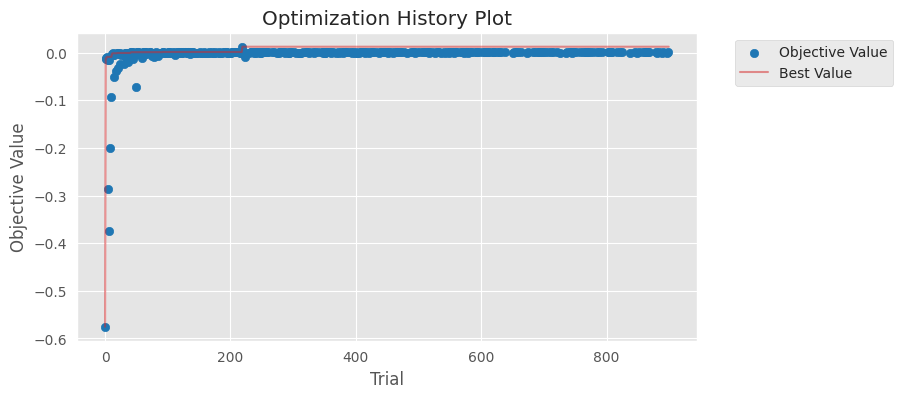

Best Parameters       : {'sign_smoothwin': 1, 'sellmin_idx': None, 'sess_start': '14:30:00', 'buy_thresh': 0.03262922978313418, 'trailstop_pct': 0.2967762565569524}
Best Average Daily P&L: 0.012196590909090912

Hyperparameter importances (higher ⇒ more impact):
  buy_thresh          : 0.676
  trailstop_pct       : 0.286
  sess_start          : 0.025
  sellmin_idx         : 0.013
  sign_smoothwin      : 0.000

Optuna results (and importances) saved to: optuna_results/AAPL_0.0122_predicted.json


In [6]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df_trainval.index.normalize().min().strftime("%Y%m%d")
last_day  = df_trainval.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{round(study.best_value,4)}_predicted.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")